In [1]:
pip install -U bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 25.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, Trainer, TrainingArguments, DataCollatorWithPadding
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np
import time

In [ ]:
# Load model and tokenizer
MODEL_NAME = "Qwen/Qwen2.5-7B"
access_token = "hf_xxxxxxxxxxxxxxxxxxxxxxxxxxxxx"

#quantization_config = BitsAndBytesConfig(load_in_8bit=False,load_in_4bit=True)
quantization_config = BitsAndBytesConfig(
        load_in_4bit=True,
        load_in_8bit=False,
        llm_int8_threshold=6.0,
        llm_int8_has_fp16_weight=False,
        bnb_4bit_compute_dtype=torch.float16,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4",
    )
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME,trust_remote_code=True,token=access_token,model_max_length=2048,
        padding_side="left",
        truncation_side="left")
model = AutoModelForCausalLM.from_pretrained(MODEL_NAME,
                                             token=access_token,
                                             device_map='auto',
                                             quantization_config=quantization_config)

if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    model.resize_token_embeddings(len(tokenizer))

tokenizer_config.json:   0%|          | 0.00/7.23k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/686 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/27.8k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/3.95G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/3.56G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/138 [00:00<?, ?B/s]

In [4]:
# Prompting để dự đoán nhãn (Support, Refuted, Not Enough Info)
def generate_prompt(statement, context, evidence_list):
    evidence_text = "\n".join(evidence_list) if evidence_list else "No evidence provided."
    
    return f"""
        Kiểm tra tính chính xác của các tuyên bố dựa trên thông tin được cung cấp. 
        Đọc kỹ tuyên bố, ngữ cảnh và các bằng chứng, sau đó phân loại tuyên bố vào một trong ba nhãn:
        - *Support*: Nếu tuyên bố được hỗ trợ bởi ngữ cảnh hoặc bằng chứng.
        - *Refuted*: Nếu tuyên bố bị bác bỏ bởi ngữ cảnh hoặc bằng chứng.
        - *N.E.I*: Nếu Không đủ thông tin để xác minh tính đúng/sai của tuyên bố.

        ### Nhiệm vụ:
        1. Đọc và hiểu rõ *tuyên bố*: "{statement}".
        2. Đọc *ngữ cảnh* sau: "{context}".
        3. Phân tích *các bằng chứng liên quan* sau đây:
        {evidence_text if evidence_text else "Không có bằng chứng được cung cấp."}
        4. Dựa trên thông tin trên, phân loại tuyên bố vào một trong ba nhãn (*Support*, *Refuted*, hoặc *N.E.I*).
        5. Trả lời chỉ với duy nhất một nhãn chính xác và không giải thích thêm.

        ### Example Responses:
        - <RESPONSE>: Support
        - <RESPONSE>: Refuted
        - <RESPONSE>: N.E.I
    """
    
def fact_check(statement, context, evidence_list, tokenizer, model):
    try:
        # Generate the prompt
        prompt = generate_prompt(statement, context, evidence_list)
        inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512)
        
        # Generate output from the model
        outputs = model.generate(**inputs, max_new_tokens=8, do_sample=False)
        
        # Decode and clean the response
        response = tokenizer.decode(outputs[0], skip_special_tokens=True).strip()
        response_label = response.split("<RESPONSE>:")[-1].strip()  # Extract label after <RESPONSE>:
        print(f"Kết quả: {response_label}\n")
        
        # Map the response label to numeric categories
        if "Support" in response_label:
            return 0
        elif "Refuted" in response_label:
            return 1
        elif "N.E.I" in response_label:
            return 2
        else:
            return -1  # Unexpected output
    
    except Exception as e:
        print(f"Error during fact-checking: {e}")
        return -1  # Fallback for errors

In [5]:
# Load data
train = pd.read_csv('/kaggle/input/vifactcheck/train_data.csv')
dev = pd.read_csv('/kaggle/input/vifactcheck/dev_data.csv')
test = pd.read_csv('/kaggle/input/vifactcheck/test_data.csv')

In [6]:
results = {}
predicted_labels = []
for index, row in test.iterrows():
    statement = row["Statement"]
    context = row["Context"]
    evidence_list = eval(row["Evidence_List"]) 
    
    print(f"Đang kiểm tra tuyên bố {index} trong testset: {statement}")
    
    try:
        # Predict label
        label = fact_check(statement, context, evidence_list, tokenizer, model)
        predicted_labels.append(label)
        print(f"Predicted label: {label} (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)\n")
    except Exception as e:
        print(f"Error processing statement {index}: {e}")
        predicted_labels.append(-1)

# Thêm nhãn dự đoán vào DataFrame hiện tại
test["Predicted_Label"] = predicted_labels

# Lưu kết quả vào file CSV
output_file = f"fact_check_results_test.csv"
test.to_csv(output_file, index=False, encoding="utf-8-sig")
print(f"Kết quả đã được lưu vào file '{output_file}'.")

# Lưu vào results dictionary
results['Test'] = test

Đang kiểm tra tuyên bố 0 trong testset: Bộ xương bản sao được đưa đến Lodon bằng cách nghép thành con hoàn chỉnh rồi vận chuyển đến.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:2097: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
     <input>Pat

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1 trong testset: Phần vỏ bánh được làm rất công phu, từ giai đoạn xay gạo đến cuốn bánh hết tổng 4 tiếng đồng hồ.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 2 trong testset: Đối tượng cố gắng bỏ chạy sau khi lực lượng công an đón dừng xe để kiểm tra.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 3 trong testset: Vì lượng mưa khổng lồ do cơn bão tạo ra đã dẫn đến nhiều vụ sạt lở và ngập lụt, miền nam Mozambique nhận lượng mưa cao hơn gấp đôi hàng năm, và dự kiến nếu bão cứ tiếp tục độ bổ thì lượng mưa tại đây sẽ cao nhất trong lịch sử từ trước đến giờ.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E

Predicted label: -1 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 4 trong testset: Tại một địa điểm trên địa bàn huyện Củ Chi, TPHCM, Công an đã phát hiện hai nghi phạm có liên quan đến vụ việc là N. được xác định là mẹ ruột bé Th. và B. là người đàn ông xăm trổ xuất hiện trong video clip được lan truyền những ngày gần đây với nội dung bạo hành.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 5 trong testset: Giảm nhẹ công tác tuyên truyền về phòng, chống dịch cúm gia cầm lây lan sang người để người dân hạn chế tiếp xúc với gia cầm ốm, chết và chất thải từ gia cầm bằng cách Sở Thông tin và Truyền thông phối hợp các sở, ngành, Ủy ban nhân dân các quận huyện, thị xã chỉ đạo thực hiện.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 6 trong testset: Những yếu tố xã hội cần thiết cho sự phát triển ổn định và bền vững của mỗi quốc gia, đặc biệt là các nước Châu Á là xây dựng gia đình hạnh phúc, bảo đảm đầy đủ quyền và lợi ích chính đáng của phụ nữ, đây là những vấn đề xã hội đang được góp phần giải quyết tích cực thông qua việc phát triển kinh tế.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 7 trong testset: Trong phim Everything Everywhere All at Once diễn viên Quan Kế Huy sinh năm 1890, người giành giải diễn viên nam chính xuất sắc nhất nói lời cảm ơn Viện hàn lâm vì giải thưởng vinh dự này.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
     <input>Qu

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 8 trong testset: Chuỗi sự kiện “UEH Sharing - Career Fair” là hoạt động khởi đầu cho chương trình “Kết nối cộng đồng - Lan tỏa tri thức - Hành động bền vững” của Trường Đại học Kinh tế TP Hồ Chí Minh trong năm 2023.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 9 trong testset: HĐND TP Thủ Dầu Một sẽ tổ chức phiên họp để bầu chức danh Phó Chủ tịch UBND thành phố, cuộc họp sẽ diễn ra vào 17 giờ ngày 30/3 tại Trung tâm Hội nghị tiệc Plaza.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     *TPO - Tỉnh ủy Bình

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 10 trong testset: Chương trình giáo dục song ngữ sẽ tập trung dạy các môn khoa học tự nhiên bằng tiếng Anh trong giai đoạn hai.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 11 trong testset: Chân sút Brobbey ở tuổi 23 đã có 12 bàn thắng trên mọi đấu trường mùa này cho Ajax và 35 bàn thắng ở các cấp độ trẻ của Hà Lan sẽ là đối thử của Mbappe.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    },
    {
        "

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 12 trong testset: Hầu hết nữ giới sẽ chọn định cư ở quần đảo thay vì tìm nơi khác sinh sống.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 13 trong testset: Chat GPT sử dụng hệ dữ liệu lớn đến từ hàng tỉ trang tài liệu trên toàn thế giới nhưng không hỗ trợ học sinh và giảng viên trong quá trình phát triển kỹ năng viết và đọc hiểu ngôn ngữ.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 14 trong testset: Bụi từ vũ khí chứa urani nghèo có thể đi vào sâu trong các cơ quan nội tạng, gây ung thư phổi, dẫn đến cái chết nhanh chóng.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
     <input> <

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 15 trong testset: Trong doanh nghiệp và văn phòng thì sử dụng Prompt giúp tiết kiệm thời gian và tăng năng suất làm việc gấp 5 lần so với thông thường khi không sử dụng.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 16 trong testset: Câu chuyện về cô gái Tô Thị Sự bị phỏng với việc gom rác vào buổi sáng và tối đến đi hát phòng trà đã khiến nhiều người khâm phục.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 17 trong testset: Trung tâm Dự báo khí tượng thủy văn Quốc gia dự báo miền Bắc có mưa rào rải rác và có nơi có dông.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 18 trong testset: Đề xuất của EVN đưa ra sau khi đơn vị tư vấn là Ban quản lý dự án điện 4 (thuộc EVN) đã rà soát nhu cầu phụ tải điện và xây dựng các thông báo.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    return prompt

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 19 trong testset: Sự việc 2 thanh niên lạ mặt đi xe máy tiếp cận học sinh ở nhiều trường tại Vinh với mục đích bắt cóc chưa được kiểm định chính xác.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
        # Extract the relevant information

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 20 trong testset: Các thủ thuật phẫu thuật được thực hiện khi trẻ 2 tuổi.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</PRE>
    	<PRE

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 21 trong testset: Tại họp báo thường kỳ Bộ Ngoại giao chiều 23/3, Phó Phát ngôn Bộ Ngoại giao Phạm Thu Hằng trả lời câu hỏi của phóng viên về việc Việt Nam có sẵn lòng nâng cấp quan hệ với Hoa Kỳ từ quan hệ hiện tại là đối tác toàn diện, lên quan hệ chiến lược hay không.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    assert isinstance(response,

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 22 trong testset: Bộ Tài chính Hoa Kỳ đảm bảo rằng hệ thống ngân hàng Hoa Kỳ ổn định và có thể chịu được bất kỳ cú sốc tài chính nào.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 23 trong testset: Chủ tịch PSSI cố gắng giúp Indonesia giữ quyền đăng cai U20 World Cup 2023, bên cạnh đó Thổng đốc Bali tuyên bố không cho phép đội tuyển quốc gia U20 Iran tham gia giải đấu.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 24 trong testset: Bạn của Alex Kwong – chồng cũ Abby Choi bị buộc tội vì hỗ trợ cho chồng cũ của Abby Choi chạy trốn.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E

Predicted label: -1 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 25 trong testset: PGS.TS Minh (Học viện Chính trị khu vực 3 - Đà Nẵng) dẫn đoàn học viên lớp cao cấp lý luận chính trị đi thực tế tại tỉnh Khánh Hòa vào tháng 3/2019, đến thắp hương tại Khu tưởng niệm chiến sĩ Gạc Ma ở xã Cam Hải Đông, huyện Cam Lâm.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 26 trong testset: Do có sự khác nhau giữa các tỉnh thành nên Bộ vẫn chịu trách nhiệm ban hành quy chế, ra đề để đảm bảo tính đồng bộ và thể hiện tinh thần đoàn kết của người Việt.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 27 trong testset: Thành phố đã chỉ đạo công an tăng cường theo dõi, giám sát qua camera để phát hiện người vi phạm và cũng đề người dân quan sát và tình báo cho chính quyền.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 28 trong testset: Bộ Phát triển kỹ thuật số Nga đã thừa nhận có tới 500.000 nhân viên trong lĩnh vực công nghệ thông tin của Nga đã rời khỏi nước vào tháng trước.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 29 trong testset: Khoảng 1/3 tổng số ngoại hành tinh là siêu Trái Đất - đây là thuật ngữ dùng cho những hành tinh nhỏ hơn Trái Đất và nhẹ hơn hành tinh khí khổng lồ.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E

Predicted label: -1 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 30 trong testset: Vinh dự là người Việt Nam giành được học bổng danh giá, Tường Anh mong muốn được theo chuyên ngành khoa học máy tính để phát huy thế mạnh của bản thân.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 31 trong testset: Covid-19 đang bước vào giai đoạn cầm chừng do đó việc bắt buộc phải đeo khẩu trang vẫn còn tiếp tục


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
        # Extract the relevant information

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 32 trong testset: Dù là xét tuyển hay thi tuyển thì thí sinh đều không phải cố gắng học nhiều.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
     <input>Th

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 33 trong testset: Video clip gây xôn xao dư luận những ngày gần đây đang được lan truyền trên mạng xã hội với thông tin một bé trai còn đang mặc tã bị một người đàn ông bạo hành bắt cách ép buộc em hút ma túy.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 34 trong testset: NXB Regiospectra ấn hành tại Đức, bìa sách Mùi hương trầm bản tiếng Đức Tập tùy bút du hành nổi tiếng Mùi hương trầm của Nguyễn Tường Bách vừa được chính tác giả dịch sang tiếng Đức.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
     <input>Ng

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 35 trong testset: Giám đốc tài chính của Victoria's Secret - Timothy Johnson cho biết, quyết định này được đưa ra trong cuộc họp của ban quản lý nhãn hiệu danh tiếng vào tháng 3/2023, theo đó, công ty sẽ dụa trên tiêu chí tiếp thị để rót tiền vào các hoạt động thương mại.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 36 trong testset: Kết luận của UBKT Trung ương tại Kỳ họp thứ 23 đối với Ban cán sự đảng UBND tỉnh Đồng Nai và một số tổ chức đảng, đảng viên có liên quan là thi hành kỷ luật Ban Thường vụ Tỉnh ủy Đồng Nai, trong đó có 2 cá nhân trong tổ chức bị phạt nặng nhất.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 37 trong testset: Nhiều bình luận bày tỏ sự mong chờ tác phẩm và kỳ vọng vào sự kết hợp của 2 diễn viên Lee Dong Wook và Kim So Yeon chủ yếu đến từ khán giả Việt Nam.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
     <input> <

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 38 trong testset: Prompt điều khiển hành vi và kết quả của AI và không yêu cầu Ai tuân theo các tiêu chí và ràng buộc nào.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E

Predicted label: -1 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 39 trong testset: Theo thông báo của Liên đoàn bóng đá Hà Lan,  trong đội hình của HLV Ronald Koeman sẽ có 5 thành viên phải rút khỏi đợt tập trung cho vòng loại Euro 2024 vì nhiễm virus lạ.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 40 trong testset: Dù hiện tại quá trình này vẫn gặp nhiều khó khăn nhưng đẩy mạnh chuyển đổi số trong truy xuất nguồn gốc nông sản là việc làm cấp bách giúp nông sản Việt nhanh chóng tham gia chuỗi cung ứng toàn cầu.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    # Extract the relevant information from

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 41 trong testset: Chiều 28/3, tại Văn phòng Cục An ninh Quốc phòng, Bộ Công an tổ chức họp báo thông tin về tình hình, kết quả các mặt công tác công an quý I/2023, nhiệm vụ công tác trọng tâm thời gian tới với người chủ trì cuộc họp là Trung tướng Tô Ân Xô.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 42 trong testset: Có học sinh của Trường THPT Phú Nhuận bị dụ dỗ, lừa đảo trước cổng trường.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 43 trong testset: Nền cờ có màu đỏ tươi như màu cờ Tổ quốc; biểu tưởng "Búa - Liềm" được đặt ở trung tâm lá cờ có màu vàng tươi như màu ngôi sao 5 cánh của cờ Tổ quốc.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 44 trong testset: Kỷ niệm 1980 năm Ngày mất Hai Bà Trưng (6-2-43 – 6-2-2023 âm lịch) do Hội Liên hiệp Phụ nữ (LHPN) TP.HCM phối hợp Sở Văn hóa - Thể thao và Công viên Lịch sử Văn hóa Dân tộc TP tổ chức vào ngày 25-2.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 45 trong testset: Nhật Bản đã thể hiện rất tốt trước Uruguay nên quyết tâm đả bại Colombia để vô địch trên sân nhà.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 46 trong testset: Theo khoản 1 Điều 56 Luật Đất đai năm 2003, doanh nghiệp nhà nước phải tiến hành thẩm định giá, xác định giá trị chuyển nhượng đất dự án và đưa ra đấu giá theo quy định pháp luật trong việc chuyển nhượng đất dự án.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 47 trong testset: Theo thống kê của Phòng Cảnh sát môi trường, Công an TP Đà Nẵng, từ năm 2019 đến 2023, đơn vị đã xử lý 18 trường hợp vi phạm về tiếng ồn, xử phạt 9 cá nhân và 5 tổ chức  với tổng số tiền hơn 232 triệu đồng., có nhiều quán còn tái phạm nhiều lần, điển hình như quán Food&Drink đã bị buộc thôi kinh doanh.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 48 trong testset: Hệ thống tên lửa đạn đạo tầm ngắn Iskander có đầu đạn thông thường lẫn đầu đạn hạt nhân đã được đưa đến Nga.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     *Tuyên bố*: Nga đã

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 49 trong testset: Trong Tháng hành động an toàn, vệ sinh lao động năm 2023, các hoạt động hướng tới kêu gọi doanh nghiệp không tăng thời gian làm thêm quá quy định, bố trí cho lao động nghỉ ngơi, chăm lo sức khỏe, đời sống cho người lao động…


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 50 trong testset: Tại Diễn đàn châu Á Bác Ngao ở tỉnh Hải Nam, Trung Quốc, ngày 30-3, Thủ tướng Singapore Lý Hiển Long đã đưa ra tuyên bố.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
        # Extract the relevant information

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 51 trong testset: Theo đó, sửa đổi khoản 1 và khoản 2 Điều 1 về nhân sự tại Quyết định số 596/QĐ-TTg của Thủ tướng Chính phủ về việc thành lập Ban Chỉ đạo quốc gia về hội nhập quốc tế như sau: Trưởng Ban Chỉ đạo quốc gia là Thủ tướng Chính phủ Phạm Minh Chính. Phó Trưởng Ban Chỉ đạo quốc gia là các Phó Thủ tướng Chính phủ: Lê Văn Thành, Trần Hồng Hà, Trần Lưu Quang.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
     <input>Th

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 52 trong testset: Với chương trình cử nhân tài năng và cử nhân Asean Co-op, thí sinh đăng ký tối đa ba nguyện vọng đối với tất cả phương thức xét tuyển.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 53 trong testset: Điều phối viên Truyền thông Chiến lược của Hội đồng An ninh Quốc gia Nhà Trắng John Kirby nói rằng Washington hiện đã có chứng cứ về việc vũ khí hạt nhân của Nga được triển khai ở Belarus.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 54 trong testset: Các hãng hàng không Việt Nam, công ty lữ hành đang ráo riết chuẩn bị nguồn lực, đội bay, cơ sở lưu trú sẵn sàng để thực hiện các chuyến bay thuê chuyến từ Việt Nam sang Trung Quốc.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 55 trong testset: Báo Nông thôn ngày nay đã gửi văn bản số 133-CV/NTNN ngày 23-3-2023 đến Cục Báo chí phản ánh vấn đề nhóm phóng viên bị hành hung, cản trở tác nghiệp.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 56 trong testset: Đây là cuộc đụng độ thứ 8 giữa hai đội tuyển quốc gia và Hàn Quốc đã thống trị trong những lần gặp gỡ trước đó với 4 chiến thắng (hòa 2, chỉ thua 1). Colombia không hề là một đối thủ tầm thường, thế nhưng họ lại bị Hàn Quốc áp đảo. Chi tiết trên cho thấy không chỉ ở giải chính thức, Hàn Quốc cũng rất đầu tư vào các trận đấu giao hữu.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 57 trong testset: Chiều 23/3, Chánh văn Phòng Sở Giáo dục và Đào tạo TP Hồ Chí Minh ông Hồ Tấn Minh khẳng định nếu trong trường hợp bất khả kháng, học sinh không có mã định danh cá nhân thì ngành giáo dục sẽ cấp một mã tạm cho các em để tham gia công tác tuyển sinh.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 58 trong testset: Lí do bị lộ thông tin cá nhân có thể là do hệ thống bị tấn công và lấy thông tin hoặc là do người của hệ thống bán thông tin cho bên thứ ba.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </question>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 59 trong testset: Trận đấu tiếp theo của U20 Việt Nam là gặp U20 Iran tại VCK U20 châu Á.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 60 trong testset: Đội tuyển Việt Nam trải qua 3 trận đấu với Iraq, UAE, Kyrgyzstan, thua đậm ở trận đấu với UAE với tỉ số 0-3.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 61 trong testset: Đây là biệt thự bốn tầng tọa lạc tại số 45 đường Barker, với tổng diện tích sàn 437m2, Thời báo Kinh tế Hong Kong đưa tin. Ở khu biệt thự The Peak, giá mỗi foot vuông (1 foot vuông = 0,0929m2) có mức 255.000 HKD, đánh bại mức 140.800 HKD được thiết lập vào năm 2021, khi một căn hộ tại dự án Mount Nicholson được bán.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 62 trong testset: Đề xuất sửa đổi của Ngân hàng Nhà nước cũng mang tính chặt chẽ hơn với thị trường, cụ thể là ngân hàng có thể mua điợc trái phiếu khi hệ số nợ không vượt quá 6 lần dựa trên báo cáo tài chính mới nhận đã được kiểm toán.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 63 trong testset: Chính thức khởi động Giải thưởng Nhiếp ảnh Heritage 2023 từ ngày 1/4 đến hết ngày 31/7/2023.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 64 trong testset: Thời tiết tại Thổ Nhĩ Kỳ khắc nghiệt hơn so với Việt Nam gây ra không ít khó khăn đối với đoàn cứu hộ Việt Nam vì sự chênh lệch nhiệt độ giữa ngày và đêm.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert isinstance(

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 65 trong testset: Giám đốc Đài Khí tượng thủy văn khu vực Nam Bộ ông Lê Ngọc Quyền năm nay 60 tuổi cho biết đài được thành lập theo Quyết định số 133/TTg ngày 30-3-1993 của Thủ tướng Chính phủ, trên cơ sở sáp nhập 13 đài Khí tượng thủy văn các tỉnh tại Nam Bộ.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 66 trong testset: Sau khi chị T. bị nhóm của Phùng làm nhục và rời đi, cô gái ở Bình Thuận mới phát hiện mình bị mất chiếc iPhone 14 Pro Max.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 67 trong testset: Sử dụng Chat GPT giúp việc học tập hiệu quả hơn nhưng một số bạn trẻ lại đang lạm dụng nó để làm bài tập của mình vì lười biếng.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<example

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 68 trong testset: Trước đây, khi Anh rời khỏi khối EU khiến người dân nước này hoang mang, nên sau khi Anh trở thành thành viên, CPTPP sẽ trở thành thị trường của hơn 500 triệu dân.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 69 trong testset: Sau khi tiến hành xác mình, Cơ quan cảnh sát điều tra Công an quận Sơn Trà đã kết luận, xác định vụ việc trên có dấu hiệu của tội phạm.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 70 trong testset: Áp lực thi tuyển sinh, nhiều học sinh ăn uống, ngủ nghỉ không điều độ, căng thẳng quá mức.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 71 trong testset: Trương Huệ Vân sinh năm 1980 là tổng giám đốc Công ty CP Tập đoàn quản lý bất động sản Windsor đã bị C03 khởi tố, bắt tạm giam 5 ngày để điều tra, xác định bị can đã có hành vi gian dối trong việc phát hành, mua bán trái phiếu trái quy định của pháp luật để chiếm đoạt hàng nghìn tỉ đồng của người dân trong thời gian 2018 - 2019.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 72 trong testset: Công trình cầu Nam Lý trên đường Đỗ Xuân Hợp, TP Thủ Đức dài 750 m, trong đó phần cầu dài 450 m, rộng 20 m; còn lại là đường dẫn rộng 30-37 m.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 73 trong testset: Khi mới thành lập, khách sạn được đặt tên là "Grand Hotel de Hue" và nhanh chóng trở thành trung tâm thương mại, văn hóa, du lịch của kinh thành Huế vào triều Nguyễn.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
     <input>Th

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 74 trong testset: Giám đốc Sở Y tế Quảng Nam, ông Mai Văn Mười cho biết các bệnh nhân trong vụ ngộ độc do cá chép ủ chua xảy ra trên địa bàn huyện Phước Sơn sức khỏe đã tạm ổn, khả năng tuần tới sẽ xuất viện.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 75 trong testset: Tằng Xỉu Phùng và V.M.K đã ly thân theo thông tin của công an, tuy nhiên khi thấy anh K. chở chị T. đi mua đồ, mẹ con bà Xường đã chặn đầu xe, yêu cầu hai người này ra khỏi xe nói chuyện.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
     <input>Đ

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 76 trong testset: Theo Medical News Today, một nghiên cứu năm 2017 cho rằng vitamin C có thể giúp giảm các triệu chứng cảm cúm và chanh chưa nhiều vitamin C.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
     <inputs>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 77 trong testset: Tòa án không có khái niệm “tiền công tư vấn để cầu thủ Barcelona khỏi mắc lỗi” nên iền tư vấn sẽ bị quy thành tiền hối lộ trọng tài.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    return prompt

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 78 trong testset: CLB Barcelona liên quan vụ án hối lộ trọng tài khiến người hâm mộ hoang mang, Chủ tịch và nhà tài trợ CLB hiện vẫn đang giữ im lặng chờ đợi điều tra.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 79 trong testset: NASA đã công bố bức hình tuyệt đẹp của WR 124 vào ngày 15/3, với hình ảnh ngôi sao này được bao quanh bởi mây khí bụi, là vật chất thoát ra từ ngôi sao già cỗi trong các vụ phóng hỗn loạn và ngẫu nhiên.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
     <input>WR

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 80 trong testset: Theo thông tin từ Báo Tuổi trẻ Online, vào ngày 20-3, các thủ lĩnh dân quân châu Phi đến từ Cộng hòa Dân chủ Congo, Mali và Uganda đã bị kết án bởi ICC với tội ác chiến tranh và tội ác chống lại loài người. Án phạt từ 9 đến 30 năm tù, bao gồm cả án tù chung thân, đã được đưa ra.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E

Predicted label: -1 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 81 trong testset: Việc nghệ sĩ Vũ Linh qua đời vào tối ngày 5/3 khiến nhiều nghệ sĩ cảm thấy bàng hoàng, trên các trang mạng cũng ngập tràng lời tiếc thương.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    assert (
        response

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 82 trong testset: Nguyễn Thị Tâm sẽ đối đầu với Nikhat Zareen, võ sĩ nước chủ nhà Ấn Độ, trong trận chung kết Giải vô địch Boxing nữ thế giới 2023 hạng 48-50 kg.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 83 trong testset: Pho tượng An Dương Vương có một lịch sử khá đặc biệt. Năm 1790, trong quá trình trùng tu đền Thượng ở xã Cổ Loa, Hà Nội, các cụ làng Cổ Loa đã tình cờ đào được một kho đồng tại đền Thượng. Theo lời kể của nhân dân, từ kho đồng này, các nghệ nhân đã sử dụng đất sét thịt để làm cốt mẫu và sáp ong để tạo hoa văn cho việc đúc tượng An Dương Vương. Họ cũng đắp lớp đất trộn giấy dó và trấu để tạo khung xương cho tượng. Khi khuôn được nung và sáp ong chảy ra, nghệ nhân đã rót đồng nóng chảy vào khuôn. Sau khi đồng nguội, họ tiếp tục dỡ khuôn và tiến hành sửa chữa cho đến khi tượng hoàn chỉnh.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 84 trong testset: Trong bối cảnh xung đột giữa Nga và Ukraine đang diễn biến căng thẳng, Nga cảnh báo hành vi khiêu khích của các quốc gia EU liên tục gửi viện trợ Ukraine có thể dẫn đến hậu quả thảm khốc.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert isinstance(response

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 85 trong testset: Theo sửa đổi khoản 1 và khoản 2 Điều 1 về nhân sự tại Quyết định số 596/QĐ-TTg, Thủ tướng Chính phủ Phạm Minh Chính là Trưởng Ban Chỉ đạo quốc gia.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    return prompt

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 86 trong testset: Giáo sư Karen Bakker tại Đại học British Columbia (Canada) sinh năm 1970 đã có cuộc trò chuyện với các biên tập viên trang Scientific American cho biết cách các nhà nghiên cứu đang tận dụng công nghệ mới để hiểu được giao tiếp của động vật.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
     <input> <

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 87 trong testset: Câu chuyện bị đánh rớt của Wesley Anna được nhiều người tin tưởng nên cô đã đưa ra một số tài liệu thống kê những nơi mình đã ứng tuyển.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 88 trong testset: Các ngân hàng đối thủ của Deutsche Bank đều có giá cổ phiếu tăng.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
     <input> Deutsche

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 89 trong testset: Tiếp tục triển khai các biện pháp phòng chống dịch bệnh COVID-19 theo hướng dẫn của Bộ Y tế như đeo khẩu trang, rửa tay sát khuẩn, không tụ tập đông, đẩy mạnh giám sát để đánh giá nguy cơ và kịp thời ứng phó dịch bệnh trong mọi tình huống.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 90 trong testset: Bà Trang nhìn nhận nó có thể làm nhanh và tốt mảng thông tin nhưng không phải để thay thế hoàn toàn nhân viên mà chỉ để giúp họ làm việc hiệu quả hơn khi một số công việc được tự động hóa, công nghệ này hiện đã có thể thay thế được các mối quan hệ giữa chuyên gia và khách hàng.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 91 trong testset: Trận động đất độ lớn 7,8 có tâm chấn tại Thổ Nhĩ Kỳ đã gây thiệt hại lớn tại nước này và hai nước láng giềng là Bulgaria và Syria, có hàng chục nghìn người bị thương, cướp đi sinh mạng của hơn 29.000 người.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
        # Extract the relevant information

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 92 trong testset: Pháp luật đất đai hiện hành theo luật sư Nguyễn Văn Hậu vẫn chưa ghi nhận chính thức về việc doanh nghiệp VN được phép thế chấp quyền sử dụng đất cho tổ chức kinh tế nước ngoài để có thể vay vốn hoạt động.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 93 trong testset: Biện pháp xác minh bằng giọng nói của người dùng sẽ được TikTok cũng sẽ áp dụng để chánh lộ thông tin và sẽ không thể xác định danh tính người dùng nếu thiếu địa chỉ nhà.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E

Predicted label: -1 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 94 trong testset: Việt Nam được AFD tài trợ 5.000 tỷ phí dự án trong chương trình kêu gọi hỗ trợ.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 95 trong testset: Ông Jean-Paul Guihaumé, Đại sứ đặc trách Ngoại vụ địa phương, Bộ Châu Âu và Ngoại giao Pháp nhấn mạnh nội dung trên trong cuộc trao đổi với phóng viên Báo Điện tử Chính phủ tại Hội nghị hợp tác giữa các địa phương Việt Nam và Pháp lần thứ 12. 


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 96 trong testset: Sở cũng yêu cầu các cơ sở giáo dục phối hợp với lực lượng chức năng tại địa phương đảm bảo trật tự, an toàn cho học sinh, sinh viên tại những khu vực đông đúc gần trường.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 97 trong testset: Bảy trường đại học kỹ thuật hàng đầu Việt Nam ký kết hợp tác đào tạo kỹ sư và chuyển giao công nghệ phục vụ cộng đồng.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 98 trong testset: Sự xuất hiện của một hành tinh đá lớn như siêu Trái Đất sẽ làm hỗn loạn quỹ đạo của phần lớn hành tinh khi nó có thể đẩy Trái Đất và nhiều hành tinh khác ra khỏi hệ.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E

Predicted label: -1 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 99 trong testset: Thủ tướng Chính phủ Võ Văn Thưởng vừa ký Quyết định 320/QĐ-TTg, theo đó khoản 1 và khoản 2 Điều 1 về nhận sự tại Quyết định số 596/QĐ-TTg của Thủ tướng Chính phủ về việc thành lập Ban Chỉ đạo quốc gia về hội nhập quốc tế sẽ được sửa đổi.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert isinstance(

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 100 trong testset: Chương trình được tổ chức thông qua hình thức tham dự trực tiếp, phát sóng trên truyền hình và xem trực tuyến trên các nền tảng mạng xã hội.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 101 trong testset: Hai trận đấu họ thua kém hoàn toàn đối thủ về lối chơi và những thống kê quan trọng như cầm bóng, dứt điểm cầu môn và dĩ nhiên là bàn thắng khiến họ có 1 trận thắng và 1 trận thất bại 1-2 trước New Zealand.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    return prompt

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 102 trong testset: Việc triển khai các hoạt động đầu tư còn chậm do chưa có sự đồng bộ, thống nhất giữa các văn bản quy phạm pháp luật, sự phân công, phân cấp gắn với trách nhiệm của người đứng đầu chưa được đẩy mạnh.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    return prompt

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 103 trong testset: Khách hàng có số thứ tự 27 ông Trần Tấn 60 tuổi vẫn ra quầy giao dịch để thực hiện cập nhật Dù không nhận được tin nhắn thông báo của nhà mạng.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert isinstance(response

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 104 trong testset: Tổ công tác yêu cầu quản lý điểm kinh doanh có mặt trong vòng 48 tiếng để làm rõ việc chấp hành pháp luật trong hoạt động cầm cố, cho vay.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </instruction>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 105 trong testset: Ông Long đã làm bẫy chuột bằng chất hóa học để diệt chuột phá ruộng.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 106 trong testset: Một số loại thuốc được đảm bảo nguồn cung do cho phép các giấy đăng ký lưu hành thuốc, nguyên liệu làm thuốc hết thời hạn hiệu lực trong năm 2023 vẫn được cho phép dùng trong năm 2024.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 107 trong testset: Thông tin 2 thanh niên lạ mặt đi xe máy, tiếp cận học sinh ở nhiều trường học tại thành phố Vinh (Nghệ An) với ý đồ xấu đã nhanh chóng lan truyền đến nhóm phụ huynh học sinh, gây nên sự hoang mang đến các phụ huynh.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 108 trong testset: BV Hoàn Mỹ Sài Gòn là BV duy nhất tại Việt Nam phát hiện ung thư gan khi khám sức khỏe tổng quát.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 109 trong testset: Vào ngày 6/3, cơn bão lần đầu tiên được đặt tên là Freddy và đã di chuyển hơn 8.000 km qua phía nam Ấn Độ Dương tới đông nam châu Phi.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    assert (
        response

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 110 trong testset: Đề án dạy và học môn Toán, Khoa học và tiếng Anh tích hợp theo khung chương trình quốc gia Anh và Việt Nam được đưa vào giáo dục từ năm 2017.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 111 trong testset: Kết quả kỳ thi này sẽ được sử dụng để xét tuyển vào trường với tỉ lệ tối đa 25% chỉ tiêu theo ngành.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 112 trong testset: Một cổ đông cho biết đã mua cổ phiếu DGC tại mức giá 140.000 đồng/cổ phiếu và công ty DGC đã quyết định từ chối đề nghị mua lại cổ phần của chính mình.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 113 trong testset: Bộ Công an đã cam kết ủng hộ, hỗ trợ tỉnh 1.420 căn nhà, tương đương hơn 75 tỷ đồng, đến thời điểm hiện nay, đã có 800 móng nhà được xây dựng.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 114 trong testset: Trẻ em được tham gia môi trường mạng có rất nhiều bất cập và nguy hiểm khi các nhóm đối tượng có mục đích không tốt luôn lăm le lợi dụng sự thiếu hiểu biết của chúng.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
        # Extract the relevant information

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 115 trong testset: Lần thứ hai Karolina Bielawska tới Ấn Độ trong nhiệm kỳ, màn xuất hiện hoành tráng của đương kim Hoa hậu Thế giới khiến khán giả phải trầm trồ.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 116 trong testset: Mỗi doanh nghiệp có hàng chục, thậm chí hàng trăm loại, theo Vụ phó Bảo hiểm xã hội Nguyễn Duy Cường nên các khoản phụ cấp tính đóng bảo hiểm xã hội (BHXH) khó tách bạch.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 117 trong testset: Tập thể Ban Thường vụ Tỉnh ủy sẽ lãnh đạo giúp đưa Bình Thuận phát triển thành một thành phố trực thuộc trung ương.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    print("Example Response

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 118 trong testset: Khi học sinh không trúng tuyển NV1 được xét tuyển NV2 nhưng phải có điểm xét tuyển cao hơn điểm chuẩn trúng tuyển NV1 của trường ít nhất 1 điểm và nếu vẫn không trúng tuyển NV2 thì thí sinh đó đã bị trượt xét tuyển.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert isinstance(response

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 119 trong testset: Phó Thủ tướng Trần Hồng Hà yêu cầu Bộ Kế hoạch và Đầu tư hướng dẫn thực hiện cơ chế đặc thù về chỉ định thầu.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 120 trong testset: Với tổng chiều dài 399,99 m, rộng 61,3 m, mớn nước tàu vào -15 m và mớn nước tàu ra -15.5 m, OOCL Spain được biết đến là siêu tàu container lớn nhất thế giới khi sức chở lên đến 24.188 TEU.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 121 trong testset: Vào ngày 26/5, Công an huyện Hóc Môn cùng Phòng Cảnh sát Hình sự đã xác định được hai người có liên quan đến vụ việc bé trai nghi bị ép hút ma túy là L.V.B và N.T.N.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    assert isinstance(response,

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 122 trong testset: Trong bối cảnh đại dịch COVID-19, năm 202 kim ngạch xuất khẩu của SHTP vẫn tăng và đạt 20,9 tỉ USD, chiếm 51,86% kim ngạch xuất khẩu của thành phố, dự kiến năm 2022 tăng lên mức 28 tỉ USD.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 123 trong testset: Các nhà khoa học của Tổ chức Nghiên cứu khoa học và công nghiệp Úc (CSIRO) cho biết rễ của cây bạch đàn có thể ăn sâu 80m vào lòng đất để tìm kiếm nguồn nước.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 124 trong testset: Giá của tất cả các mặt hàng nông nghiệp, bao gồm cả ngô và lúa mì, được giao dịch ở mức 8.100 đồng/kg, trên thị trường trong nước đã giảm đáng kể.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 125 trong testset: Nhiễm nấm thông thường được chỉ định dùng thuốc kháng nấm, tuyệt đối không được đặt ống dẫn lưu do có thể gây nhiễm nấm nặng hơn.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
     <input>Ch

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 126 trong testset: Cách đây khoảng 109 năm Yersin đã tìm cách lên đỉnh núi Hòn Bà ở độ cao 1.500m  cùng với cộng sự của mình.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 127 trong testset: Độ tuổi nghỉ hưu ở nước Anh dự kiến là sẽ tăng lên 68 tuổi trong vòng 23 năm tới.



Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 128 trong testset: Gần 11.400 máy tính bảng được Chủ tịch nước trao tặng học sinh vùng sâu, vùng xa trong tỉnh Kon Tum vào chiều 7/3.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    assert isinstance(response,

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 129 trong testset: Tổng lợi nhuận kế toán sau thuế của LPB đạt 5.690 tỷ đồng và 4.510 tỷ đồng lãi sau thuế, ESP tăng từ 2.135 đồng của năm 2021 lên 2.671 đồng trong năm 2022.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 130 trong testset: Bên cạnh việc đầu tư, bổ sung hệ thống camera giám sát giao thông thì sở GTVT TP cũng đã triển khai xử phạt các hành vi vi phạm hình sự đối với bất kì cá nhân, tổ chức doanh nghiệp nào.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
     <input>Ch

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 131 trong testset: Hạ nghị sĩ thuộc đảng Cộng hòa nói TikTok mặc dù thiết kế giảm thiểu tác hại cho trẻ em nhưng lại gây nghiện cho trẻ để kiếm lợi nhuận.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 132 trong testset: Quy hoạch chưa ưu tiên phát triển du lịch bền vững.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 133 trong testset: Tại chương trình Vầng trăng cổ nhạc tối 27/3, khán giả vô cùng xúc động khi xem tiết mục ca cổ của Võ Minh Lâm vì trước đó, anh nhận tin ba mình đột ngột qua đời.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 134 trong testset: Cô phụ việc chăm sóc cho Hồng Nga là người chăm sóc cho nữ nghệ sĩ hơn 30 năm qua, từ việc ăn uống, ngủ nghỉ, lo trang phục biểu diễn, hiện đang sinh sống ở Trung Quốc.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    print("Example

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 135 trong testset: Nam và nữ sống trên quần đảo Faroe có lối sống giống nhau vì cả hai đều sống theo phong cách truyền thống.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 136 trong testset: Sau đó, vào tháng 9/1985, Thornton cất cánh trong phi vụ buôn lậu ma túy cuối cùng, nhảy từ một chiếc máy bay ở Knoxville, Tennessee, với chiếc túi trống đựng cocaine trị giá 15 triệu USD.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    assert isinstance(

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 137 trong testset: Việt Nam và Trung Quốc sẽ tiếp tục hợp tác chặt chẽ trong lĩnh vực nông nghiệp.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    assert (
        response

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 138 trong testset: Ông Gavin Christopher Newsom Thống đốc bang California, vừa ký ban hành một đạo luật chính thức công nhận Tết Âm lịch là một ngày lễ của tiểu bang miền Tây này.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 139 trong testset: Roy vẫn không nắm được những yếu tố cụ thể đã góp phần vào màn trình diễn tệ hại của Man Utd trước Fulham.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 140 trong testset: U20 Việt Nam đang dẫn đầu bảng B VCK U20 châu Á với 6 điểm.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
     <input>U

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 141 trong testset: Trước Toney là Jarrod Bowen (West Ham) và James Justin (Leicester), Toney chỉ là "tân binh" thứ 3 được Southgate sử dụng trong 12 tháng qua, ngoài những lúc dự bị thay người thì chưa bao giờ anh được đá chính.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</PRE>
    </div>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 142 trong testset: Ngân sách của TP Cần Thơ năm 2023 là 1.000 cho dự án tuyến cao tốc Châu Đốc - Cần Thơ - Sóc Trăng đi qua địa bàn 3 huyện là Vĩnh Thạnh, Cờ Đỏ và Thới Lai với trường hợp bị ảnh hưởng là 952, dự kiến nền TĐC là khoảng 260.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 143 trong testset: Nhà máy MPE Smart Factory đã được khánh thành vào ngày 25/3 sau khoảng 10 năm xây dựng.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    assert (
        response

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 144 trong testset: Bộ trưởng Quốc phòng Nga trao Huân chương dũng cảm cho các phi công vì đã ngăn chặn chiếc máy bay do thám không người lái của Mỹ trên địa phận của Nga.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 145 trong testset: Về bất động sản và thế chấp theo tỉ phú Musk đây là vấn đề nghiêm trọng nhất hiện nay.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</PRE>
    	<PRE

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 146 trong testset: “Chăm chỉ, đam mê với mục tiêu của mình, dám đương đầu khó khăn và vượt qua vùng an toàn của bản thân chính những yếu tố làm tiền đề cần có ở các bạn trẻ để thành công trên con đường nghiên cứu khoa học” được Tiến sĩ Lê Thị Phương chia sẻ trong một buổi talkshow ở các trường đại học.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 147 trong testset: Chương trình âm nhạc và nghệ thuật TIS GALA 2023 cũng nhau các show giải trí như "Giọng ải giọng ai" và "Ca sĩ giấu mặt" tạo điều kiện để tài năng được phát hiện, nuôi dưỡng và phát triển.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
     <input> <

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 148 trong testset: Ngày 25/3, Công an đã triệu tập người đàn ông là chồng của cô giáo chủ nhiệm của một học lớp 6 trên địa bàn để làm rõ hành vi dâm ô với em, theo thông tin trước đó em được ba mẹ tin tưởng cho ngủ lại nhà cô giáo, nhưng sau đó lại xảy ra sự việc này.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 149 trong testset: Bộ trưởng Quốc phòng Ukraine Oleksii Reznikov ngày 27.3 thông báo đã nhận được những chiếc xe tăng Challenger 2 đầu tiên do Anh cung cấp, theo AFP.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </instruction>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 150 trong testset: Với các triệu chứng như sốt, ho, đau họng, mệt mỏi, ói; trong đó có những học sinh sốt đến 39℃ bác sĩ nhận định ban đầu nghi ngờ 22 trẻ mắc cúm.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
     <input> <

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 151 trong testset: Công ty DGC dự kiến đầu tư tổng cộng 550 tỷ đồng vào các dự án xây dựng trong năm 2023.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    return prompt

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 152 trong testset: Masan đẩy nhanh tiến độ mở chuỗi cửa hàng flagship nhằm đạt mục tiêu mở 1.000 ki-ốt.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 153 trong testset: 50 cháu đang nhập viện khám sàng lọc tại Bệnh viện Bạch Mai, Bệnh viện Đống Đa, Bệnh viện Xây dựng vì bị đau bụng buồn nôn sau bữa ăn trưa khi đi tham quan trang trại Cánh Buồm Xanh tại huyện Gia Lâm.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 154 trong testset: Nhiều đối tượng ngoại quốc đã sử dụng thủ đoạn dụ dỗ lừa đảo học sinh đầu giờ học hay giờ về đi theo hoặc lên xe người lạ để bắt cóc tống tiền các phụ huynh nhằm chuộc lợi.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 155 trong testset: Đặng Văn Châu và Nguyễn Văn Tân (cùng trú huyện Tiền Hải, tỉnh Thái Bình)  bị khởi tố, thi hành lệnh bắt để tạm giam  về tội danh trộm cắp.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 156 trong testset: Philippines chủ trì Diễn đàn biển ASEAN (AMF) lần thứ 12 và Diễn đàn biển ASEAN mở rộng (EAMF) lần thứ 10.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    assert isinstance(response,

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 157 trong testset: Tỉnh Long An có kế hoạch thực thi mục tiêu phát hiện và xử lý kịp thời tất cả các ổ dịch bệnh truyền nhiễm mới.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </PRE>
     <PRE>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 158 trong testset: Nhật Bản đã mời 1 đội bóng hàng đầu của Nam Mỹ là Uruguay tham gia giải đấu giao hữu Kirin Cup, việc này giúp cho Nhật Bản có thể kiểm tra lại đội hình cho những sự kiến sắp tới.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 159 trong testset: Tối ngày 24/3, Minh Hằng chia sẻ video về quá trình cấy phôi thai và lý do chọn phương pháp IVF của vợ chồng cô và bài đăng được nhiều người quan tâm và ủng hộ việc cô chọn phương pháp IVF.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 160 trong testset: Những tháng đầu năm, các chương trình kích cầu sức mua trên sàn thương mại điện tử diễn ra đã không đem về doanh thu tăng trưởng như kỳ vọng.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 161 trong testset: Mbappe khi mới 27 tuổi đã được huấn luyện viên của Les Blues, Didier Deschamps chính thức chọn thay thế Hugo Lloris đeo băng đội trưởng tuyển Pháp.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 162 trong testset: Trong ngành hàng nông, lâm, thủy sản thì giống đóng vai trò vô cùng quan trọng, chính vì thế cần đưa các giống có năng suất cao để giảm sự phụ thuộc vào nhập khẩu, thay vào đó có thể xuất khẩu giống của nước ta ra nước ngoài.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 163 trong testset: Nhiều ngôi sao Hoa ngữ cũng gặp trường hợp như Đô Mỹ Trúc, ảnh khác xa đời thật ví dụ như Lưu Diệc Phi bị chê quá gầy, thô khác với hình ảnh thon thả, dịu dàng đã đăng tải.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 164 trong testset: Theo Kế hoạch số 2796/KH-BVHTTDL được công bố vào năm 2021, Bộ Văn hóa, Thể thao và Du lịch (Bộ VHTTDL) cũng chỉ ra rằng, việc hướng dẫn toàn dân tập luyện thể dục thể thao, nâng cao sức khỏe, phát triển tầm vóc, thể lực là một trong những mục tiêu hàng đầu trong giai đoạn 2021-2025, nhằm góp phần nâng cao sức khỏe cộng đồng, hướng đến xây dựng đất nước và con người Việt Nam. 


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 165 trong testset: Chất lượng báo, tạp chí Đảng đã được cải thiện, tuy nhiên cách thể hiện khá khô khan và có nhiều bài viết thiếu chuyên sâu, bàn luận các vấn đề cũ.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    return prompt

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 166 trong testset: Nặng 700 kg, cao 1,7 m, rộng 1,6 m, dài 2,3 m, tượng cố nhạc sĩ Trịnh Công Sơn mang dáng vẻ đang ngồi, cầm đàn guitar, được làm bằng đồng. Chủ tịch TP Huế, đã yêu cầu sớm chỉnh trang để chuẩn bị đặt tượng cố nhạc sĩ.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    print("Example Response

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 167 trong testset: Giá trị giỏ hàng của người mua giảm dần, thay cho nhóm hàng xa xỉ, cao cấp, người mua giờ tập trung vào nhóm hàng chăm sóc sức khỏe, ngay cả thời trang cũng là nhóm thể dục, thể thao.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 168 trong testset: Jessica Whalley, 25 tuổi, từng đại diện nước Anh tham gia  Hoa hậu Du lịch Hoàn vũ 2019 và đang làm việc tại trang trại ngựa đua Manor House Stables thuộc sở hữu của cựu tuyển thủ Anh Michael Owen và trang trại của Sheikh Hamdan bin Rashid Al Maktoum.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E

Predicted label: -1 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 169 trong testset: Châu Phi đã bị bỏ quên dưới thời tổng thống Donald Trump, tạo cơ hội cho Nga và Trung Quốc gây ảnh hưởng lên Châu Phi.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    return prompt

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 170 trong testset: Năm 2002, cô lấy chồng và sang Mỹ định cư, hiện ngôi sao cải lương có tổ ấm viên mãn bên chồng và 2 con đều đã trưởng thành và ưu tú.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 171 trong testset: Mẹ của Cherry An Nhiên đã đăng tâm thư của con gái và mong cộng đồng mạng nếu có gì chưa hài lòng về cô bé thì hãy góp ý nhẹ nhàng, nếu có lời lẽ xúc phạm thì cô sẽ đâm đơn kiện.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 172 trong testset: Trước khi chủ nhiệm lớp 4B, bà Ng.Th.L. đã được đề cử làm hiệu trưởng nhưng từ chối.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert isinstance(response

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 173 trong testset: U màng não là loại khối u bệnh án và khó chữa trị.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert isinstance(text

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 174 trong testset: Bên cạnh việc theo dõi chặt chẽ các loại bệnh truyền nhiễm, các chính sách xóa đói giảm nghèo và trợ cấp từ thiện cho vùng sâu vùng xa cũng được quan tâm.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 175 trong testset: Ngoài tấm bản đồ Thanh Hóa, nhiều hiện vật của Việt Nam được mua lại với mức giá từ 500 đến hơn 6.000 euro. 


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 176 trong testset: Trước tình hình thị trường bất động sản trầm lắng, Thủ tướng Chính phủ đã có nhiều chỉ đạo quan trọng để tháo gỡ khó khăn.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 177 trong testset: Theo các chuyên gia của IIDGR, sản phẩm nhẫn kim cương của DOJI được ra mắt vào năm 2022 không chỉ đa dạng về kiểu dáng và chất lượng cao, mà còn được áp dụng công nghệ kiểm định hoàn toàn khác biệt và vượt trội so với IGI, GIA. Điều này cho phép khách hàng có thể sử dụng dịch vụ ứng dụng công nghệ khắc chữ lên trên mặt kim cương, tạo thêm sự cá nhân hóa và độc đáo cho chiếc nhẫn. Mỗi chiếc nhẫn của DOJI không chỉ là một sản phẩm mỹ thuật, mà còn là một tuyệt phẩm hội tụ những kỹ thuật đính đá và gia công tinh xảo bậc nhất, tạo nên sự hoàn hảo và sang trọng.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    assert (
        response

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 178 trong testset: Người dự tuyển phải trải qua tập huấn tối thiểu 12 tháng, đồng thời đối với đăng kiểm viên bậc cao phải có 36 tháng kinh nghiệm.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 179 trong testset: Làng chài Nhơn Hải không phải là địa điểm du lịch thu hút khách do đó các tập đoàn tích cực tìm giải pháp để nơi đây thành địa điểm du lịch lý tưởng.



Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 180 trong testset: Bà Ngô Thị Kim Yến, Phó chủ tịch TP Đà Nẵng cho biết, Ma nhai tại danh thắng Ngũ Hành Sơn là niềm vinh dự, tự hào của đất nước Việt Nam nói chung và Đà Nẵng nói riêng.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 181 trong testset: HLV Philippe Troussier sẽ ra mắt cùng đội tuyển U23 Việt Nam trong trận gặp U23 Iraq ở Giải giao hữu quốc tế Doha Cup (Qatar) 2023 diễn ra vào rạng sáng 23-3 vào lúc 2h45 (FPT Play THTT).


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 182 trong testset: Các nạn nhân còn lại của vụ nổ đều thuộc diện hộ nghèo và đang được điều trị tại bệnh viện.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    assert (
        response

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 183 trong testset: Thông tin từ cơ quan điều tra, ông Nguyễn Quốc Bắc có liên quan tới việc tổ chức đánh bạc trái phép, các cơ quan chức nắng đang làm rõ vụ việc.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 184 trong testset: “Giải thưởng Nhiếp ảnh Heritage - Hành trình Di sản” là cuộc thi nhiếp ảnh chuyên nghiệp, góp phần quảng bá hình ảnh đất nước, con người Việt Nam.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 185 trong testset: Tòa án quận trung tâm Seoul tuyên buộc chính phủ Hàn Quốc phải bồi thường cho bà Nguyễn Thị Thanh, nạn nhân vụ thảm sát ở thôn Phong Nhi, Phong Nhất, những thiệt hại do binh lính Hàn Quốc gây ra năm 1968.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 186 trong testset: Cúp bóng đá U20 Châu Á 2023 là giải đấu lần thứ 42 được tổ chức tại Uzbekistan với sự góp mặt của 16 đội bóng đến từ các nước trong khu vực Châu Á trong đó có U20 Việt Nam và ĐT U20 Việt Nam bước vào cuộc so tài đầu tiên tại vòng bảng Cúp Bóng đá U20 châu Á với U20 Australia.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 187 trong testset: Tính đến ngày 1-3-2023, chỉ mới có 304.170 tài khoản được kích hoạt thành công, đạt tỉ lệ 20,3% trong tổng số 1.497.360 tài khoản định danh điện tử do TP tổ chức cấp.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 188 trong testset: Phát biểu tại Lễ trao giải, ông Lê Xuân Thành, Tổng biên tập Báo Thể thao và Văn hóa cho biết, đây là năm thứ 2 Giải thưởng Cống hiến của Báo Thể thao và Văn hóa được mở rộng quy mô, từ lĩnh vực âm nhạc sang cả lĩnh vực thể thao. 


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    response = model(input_text)

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 189 trong testset: Số liệu của Tổng cục Dự trữ Nhà nước (DTNN) cho thấy có 16.920 tấn gạo hỗ trợ học sinh học kỳ I, năm học 2022 - 2023 trong  tổng số 56.787 tấn gạo xuất cấp.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 190 trong testset: Ngày 26/3, các đối tượng liên quan đến vụ việc đã được công an xác định là bé Th. (SN 2020), mẹ ruột của bé và một người đàn ông chung sống như vợ chồng với mẹ bé; cả 3 được cho là ở tại Hóc Môn khi sự việc xảy ra.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 191 trong testset: Nhà thiết kế kỹ thuật số Wesley Anna vẫn bị thất nghiệp dù có cả 10 năm kinh nghiệm.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 192 trong testset: Thông tin về việc người con ruột duy nhất của tài tử Tom Cruise là Suri Cruise đã nộp hồ sơ vào một số trường đào tạo chuyên ngành thời trang đang thu hút nhiều sự quan tâm.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 193 trong testset: Hệ thống xăng dầu, khí đốt phải vận hành đồng bộ, thông suốt, đảm bảo cho nền kinh tế là yêu cầu của Chủ tịch Nguyễn Xuân Phúc tại cuộc họp Hội đồng thẩm định Quy hoạch hạ tầng dự trữ, cung ứng xăng dầu, khí đốt quốc gia thời kỳ 2021-2035.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
     <input>Qu

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 194 trong testset: Có thể nhận đến 5.300 điểm SkyPoint khi khách hàng đăng ký trở thành Hội viên chương trình khách hàng thân thiết Vietjet SkyJoy và mua vé qua ứng dụng SkyJoy trên Apple Store, Google Play Store.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 195 trong testset: Mới đây, hình ảnh cậu bé ở vùng đất đỏ Tây nguyên mặc bộ đồ lấm lem với cánh tay gãy được bó bằng củi khô và nụ cười rạng rỡ của em khi được đến bệnh viện bó bột nhận hàng chục ngàn lượt tương tác trên mạng xã hội.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert isinstance(response

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 196 trong testset: Theo video Nga công bố thì bệ phóng tên lửa RM-70 đã trúng đạn và sau đó bị phá hủy do đòn tấn công của Nga.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 197 trong testset: Nhóm phụ huynh của các trường Tiểu học ở địa bàn thành phố Vinh (Nghệ An) nhận được thông tin về có 2 đối tượng lạ mặt đi xe máy, tiếp cận với học sinh cho rằng có ý đồ xấu, thông tin trên được chia sẻ và gây không ít hoang mang cho các bật phụ huynh học sinh.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 198 trong testset: Một phụ huynh có con học tại trường Việt Úc nhận cuộc gọi trong nagy 3-3 tự xưng thầy giáo và lừa chuyển khoản 100 triệu đồng vì "con bị chấn thương sọ não cần mổ gấp"


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 199 trong testset: Theo AP, giá dầu giảm hơn 2 USD/thùng nhưng đồng bảng và AUD đều tăng giá so với đồng USD.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 200 trong testset: Đa phần nằm ở chân sườn các quả đồi đất đỏ bazan, được tạo thành nhờ kỹ thuật lắp ghép, kè đá để khai thác các mạch nước ngầm trong lòng đồi, số còn lại nằm ở trung tâm thành phố.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 201 trong testset: Võ Minh Lâm và bố Duy Sơn tham gia vở cải lương nổi tiếng Hòn Vọng Phu và từng cộng tác trong nhiều vở cải lương.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    print("Example Response

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 202 trong testset: Ngay từ sáng sớm, hàng nghìn người mặc đồ truyền thống với mâm đồ cúng tươm tất trên tay nối tiếp nhau thành hàng dài đi tảo mộ Tại động ở xã Phan Thanh, huyện Bắc Bình. Từng dòng họ sẽ phải đợi khi các thầy Char (người chủ lễ trong dòng tộc) làm nghi thức vén cát, tưới nước tẩy uế các phần mộ.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 203 trong testset: Saudi Arabia và Hà Lan lần lượt xếp thứ 2 và thứ 3 với tỉ lệ 86% và 85%, xếp thứ nhất là Trung Quốc khoảng 95% người dân Trung Quốc được hỏi cho biết họ cảm thấy hạnh phúc với cuộc sống hiện tại.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
     <input>Tr

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 204 trong testset: Việc đi lại, giao thương thuận lợi sẽ thúc đẩy quan hệ hữu nghị giữa các nước và là bàn đạp cho việc phát triển kinh tế bền vững.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
     <input>Vi

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 205 trong testset: Đề án nâng cao trình độ sản xuất lúa cũng như gia tăng giá trị lúa gạo giúp người nông dân khi tham gia Đề án sẽ được hưởng thành quả do mình làm ra.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    return prompt

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 206 trong testset: Anh Nguyễn Hoàng Duy Lưu, người từng đạt nhiều giải thưởng và sắp tới sẽ tham gia cuộc thi nghiên cứu khoa học bên Singapore, chia sẻ rằng hiệu quả của các sáng kiến đã phát huy được tinh thần xung kích, sáng tạo của thanh niên ở mọi lĩnh vực.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 207 trong testset: Bộ Công an đặt mục tiêu toàn bộ nhân dân đều có căn cước và đều giao dịch được trên môi trường điện tử vào năm 2025.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert isinstance(

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 208 trong testset: Đường bay giữa TPHCM và Brisbane sẽ phục vụ hành khách vào các ngày thứ Ba và thứ Sáu hằng tuần từ 16/6/2023, sẽ đưa trên 30.000 du khách Việt Nam tới Brisbane trong năm đầu hoạt động.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 209 trong testset: Người dân, doanh nghiệp có thể sử dụng các kênh cung cấp dịch vụ tra cứu thông tin miễn phí sau khi BHXH Việt Nam dừng triển khai việc cung cấp các dịch vụ tra cứu qua tin nhắn qua ứng dụng “VssID - Bảo hiểm xã hội số” tại mục tra cứu thông tin.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    return (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 210 trong testset: Bà Laurie Hansen (60 tuổi) tại cuộc mít tinh  bác bỏ thông tin cho rằng ông Trump có thể bị truy tố vì cáo buộc ông trả tiền bịt miệng, tích trữ tài liệu tuyệt mật, "ủ mưu" lật đổ kết quả bầu cử năm 2020.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 211 trong testset: Lễ kỉ niệm 80 năm và chương trình nghệ thuật được diễn ra vào tối 28/2 với đông đảo người tham gia.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    print(f"Input

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 212 trong testset: Hoa hậu Thùy Tiên hiện cũng đang thực hiện dự án "Đu Đêm", trong đó cô sẽ thử sức với nhiều công việc khác nhau cùng với sự xuất hiện của những hoa hậu nổi tiếng khác như Lương Thùy Linh, H'Hen Niê,...


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 213 trong testset: Trước đó, có tin đồn Khi ta hai lăm rời rạp vì có doanh thu thấp nhưng người đại diện viết trên trang cá nhân rằng khi ta hai lăm vẫn chưa rời rạp, phim vẫn có những suất chiếu tùy theo tình hình kinh doanh của từng cụm rạp.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 214 trong testset: Công ty DGC đặt kế hoạch tổng doanh thu và lợi nhuận năm 2023 tăng so với năm 2022.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 215 trong testset: Gia nhập CPTPP sẽ đưa Anh vào vị trí trung tâm của một nhóm các nền kinh tế năng động và đang phát triển mạnh tại Thái Bình Dương khi là nước châu Âu đầu tiên gia nhập khối.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E

Predicted label: -1 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 216 trong testset: Không gian "Văn hóa trẻ" có sự xuất hiện của áo dài, trang phục truyền thống của Việt Nam và kimono trang phục truyền thống của Nhật Bản.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
     <input>Th

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 217 trong testset: Nữ tài xế lái xe Porsche 4 chỗ chạy trên đường dẫn cao tốc Long Thành bất ngờ lao vào làn xe máy gây tai nạn khiến hai người bị thương vào trưa ngày 19/3.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
     <input>Đ

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 218 trong testset: Bệnh nhân nam khoảng 40 tuổi được đưa đến cấp cứu do nuốt dao lam tại Bệnh viện Đa khoa (BVĐK) Như Xuân (huyện Như Xuân, Thanh Hóa).


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 219 trong testset: Trong những clip quảng cáo thuốc, thực phẩm chức năng và mỹ phẩm, nhiều người tự nhận mình có bệnh và dùng thuốc xong thì hết hoàn toàn.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    return prompt

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 220 trong testset: Trong ngày 19-3, TP Bakhmut (tỉnh Donetsk thuộc vùng Donbass, đông Ukraine) vẫn là nơi giao tranh ác liệt nhất giữa các lực lượng Nga và Ukraine.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 221 trong testset: U20 Việt Nam chơi phòng ngự phản công trong hiệp 2 trận đấu với Qatar.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E

Predicted label: -1 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 222 trong testset: Sau khi bị chỉ trích, Katy Perry đã xin lỗi vì những bình luận của cô ấy đối với Sara Beth Liebe.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
        # Extract the relevant information

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 223 trong testset:  Ngày 26-3, có18.240 liều vắc-xin phòng COVID-19 được tiêm nhưng không rõ có bao nhiêu người ở Việt Nam đã được tiêm đầy đủ vắc-xin ngừa COVID-19 và bao nhiêu phần trăm dân số đã được tiêm ít nhất một liều vắc-xin.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    print("Example Response

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 224 trong testset: Điều kiện các bạn trẻ dễ dàng tiếp cận hơn về các giá trị là thông qua sách vở, hình thức tuy khó tiếp cận nhưng lại có hiệu quả cao.



Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 225 trong testset: Nguyễn Thế Hùng và Nguyễn Doãn Toản - Hai nguyên phó chủ tịch Hà Nội bị đề nghị xử lý trong vụ nâng khống giá cây xanh.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 226 trong testset: Trên thực tế, một số công dân đóng BHXH nhiều năm liền nhưng khi công ty phá sản, họ lại không được hưởng bất kỳ chế độ nào mà còn bị bắt đóng lại số tiền BHXH trước đây.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 227 trong testset: Năm 2019, tỉnh Quảng Nam các chương trình, đề án, kế hoạch triển khai đã có nhiều thiếu sót, làm ảnh hưởng đến sự tăng trưởng của lĩnh vực lâm nghiệp, làm suy giảm tỉ lệ che phủ rừng và mất đi chất lượng rừng.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    response = model.generate(

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 228 trong testset: 3 tuần làm việc thám hiểm hang động ở khu vực Phong Nha Kẻ Bàng, Hiệp hội hang động Hoàng gia Anh (BCRA) đã phát hiện 22 hang động mới với tổng chiều dài 11,7 km, trong đó hang Sầm Sơn là lớn nhất.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 229 trong testset: Thông qua điều tra, Nguyễn Thế Anh và Lê Thị Sen đã khai nhận hành vi mua 3 nhân viên này về làm nhân viên phục vụ rót bia.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 230 trong testset: Các hoạt động xúc tiến thương mại, du lịch và phát triển kinh tế đêm tại TP HCM sẽ được đẩy mạnh từ sự kiện này và sẽ trờ thành xu hướng dẫn đầu trong 10 năm tới.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    print("Example Response

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 231 trong testset: Nhân viên trường Đại học Công nghiệp TP HCM cứ vào khoảng 14h mỗi ngày sẽ dùng vòi phun nước từ hệ thống phòng cháy chữa cháy (PCCC) để làm mát bãi xe máy sinh viên.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert isinstance(response

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 232 trong testset: Hoa hậu Mayara Nitão đã qua đời ở tuổi 27 vì đã nhảy xuống khỏi căn hộ khi thấy đám cháy đang lan đến.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
     <input>May

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 233 trong testset: Hội Báo toàn quốc năm 2023 đã để lại nhiều ấn tượng tốt đẹp trong lòng của các nhà báo và công chúng báo chí cả nước, đặc biệt, điểm nhấn sâu sắc chính là việc báo chí cách mạng Việt Nam đang theo sát xu hướng chuyển đổi số, trí tuệ nhân tạo cũng được ứng dụng vào.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 234 trong testset: Ngày 25.3 tại Nhà văn hóa Thanh niên TP.HCM (Q.1, TP.HCM),  thạc sĩ Ngô Hữu Thống đã có buổi trò chuyện về ChatGPT, đánh giá gen Z nếu làm chủ được cách thức sử dụng các công cụ Chat GPT sẽ có lợi thế lớn hơn.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert isinstance(response

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 235 trong testset: Giám đốc Sở GD-ĐT tỉnh Đắk Nông ông Nguyễn Văn Toàn sinh năm 1970 cho biết nếu em Dũng được chọn vào nhóm 15 thí sinh dự thi cấp khu vực thì em sẽ được Bộ ĐT hỗ trợ theo quy định.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 236 trong testset: Chính phủ Ukraine phủ nhận có liên quan đến vụ việc UAV ở Nga và chưa đưa ra bất kỳ bình luận chính thức nào về vấn đề này.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
        # Extract the relevant information

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 237 trong testset: Sân bay Rzeszow-Jasionka là sân bay nhộn nhịp nhất Ba Lan, phục vụ hơn 4 triệu hành khách vào tháng 1 năm 2023.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 238 trong testset: Với màn kịch "con đang cấp cứu ở bệnh viện, cần chuyển tiền gấp để phẫu thuật", trong ngày 6-3 nhiều phụ huynh các trường công lập thuộc quận 2, quận Tân Phú (TP.HCM) đã nhận được nhiều cuộc gọi lừa đảo.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 239 trong testset: Trong lúc đang làm việc, Jessica Whalley từng đại diện nước Anh tham gia Hoa hậu Du lịch Hoàn vũ 2019 bất ngờ đột quỵ và qua đời.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert isinstance(response

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 240 trong testset: Saigon Morin đang nâng thành 5 sao theo hướng kiến trúc cổ điển độc đáo của miền Trung - Tây nguyên với hệ thống 180 phòng ngủ sang trọng, tiện nghi và hiện đại, và hàng trăm bức tranh, ảnh cổ về lịch sử thành phố Huế từ những năm đầu thế kỷ 20 và về lịch sử 122 năm của khách sạn.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    print("Example

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 241 trong testset: Ngôi nhà gỗ làm việc của bác sĩ Alexandre Yersin trên đỉnh Hòn Bà được xây dựng khoảng năm 1914 được xếp hạng di tích quốc gia do Bộ Văn hóa, Thể thao và Du lịch vừa có quyết định.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 242 trong testset: Trưởng Ban Tuyên giáo Trung ương Nguyễn Trọng Nghĩa tại Lễ kỷ niệm 70 năm Ngày truyền thống nhiếp ảnh Việt Nam đã phát biểu ‘Nhiếp ảnh cách mạng đã tạo nên một pho sử bằng ảnh vô cùng quý giá về đất nước, con người Việt Nam trong chiến đấu, lao động sản xuất; góp phần lan tỏa những giá trị tốt đẹp của con người, dân tộc Việt Nam’.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 243 trong testset: Theo thông tin tờ tờ báo The New York Times, vào năm 2003, bão Vamei là một sự ngoại lệ vì nó đã được tạo ra cách xích đạo chỉ 150 km về phía bắc, với tỷ lệ xảy ra chưa đến một lần trong một thế kỷ.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 244 trong testset: UBS yêu cầu Credit Suisse  thu hồi lại trái phiếu AT1 khi giải cứu ngân hàng này.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 245 trong testset: Việc xin đăng cai World Cup đã từng được thảo luận vào năm 2011 và nhận được rất nhiều ý kiến bác bỏ từ các nước thành viên.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 246 trong testset: Sau vụ cháy rừng phòng hộ ở tỉnh Bà Rịa - Vũng Tàu, Sở Nông nghiệp và Phát triển nông thôn tỉnh đã nhận được thông tin và yêu cầu lực lượng Kiểm lâm cùng các lực lượng hỗ trợ tiếp tục giám sát các vị trí cháy nhằm ngăn chặn đám cháy bùng phát. Hiện tại, đám cháy không gây thiệt hại về người. Công an tỉnh Bà Rịa - Vũng Tàu đã chỉ đạo các phòng nghiệp vụ, Công an thành phố Bà Rịa và Công an thị xã Phú Mỹ tiến hành điều tra nguyên nhân gây cháy rừng, xác định trách nhiệm của tổ chức và cá nhân liên quan, và tiến hành xử lý nghiêm theo quy định.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 247 trong testset: Từ tháng 5/2022, Ngân hàng Dự trữ Australia đã đẩy lãi suất lên cao hơn 300 điểm cơ bản, Ngân hàng VPBank đẩy lãi suất lên cao hơn 500 điểm cơ bản.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 248 trong testset: Giải vô địch các Câu lạc bộ Muay Quốc gia năm 2023 có sự tham dự của 340 vận động viên, trong đó số vận động viên nam nhiều hơn số vận động viên nữ. 


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 249 trong testset: Trong suốt 45 năm mở bán, quán được nhiều người biết đến do gắn liền với tuổi thơ của họ, từ lúc còn nhỏ đến lúc đã có gia đình vẫn đến ăn.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 250 trong testset: Có thể chỉ xử phạt trọng tài liên quan và chủ tịch CLB, những cầu thủ sẽ không bị treo giò hay tước các danh hiệu đã đạt được.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 251 trong testset: Theo Sở GD&ĐT Đà Nẵng, khi học sinh trúng tuyển NV1 thì không thể được xét tuyển NV2, NV3 và sẽ phải nhập học vô trường đó mà không được đổi.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert isinstance(response

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 252 trong testset: Thượng tá Lê Mạnh Hà sinh năm 1980, Phó Trưởng Phòng Tham mưu, Công an TPHCM chiều 23/3, thông tin tới báo chí, giải thích lý do không khởi tố 4 tiếp viên hàng không của Vietnam Airlines.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert isinstance(response

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 253 trong testset: Pháp và Hà Lan đều là ứng cử viên sáng giá cho vị trí đầu bảng,  cả hai đều không muốn phải nhận thất bại ở lượt đấu mở màn  nên đây sẽ là trận cầu tâm điểm của bảng B.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    },
    {
        "

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 254 trong testset: Thầy trò HLV Philippe Troussier của U23 Việt Nam Không chỉ tích cực rút kinh nghiệm những sai lầm trong trận thua U23 Iraq 0-3, còn tập thêm các bài phối hợp kiểm soát bóng và dứt điểm cầu môn nhằm có thể ghi bàn.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 255 trong testset: Học sinh Nguyễn Anh Dũng đạt thành tích cao nhất của một học sinh ở tỉnh Đắk Nông kể từ khi thành lập tỉnh đó là giải nhì, năm trước tình cũng có một em đạt giải 3 môn toán.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 256 trong testset: Ngày 30.3 vừa có văn bản giao Sở Xây dựng chủ trì, phối hợp với Sở KH-ĐT, Sở Tài chính và UBND các huyện, thành phố của UBND tỉnh Lâm Đồng về việc dừng tiếp nhận tài trợ ý tưởng quy hoạch trên địa bàn tỉnh để các doanh nghiệp, tổ chức và nhân dân được biết, thực hiện.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 257 trong testset: Yêu cầu tăng cường thực hiện các biện pháp quản lý nhà nước về lễ hội năm 2023 đói với các Sở Văn hóa, Thể thao và Du lịch; Sở Văn hóa và Thể thao; Sở Văn hóa, Thông tin, Thể thao và Du lịch các tỉnh, thành phố trực thuộc trung ương.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 258 trong testset: Trước dịch tiền hỗ trợ là 300.000 đồng, qua năm thì không tăng tiền hỗ trợ.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    return (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 259 trong testset: Tuy là sao nữ có cách ăn mặc ấn tượng, Victoria không phải là nhà thiết kế chuyên nghiệp nên nhiều người đề ngị cô nên đi học một cách bài bản.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 260 trong testset: Bing đã tăng 8 lần trên toàn cầu sau khi tích hợp AI, trong khi lượt tải Google giảm 2% và đã vượt qua Google về thị phần kể từ khi tích hợp AI.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </instruction>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 261 trong testset: Lộ trình 5 năm làm "siêu dự án" vành đai 4 (2022-2027) khi hoàn thành được kỳ vọng góp phần mở rộng, tạo ra không gian phát triển mới cho Thủ đô.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 262 trong testset: Vợ chồng anh ở Thái Lan 25 ngày và ở Campuchia 5 ngày, trong khảng thời gian đó họ sống trong lều họ mang theo, thức ăn ở nước bạn khá ngon.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</pre>
    	</details

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 263 trong testset: Đề xuất lắp đặt mái tôn dọc đường Lê Lợi được các kiến trúc sư và chuyên gia nhất trí ủng hộ.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 264 trong testset: Bản tin của đài IRIB đưa tin rằng Iran đã hoàn tất thoả thuận mua các máy bay chiến đấu và đang trong giai đoạn đàm phám mua thêm nhiều thiết bị khác.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
        # Extract the relevant information

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 265 trong testset: Bí thư Tỉnh ủy Bình Thuận đã tặng hoa chúc mừng và mong muốn ông Võ Thanh Bình sẽ hoàn thành tốt nhiệm vụ của mình sắp tới.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 266 trong testset: Phó Cục trưởng Cục Viễn thông ông Nguyễn Phong Nhã sinh năm 2000 cho biết  các doanh nghiệp viễn thông phải rà soát, ban hành, cập nhật các quy trình, quy định của doanh nghiệp theo đúng quy định tại Nghị định 49/2017.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 267 trong testset: Bộ trưởng Bộ Tài chính Mỹ Janet Yellen nhận định với CNN về Chủ tịch Fed Jerome Powell sau quyết định tăng lãi suất của Fed vào ngày 22-3, lo rằng cách làm của ông Powell có nguy cơ khiến nền kinh tế rơi vào suy thoái và khiến nhân dân bất mãn.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 268 trong testset: Nga đang chuẩn bị thỏa thuận liên chính phủ về việc miễn thị thực với 12 quốc gia, bao gồm Saudi Arabia, Barbados, Haiti, Zambia, Kuwait, Malaysia, Mexico và Trinidad.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 269 trong testset: Ông Nguyễn Doãn Toản không ký các văn bản về việc lựa chọn nhà thầu nên không bị đề nghị xử lý trong vụ nâng khống giá cây xanh này.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 270 trong testset: Offset và Takeoff là họ hàng bên nội và cùng lớn lên bên ngoài thành phố Atlanta – Mỹ.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    assert isinstance(response,

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 271 trong testset: Theo đánh giá của cựu Thủ tướng, Việt Nam luôn giữ vai trò quan trọng trong quan hệ đối ngoại của Anh và định hướng phát triển của nước ta cũng được đánh giá cao.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 272 trong testset: Gần 60.000 người Nga và 5000 người Mỹ đã đến Bali vào năm ngoái, kể từ tháng 9 đến nay có khoảng 20.000 người đến tham quan.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
        # Extract the relevant information

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 273 trong testset: Theo Bộ Chính trị, trong hơn 35 năm đổi mới, nhất là trong 10 năm thực hiện Nghị quyết Trung ương 5 khóa XI, đổi mới và phát triển chính sách xã hội là chủ trương xuyên suốt, nhất quán của Đảng, Nhà nước với tinh thần tăng trưởng kinh tế đi đôi với thực hiện tiến bộ, công bằng xã hội.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 274 trong testset: Trong công tác khắc phục hậu quả động đất khiến 20 người chết, việc cử đoàn công tác 24 cán bộ sang hỗ trợ Thổ Nhĩ Kỳ trong ngày 5/2 cứu nạn, cứu hộ, trao tặng nhiều vật tư y tế cho chính quyền Thổ Nhĩ Kỳ, góp phần nâng cao vị thế, hình ảnh của lực lượng Công an nhân dân trên trường quốc tế.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 275 trong testset: UEF Warm Kisses Club đang ngày càng tạo được nhiều dấu ấn tích cực trong cộng đồng sinh viên khi mọi người đều nghĩ ngay đến hình ảnh "Những cái hôn ấm áp".


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    assert (
        response

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 276 trong testset: Chặng chung cuộc của VBA 3x3 Prime 2023 sẽ diễn ra tại phố đi bộ Nguyễn Huệ (TP.HCM) và sẽ được trao giải - bế mạc tại Hà Nội.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 277 trong testset: Ông Nguyễn Quốc Bắc sinh năm 1980, có nhiều sai phạm trong việc giao đất tái định cư và đất ở. Trong số đó, có 18 trường hợp được giao 20 lô đất (tổng diện tích 2.232 m2) không đủ điều kiện bố trí tái định cư. Có 54 trường hợp được giao đất không thông qua đấu giá. Ngoài ra, có 42 trường hợp được giao 51 lô đất ở (tổng diện tích 5.443 m2) không đúng quy định, trong đó có bốn trường hợp được giao vượt hạn mức đất ở.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 278 trong testset: Trung tâm đăng kiểm 60.05D đã quay trở lại hoạt động sau một khoảng thời gian dài do vi phạm ăn hối lộ của chủ xe.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 279 trong testset: Thủ tướng và lãnh đạo các Bộ đối thoại với thanh niên cùng các lãnh đạo các ban của Đảng, các ủy ban của Quốc hội cùng tham dự vào Hội nghị kéo dài 2 ngày.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 280 trong testset: Bạn hãy khẳng định giá trị của bản thân và đi đến thống nhất nếu mức lương bằng và cao hơn so với kỳ vọng, nếu thấp hơn thì hãy xin thêm khoảng 15 ngày và gửi email để deal mức lương mong muốn tới nhà tuyển dụng.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E

Predicted label: -1 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 281 trong testset: Các lực lượng kiểm tra liên ngành trên địa bàn thành phố đã kiểm tra 445 tổ chức, cá nhân có vi phạm từ năm 2010 đến nay, với tổng số tiền xử phạt là 8.156.000.000 đồng.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 282 trong testset: Công ty TNHH KBEC VINA đã vận hành không đúng quy trình đối với công trình xử lý chất thải nên một số lần bị xử phạt hành chính.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 283 trong testset: Công nghệ thông tin là một ngành "hot" ở tất cả các trường đại học hay trong các ngành nghề hiện nay với số lượng thí sinh đăng ký đông, điểm đầu vào cao.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 284 trong testset: Tại hiện trường ghi nhận một người phụ nữ cùng với một chiếc xe máy bị hư hỏng nặng.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E

Predicted label: -1 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 285 trong testset: Tổ chức Y tế thế giới (WHO) và Tổ chức Liên hợp quốc (UN) đã gửi 35 tấn hàng cứu trợ tới thành phố Aleppo, phía Bắc của Syia


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    assert (
        response

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 286 trong testset: Chiều 23-3, đoàn công tác của Bộ Giáo dục - Đào tạo (GD-ĐT) đã đến làm việc và xem xét một số cơ sở giáo dục tại tỉnh Quảng Nam.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    assert (
        response

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 287 trong testset: Theo thông tin UBND phường Quán Trữ, dãy nhà được xây dựng trên thửa đất rộng gần 1.000m2, không có giấy phép và xây dựng chung tường, chung móng với các căn nhà liền kề.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 288 trong testset: Tổng số tiền nhóm sử dụng để cho vây là 3.7 tỷ đồng và mức lãi suất giao động từ 2.000 đồng đến 4.000 đồng/triệu/ngày.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 289 trong testset: Chính phủ Việt Nam đang thực hiện các biện pháp hiệu quả để ngăn chặn sự xâm nhập và lây lan của vi rút Marburg trong nước.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 290 trong testset: Nếu không có kinh nghiệm mua và sử dụng sản phẩm thì tốt hơn hết bạn nên chọn những nhà cung cấp uy tín để mua dù sản phẩm của Cerave hiện không bị làm giả, làm nhái nhiều.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    print("###

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 291 trong testset: Dự án “Tăng cường năng lực phòng, chống ma túy trong trường học đến năm 2025” vừa được Bộ Giáo dục và Đào tạo vừa ban hành Quyết định phê duyệt.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 292 trong testset: Em hi vọng mọi người tư vấn giúp em cách xin giáo viên không hạ hạnh kiểm em nữa.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
        context = context.split('\

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 293 trong testset: Trong khuôn khổ chương trình Thúc đẩy tài chính khí hậu (CFA) của Vương quốc Anh, 9 dự án xanh đầu tiên ở Việt Nam được Anh hỗ trợ nâng cao năng lực về nhiều vấn đề theo nhu cầu riêng.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 294 trong testset: Bụi bẩn ảnh hưởng đến sức khỏe, việc kinh doanh, ... của người đi ngang khu vực này.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    return prompt

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 295 trong testset: Công an đến nhà, mời Trần Lợi làm việc, Lợi bất ngờ xông ra, dùng xà beng tấn công lực lượng chức năng, khiến trưởng công an xã bị thương ở chân, kết quả giám định thương tích 2%.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 296 trong testset: Bơ là loại quả có nhiều chất béo lành mạnh, giúp làm chậm quá trình tổn thương gan từ 2 đến 10 tháng, ngoài ra bơ cũng giàu chất xơ, giúp kiểm soát cân nặng tốt.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 297 trong testset: Triển lãm tranh tại phòng tranh May Artspace là tin vui của họa sĩ Bùi Quang Viễn vì trước đây ông suýt bị tiêu hủy tranh và xử phạt.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 298 trong testset: Sáng 29/3, giới đầu tư đã thoải mái hơn khi Tổng cục Thống kê công bố các chỉ số vĩ mô của quý I.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E

Predicted label: -1 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 299 trong testset: Ngôi nhà gỗ trên đỉnh Hòn Bà của bác sĩ Alexandre Yersin được xếp hạng di tích quốc gia vào ngày 26/2/2023.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 300 trong testset: Dự án đường cao tốc Bến Lức - Long Thành khởi công cách đây 9 năm vẫn dở dang do thiếu vốn và vướng mắc quan liêu.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 301 trong testset: Trước nghiên cứu này, các nhà khoa học chỉ tập trung vào dòng chảy bề mặt và sự hình thành lớp vỏ muối ở các bãi muối, các nhà khoa học cũng đã vật lộn để làm sáng tỏ tại sao sa mạc muối lại có hình tổ ong và đã tìm ra lời giải.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
     <inputs>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 302 trong testset: Không chỉ Nhà bà Nữ, hai phim khác là Chị chị em em 2 và Siêu lừa gặp siêu lầy đều vượt mốc 500 tỉ đồng, doanh thu đầu năm của điện ảnh Việt khá khả quan.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 303 trong testset: Tổng thống UAE ông Sheikh Mohammed được giới phân tích cho rằng đã chuẩn bị cho con trai mình đảm nhiệm các vị trí cao trong lĩnh vực an ninh từ trước đó.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 304 trong testset: Với lịch thi chi tiết từng ngày, địa chỉ https://www.facebook.com/tuyensinhso có đăng hình ảnh mạo danh Bộ GD-ĐT công bố đề thi tốt nghiệp THPT năm 2023.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    prompt = prompt_template.format(

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 305 trong testset: Tại buổi gặp mặt truyền thống vào sáng 25/3 có sự tham dự của Chủ tịch nước Võ Văn Thưởng và gần 400 cựu cán bộ Đoàn với tuổi đã cao, khoảng từ 70 đến 90 tuổi.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
     <input>Ch

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 306 trong testset: Tình hình dịch bệnh diễn biến khó lường, mang tình trạng khẩn cấp có nguy cơ bùng phát biến thể mớI, nhất là khi các biện pháp phòng ngừa được nớI lỏng.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E

Predicted label: -1 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 307 trong testset: Viện Nghiên cứu nông nghiệp xác nhận vaccine NAVET-ASFVAC không đảm bảo an toàn, không nên thử nghiệm trên diện rộng.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 308 trong testset: Chất lượng xét xử và giải quyết các vụ án, vụ việc có nhiều tiến bộ với tỉ lệ án bị hủy, sửa do nguyên nhân chủ quan chỉ còn 1,5%.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</pre>
    	"""

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 309 trong testset: Ngày 22/3, Công an H.Đất Đỏ đang truy tìm 2 thanh niên đi xe hơi tạt sơn vào chị Dung, cô gái bán cà phê trong vụ việc.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 310 trong testset: UBND TP.HCM phối hợp cùng UBND tỉnh Bình Phước tổ chức hội nghị kết nối giao thương và xúc tiến đầu tư giữa TP.HCM và các tỉnh trong vùng Đông Nam Bộ với đích đến là đưa ra các giải pháp để nâng cao chất lượng của hoạt động giao thương.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 311 trong testset: Các em trai của Tân Thái tử Abu Dhabi Sheikh Khaled chỉ được bổ nhiệm vào các vị trí cấp thấp của đất nước.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 312 trong testset: Với ba giọng ca của ba thế hệ sẽ kể lại câu chuyện của một tượng đài âm nhạc bằng những phong cách khác nhau tại The Global City vào ngày 9-5.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
     <input>Tr

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 313 trong testset: Sở Y tế sẽ tăng cường các nỗ lực giám sát, xét nghiệm và truy tìm, cũng như các biện pháp điều trị và phòng ngừa COVID-19 và các bệnh truyền nhiễm khác, đồng thời thúc đẩy các chiến dịch giáo dục sức khỏe và tiêm chủng.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    """

    def __

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 314 trong testset: Nguyễn Thị Tâm (xanh) đấu sòng phẳng với Nikhat Zareen. Trong hiệp đấu đầu tiên, Tâm chủ động tấn công, nhưng bị trọng tài phạt thẻ vàng không hợp lý với lỗi xô ngã đối thủ. Kết thúc hiệp 1, Nguyễn Thị Tâm nhận điểm 9 từ 5 trọng tài, trong khi Nikhat Zareen được 10 điểm. Trong hiệp hai, khi đến lượt võ sĩ chủ nhà nhận thẻ vàng, điểm số của Tâm không chênh lệch quá nhiều so với Nikhat Zareen. Tâm có ba điểm 10 và hai điểm 9, trong khi Zareen có ba điểm 10 và hai điểm 9. Trong hiệp đấu thứ 3, Tâm gặp phải sự chơi xấu từ đối thủ và trọng tài không nhận ra. Kết quả, Tâm bị gãy đùi trái và buộc phải bỏ cuộc.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 315 trong testset: Do quá gấp và điều quan trọng là nhà đầu tư cũng chưa đồng thuận về khung giá điện mà bộ đã ban hành, việc thống nhất giá điện trước ngày 31-3 là nhiệm vụ bất khả thi.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
     <input>EV

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 316 trong testset: Cổ phiếu TGG tăng tích cực trong bối cảnh Công ty thay đổi Chủ tịch HĐQT.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 317 trong testset: Chủ tịch Tổng hội NN&PTNT Việt Nam ông Trương Tấn Phát cho biết Tổng hội sẽ giúp kết nối và thu hút các nhà doanh nghiệp, nhà đầu tư nhằm góp phần đẩy mạnh chuyển đổi số ứng dụng trí tuệ nhân tạo trong nông nghiệp.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    # print("Input

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 318 trong testset: Việc thực hiện tốt chức năng, nhiệm vụ của tổ chức đảng trong hệ thống ngân hàng thương mại Nhà nước trên địa bàn tỉnh Thái Nguyên đã được khẳng định bởi Bí thư Tỉnh ủy Thái Nguyên Nguyễn Thanh Hải, tuân theo quy định của Điều lệ Đảng, quy định, hướng dẫn của Trung ương trong suốt những năm qua.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 319 trong testset: Đặc biệt vào những ngày cuối tuần đông đúc, nhiều người muốn trải nghiệm việc đua ngựa, ta nên đặt trước chỗ khi đến để được phục vụ tốt nhất, đồng thời chuẩn bị những trang phục đồng quê để có những bức hình thật lung linh.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 320 trong testset: Chương trình giáo dục song ngữ chỉ thực hiện ở Trường THPT Chuyên Hùng Vương.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 321 trong testset: Quy định số lượng công chức phường là thuộc thẩm quyền của chính quyền địa phương, nên việc đề xuất áp dụng biên chế phường theo quy mô dân số của Bộ Nội vụ là hợp lý, khoa học. 


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 322 trong testset: Lúc đầu Asuka Takahashi chưa bắt nhịp được trận đầu, tuy nhiên cô đã dần thích nghi và chủ động tấn công, dẫn trước tay vợt chủ nhà với tỷ số 5-1.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 323 trong testset: Nhờ vào công nghệ nhận dạng gương mặt, Xoxe có thể triển trí tuệ cảm xúc cao cấp, nhận ra "người tốt, kẻ xấu" và sẽ chỉ tương tác với người tốt.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert isinstance(

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 324 trong testset: Thái tử Sheikh Khaled được bổ nhiệm làm người đứng đầu Hội đồng điều hành Abu Dhabi nhằm cải tổ lại các vấn đề quan trọng như về chính trị, xã hội và quân sự ở tiểu vương quốc này.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 325 trong testset: Cuối tuần trước, Ủy ban Thường vụ Quốc hội đã từ chối đề xuất của Chính phủ về việc góp ý sửa Luật Các tổ chức tín dụng Việt Nam.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert isinstance(response

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 326 trong testset: Bất chấp sự chậm trễ của Hungary và Thổ Nhĩ Kỳ trong việc phê chuẩn tư cách thành viên cho Stockhom, Quốc hội Thụy Điển đã bỏ phiếu ủng hộ việc gia nhập Tổ chức Hiệp ước Bắc Đại Tây Dương (NATO), với kết quả 769 phiếu thuận và 37 phiếu chống, Quốc hội Thụy Điển chính thức thông qua dự luật gia nhập NATO.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
     <input>Th

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 327 trong testset: Bóng dáng người cha lặng lẽ của Võ Minh Lâm, trước đó là một anh kép cải lương với nghệ danh Duy Sơn, được nhiều người bắt gặp khi cặm cụi chạy xe máy chở người con trai 18 tuổi từ Cần Thơ lên Sài Gòn thi.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 328 trong testset: Theo thông tin xác nhận từ ông Muhadjir Effendy trên kênh CNN, chủ tịch PSSI sẽ nhanh chóng có mặt tại trụ sở FIFA vào tuần sau để thuyết phục FIFA không tước quyền bỏ quyền đăng cai World Cup U20 của nước này.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 329 trong testset: Trong lĩnh vực ngân hàng có thể lan sang thị trường bất động sản thương mại và nhà ở, tỉ phú Elon Musk và tỉ phú Bill Ackman cùng lên tiếng cảnh báo về tình trạng hỗn loạn.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</PRE>
    	<PRE

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 330 trong testset: Rất nhiều fan đã hét vào các tuyển thủ lẫn huấn luyện viên Jankovic ngay sau trận đấu đồng thời yêu cầu ông Jankovic 70 tuổi từ chức.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 331 trong testset: Toàn tỉnh đã hỗ trợ, trao thưởng cho gần 23.900 lượt học sinh, giáo viên trị giá trên 10,6 tỷ đồng từ năm 2022 đến năm 2023, huy động nguồn lực xây dựng cơ sở vật chất trường học, cơ sở giáo dục trị giá 28 tỷ đồng.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 332 trong testset: Becamex và VSIP đã có những đóng góp rất tích cực với sự phát triển của Bình Dương và khi được lan tỏa ra các địa phương khác cũng sẽ tiếp tục đóng góp cho chính sự phát triển của địa phương đó.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 333 trong testset: Quyền của trẻ nhỏ cũng là việc phải thuộc nằm lòng nghĩa vụ của người lớn.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
     <input>Tr

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 334 trong testset: Trường học đã tổ chức dạy chéo buổi, bố trí giáo viên kiêm nhiệm để đáp ứng yêu cầu của chương trình giáo dục phổ thông 2018 trong điều kiện thiếu phòng học, thiếu giáo viên.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert isinstance(response

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 335 trong testset: Đại diện Đại sứ quán Italy tại Việt Nam, đại diện Ban Tổ chức giải Ryder Cup 2023 cùng hơn 100 golfer là các nhà ngoại giao, khách mời trong ngước và quốc tế sẽ có mặt tại giải đấu.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    prompt = PromptTemplate(

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 336 trong testset: Lực lượng nghiệp vụ Phòng PA06 Công an tỉnh Gia Lai phối hợp Trung tâm Tần số vô tuyến điện khu vực III, lúc 22h ngày 20-3 thực hiện kiểm tra một ô tô biển số tỉnh Quảng Nam.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 337 trong testset: Buổi gặp gỡ với Bộ trưởng Tài chính Serhiy Marchenko không chỉ để giải quyết các bất đồng mà còn để tăng thêm sự thân thiết và gắn bó giữa hai bên.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 338 trong testset: ASEAN sẽ nộp hồ sơ đăng cai World Cup 2034 vào năm 2026 tại Diễn đàn thể thao thế giới.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 339 trong testset: Theo thông tin từ Báo Tuổi trẻ Online đưa tin, trong ngày 26.3, Đồn biên phòng Hướng Lập phối hợp với các nhà tài trợ tổ chức khánh thành, bàn giao tổng cộng 4 căn nhà mái ấm biên cương cho các hộ gia đình nằm tại xã Hướng Lập và Hướng Việt có hoàn cảnh đặc biệt khó khăn trên địa bàn biên giới Bảo Khánh, với tổng kinh phí 210 triệu đồng. Thông tin này được đăng trên trang web của Báo Tuổi trẻ Online và thu hút sự quan tâm của nhiều người dân trong và ngoài khu vực.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    assert isinstance(response,

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 340 trong testset: Hội thảo "Tăng cường sự lãnh đạo của các cấp ủy đảng về xây dựng và thực hiện văn hóa doanh nghiệp trong Khối DNTW" đề xuất các giải pháp cụ thể nâng cao văn hóa doanh nghiệp trong khối doanh nghiệp Trung ương.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 341 trong testset: Thân Đức Cường, Phạm Hoàng Anh bị bắt khi lẩn trốn tại một nhà gỗ thuộc địa bàn xã Đam Bri.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 342 trong testset: Đối với vụ việc ép bé trai hút ma túy, luật sư Thơm vô cùng bàng hoàng và tức giận trước các hành vi của đối tượng trong clip, ông cũng cho biết thêm trên địa bàn huyện Củ Chi, TPHCM trong thời gian gần đây cũng xảy ra nhiều vụ việc bạo hành trẻ em có liên quan đến sử dụng vũ lực.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 343 trong testset: Đây cũng là năm đầu tiên Báo Thể thao và Văn hóa áp dụng công nghệ Blockchain vào công tác tổ chức và phát hành những NFT, tài sản ảo đại diện cho những hình ảnh, video clip độc bản, video độc quyền của những đề cử và của Giải thưởng Cống hiến”, ông Lê Xuân Thành cho biết.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    # print("Input

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 344 trong testset: Trưởng phòng QLĐT TP.Đồng Xoài, ông Nguyễn Hồng Thái sinh năm 1980 cho biết sẽ hỗ trợ người dân các thủ tục hành chính một cách nhanh nhất.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 345 trong testset: Để có thể phá vỡ, di dời những mảng bê tông tại nơi có người bị nạn, đoàn cứu hộ phải sử dụng riêng lẻ các phương tiện cơ giới hiện có tại địa phương và không nhận được sự hỗ trợ nào từ phía Thổ Nhĩ Kì.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    assert isinstance(

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 346 trong testset: Chợ đêm với nhiều gian hàng đến từ nhiều nền văn hóa trên thế giới là điểm không thể bỏ qua khi đến Vinhomes Ocean Park.



Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    assert (
        response

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 347 trong testset: Ngày 29/3, Hồ Công Sơn bị công an tạm giữ để điều tra về hành vi trộm cắp xe máy trước một tiệm tạp hóa tại huyện Núi Thành.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 348 trong testset: Ông Nguyễn Văn Phúc, Giám đốc Sở Du lịch tỉnh Thừa Thiên - Huế trao đổi với PLO sáng 15-3 liên quan đến việc hướng dẫn viên phát ngôn gây sốc khi dẫn đoàn tham quan Đại nội Huế.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    },
    {
        "

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 349 trong testset: Phương án thi tốt nghiệp THPT mới sẽ chỉ có hình thức thi trắc nghiệm.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 350 trong testset: Kỳ vọng Bắc Kinh có thể giúp đỡ cho thảo thuận hòa bình giữa Nga và Ukraine đã bị giảm bớt vì các nhà phân tích cho rằng nỗ lực của Trung Quốc không phải lúc nào cũng hiệu quả.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 351 trong testset: Phúc Long đạt doanh thu cao sau khi được gia nhập vào tập đoàn Masan.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 352 trong testset: Tình trạng nóng lên toàn cầu ngày càng tồi tệ cũng sẽ bắt đầu mối lo ngại về các bệnh nấm mới xuất hiện, đồng thời, những chủng loại virus cổ đại khác đang dần sống lại và gây nguy hại cho cuộc sống của con người.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 353 trong testset: Công an H.Đất Đỏ hiện đang điều tra vụ việc cô gái đang dọn bàn để bán cà phê thì bị 2 thanh niên chạy xe máy đến tạt sơn vào người.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 354 trong testset: Lượng hành khách di chuyển bằng đường hàng không trong năm 2022 ước tính giảm 47% so với năm 2021,  doanh thu số km/hành khách tăng khoảng 70% so với cùng kỳ.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    prompt = PromptTemplate(

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 355 trong testset: Wesleyan University xếp hạng 18 trong các trường đại học khai phóng, thuộc bang Connecticut, Mỹ đã chấp nhận dành học bổng toàn phần với trị giá lên đến 370.000 USD cho Tường Anh.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 356 trong testset: HLV Troussier đã không gặp may khi Tiến Long bị một  tấm thẻ đỏ ở phút 22 khiến U23 Việt Nam chơi thiếu người và khoảng cách về trình độ giữa hai đội lại càng thêm cách biệt.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 357 trong testset: Chiến dịch bao gồm một lễ hội âm nhạc có sự góp mặt của Đen Vâu và các nghệ sĩ khác có tiếng như Trúc Nhân, Mỹ Tâm.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    return prompt

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 358 trong testset: Dịch vụ điều tra và thám tử được Thủ tướng ban hành hệ thống ngành kinh tế Việt Nam ghi nhận mã ngành về dịch vụ điều tra là 8030 - 8030 - 80300.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 359 trong testset: Gia đình rất vất vả lo tiền chạy chữa cho chị, với chi phí chữa bệnh hết 200 triệu đồng, nhưng được bảo hiểm chi trả cho 20%.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 360 trong testset: ĐH Quốc gia Hà Nội và tỉnh Hà Tĩnh đã ký kết thỏa thuận hợp tác toàn diện giai đoạn 2023 - 2027 trong các lĩnh vực giáo dục, khoa học công nghệ và tư vấn triển khai.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    assert (
        response

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 361 trong testset:  Đông Nam Á được xem là vùng trũng của bóng đá thế giới, đặc biệt là sau sự thành công của đội tuyển U23 Việt Nam.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 362 trong testset:  Giải pháp công nghệ Kyokai, trong tiếng Nhật có nghĩa là Beyond the Boundaries làm cầu nối để các sản phẩm vật lý xuất hiện trên thế giới số, là cách của tiếp cận toàn cầu cho sản phẩm Việt Nam, giúp định danh và số hóa nhằm đưa các sản phẩm vật lý trong thế giới thực lên thế giới số.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 363 trong testset: Triều Tiên đã phóng ít nhất 6 tên lửa.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E

Predicted label: -1 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 364 trong testset: Phó Thủ tướng mong muốn trong việc nghiên cứu, phát triển các dự án năng lượng tái tạo sẽ có sự hỗ trợ của Vương quốc Anh, đồng thời nước này cũng giúp Việt Nam phát triển nông nghiệp bền vững, giúp cuộc sống của các hộ dân miền Tây thoát khỏi cảnh nghèo đói.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    prompt = PromptTemplate(

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 365 trong testset: Tại buổi gặp mặt với gần 400 cán bộ Đoàn trẻ tuổi, từ 18 đến 23 tuổi.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 366 trong testset: VietinBank và Đen Vâu trước đây đã từng hợp tác với nhau trong các chiến dịch khác.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 367 trong testset: Tại khu vực miền Bắc, 27 người thi sát hạch để cấp chứng chỉ hành nghề đăng kiểm viên đã có mặt tại Trung tâm đăng kiểm 29.06V.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 368 trong testset: Trung Quốc cho biết nước này không chấp nhận những cáo buộc vô lý từ Mỹ và họ luôn tuân thủ các quy tắc quốc tế.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </instruction>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 369 trong testset: Một bệnh nhi nhét pin điện tử vào mũi, gây hoại tử một phần niêm mạc vách ngăn, cuốn mũi dưới và sàn mũi nơi pin tiếp xúc.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 370 trong testset: Bộ thông tin và truyền thông xem xét xử lý các video vi phạm truyền bá mê tín dị đoan của tài khoản Tiktok Trương Hương.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return response


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 371 trong testset: Theo kết quả bốc thăm, đội tuyển U23 Việt Nam sẽ lần lượt gặp U23 Iraq (22/3) và U23 UAE (25/3).


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 372 trong testset: Tuy các địa phương không thể giải quyết  thủ tục cho dân chuyển mục đích sử dụng sang đất ở, nhưng họ vẫn đề nghị giữ nguyên và thực hiện đúng quy định của Luật đất đai.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 373 trong testset: Cộng tác viên (CTV) dân số phải thực hiện các chính sách về dân số và kế hoạch hóa gia đình,  cập nhật biến động dân số trên địa bàn phụ trách,  đang chờ nhận tiền hỗ trợ của năm 2021.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    return prompt

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 374 trong testset: Đường vành đai phía Tây TP Cần Thơ có đầu giao với Quốc lộ 91, điểm cuối giao với Quốc lộ 61C, có ảnh hưởng đến 1.380 hộ dân và chỉ mới có 419 trường hợp được bồi thường.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 375 trong testset: Sở Y tế giao Trung tâm Kiểm soát bệnh tật tỉnh  phối hợp với các đơn vị giám sát tại cộng đồng và cơ sở y tế phát hiện sớm các trường hợp nghi ngờ mắc bệnh để điều tra dịch tễ.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 376 trong testset: UBND quận Sơn Trà đã xử phạt vi phạm hành chính đối với hai chủ nhà hàng xây dựng trái phép quy mô lớn trên bán đảo Sơn Trà, trong vòng 10 ngày, buộc phải khôi phục lại tình trạng ban đầu của khu đất, quá thời hạn sẽ bị cưỡng chế theo quy định của pháp luật.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 377 trong testset: Mô hình thi tuyển cán bộ cấp phòng vẫn tiếp tục thực hiện trong một vài năm tới đối với các sở.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 378 trong testset: Xúc xích Alheira và Cataplana là những món luôn được đề xuất, gợi ý cho các thực khách ghé thăm.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 379 trong testset: Ernie là một mô hình ngôn ngữ lớn do AI cung cấp được giới thiệu vào năm 2019, yêu cầu của 150.000 công ty đã và đang thử nghiệm ứng dụng hội thoại, viết văn bản này là việc thay đổi hình thức ra mắt "Ernie bot".


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
     <input> <

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 380 trong testset: Bà D.N.T (60 tuổi, ngụ tại huyện Hóc Môn TPHCM) đến bệnh viện với dáng đi khó khăn, bụng phình to, được bác sĩ phẫu thuật lấy ra thành công.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert isinstance(example

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 381 trong testset: Thay vì cố gắng dạy chim nói tiếng Anh, các nhà nghiên cứu đang giải mã những gì chúng nói với nhau bằng tiếng chim bằng cách tận dụng công nghệ mới để hiểu được giao tiếp của động vật.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</QUESTION>
    	<ANS

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 382 trong testset: Theo Tổng giám đốc VEC Phạm Hồng Quang sinh năm 1889 cho biết, nhiều gói thầu của dự án phải dừng thi công, một số nhà thầu chấm dứt hợp đồng, khiếu kiện chủ đầu tư về các chi phí phát sinh.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 383 trong testset: Vụ nổ đường ống Nord Dtream được cho là âm mưu của Mỹ trong việc làm suy yếu thế lực của Nga trong quá trình làm chủ thế giới, phá bỏ tình thế 2 cực hiện tại.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    assert isinstance(response,

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 384 trong testset: Tay vợt chủ nhà đã xuống sức, đồng thời, anh cũng không duy trì được sự tập trung dẫn đến bị thương chân phải, làm cho các pha xử lý của Siddharth cũng thiếu đi sự chuẩn xác.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E

Predicted label: -1 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 385 trong testset: Meta kiến nghị Việt Nam có chính sách thu hút đầu tư công nghệ nước ngoài và tạo điều kiện giúp các DN bước ra thế giới.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 386 trong testset: Sau khi gửi hồ sơ thì công an phường sẽ giải quyết trong vòng 24 tiếng.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</PRE>
    </div>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 387 trong testset: Khoản tài trợ mới không đủ thể hiện rõ cam kết của Hoa Kỳ với Việt Nam khi hai nước đang hướng tới kỷ niệm 10 năm thiết lập quan hệ đối tác toàn diện.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 388 trong testset: Với xu thế phát triển của công nghệ xe điện vào năm 2022, xe chạy bằng điện chiếm 7% số xe bán ra của Volkswagen, tương đương hơn 572.000 xe trên toàn cầu cho thấy một sự cạnh tranh khốc liệt của xe chạy bằng điện đối với các loại xe khác, đặc biệt là với hãng xe BMW.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 389 trong testset: Nhà đầu tư nước ngoài đã mua vào gần 1.375 tỷ đồng và bán ra 1.500 tỷ đồng.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 390 trong testset: vào khoảng 14 giờ, chỉ số VN- Index đã tăng 7 điểm lên 1.059 điểm cao hơn năm ngoái 20 điểm nhưng sàn UpCom giảm 0,09 điểm còn 75,5 điểm.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    assert (
        response

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 391 trong testset: Công ty TNHH Ngọc Minh LS được tham gia, trực tiếp xuất khẩu trái sầu riêng đầu tiên tại Cần Thơ trong năm 2023, trong khi đó, đất nước bạn Thái Lan trong đầu năm đã nghiên cứu ra giống sầu riêng mới phù hợp với một số thực khách không chịu được mùi của loại quả này.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 392 trong testset: Giá ngô và lúa mỳ nhập khẩu trên thị trường trong nước tiếp tục giảm so với đầu tháng 3.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 393 trong testset: Prompt là một công cụ tương tac với trí tuệ nhân tạo hay là một chatbot  hỗ trợ cho việc tương tác của người dùng với máy tính trở nên dễ dàng hơn.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 394 trong testset: Phụ huynh học sinh được các hiệu trưởng nhiều trường THCS khuyên nên dựa vào các bài kiểm tra, đánh giá, thi thử và điểm chuẩn các trường THPT để đặt nguyện vọng, đồng thời cần tìm hiểu sớm chương trình lớp 10.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 395 trong testset: Theo thông báo của Novaland, có một người được đề cử vào Hội đồng quản trị là bà Đỗ Thị Phương Lan.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 396 trong testset: Năm 2021, tất cả các giáo viên tiếng Anh đều được Sở Giáo dục và Đào tạo tỉnh yêu cầu tham gia khảo sát TOEIC, từ kết quả này, Sở sẽ tổ chức bồi dưỡng và thi để giáo viên lấy chứng chỉ quốc tế, sau đó cử đi du học Mỹ.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 397 trong testset: ngọn đuốc SEA Games 32 bắt đầu hành trình đi qua các nước Đông Nam Á, mở đầu cho sự kiện thể thao lớn nhất khu vực trong năm 2023 từ ngày 22/3, sau nghi lễ xin lửa thắp đuốc vào ngày 21.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    assert isinstance(response,

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 398 trong testset: Ngày chạy Olympic vì sức khỏe toàn dân năm 2023 được tổ chức trên bờ sông Hàn, thu hút hơn 3.000 người tham gia.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 399 trong testset: Các bác sĩ đã nhanh chóng lấy được pin điện tử qua đường nội soi mũi sau gần 1 tiếng với kết quả cho thấy pin đã làm hoại tử một phần mũi.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 400 trong testset: Ứng viên nộp đơn bằng cách điền mẫu online trên website Bộ Giáo dục Singapore sau đó đợi phản hồi qua gmail.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<example

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 401 trong testset: Tình hình dịch bệnh được đánh giá có nguy cơ tiếp tục lây lan nhanh và ở phạm vi rộng là rất cao, có 20 người chết vì bệnh dại tại 13 tỉnh, thành phố.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </PRE>
     <PRE>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 402 trong testset: Tường Anh vinh dự là học sinh Việt Nam giành được học bổng và chọn chuyên ngành khoa học máy tính của Wesleyan University.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 403 trong testset: Để xây dựng các máy tính sinh học phức tạp, các nhà nghiên cứu sẽ cần tăng quy mô của các cơ quan não từ 50.000 lên 10 triệu tế bào thần kinh.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
     <input> <

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 404 trong testset: Nếu được địa phương cho thuê 3.000m2 mặt nước biển, anh sẽ mở rộng mô hình nuôi mực này cho khách du lịch đến tham quan rồi tự tay trải nghiệm câu mực và ăn những món ăn với giá chỉ từ 200.000 đồng.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 405 trong testset: Các nhà xưởng MPE Smart Factory đều sử dụng năng lượng xanh vì mục tiêu đề cao các yếu tố thân thiện môi trường và hạn chế tối đa chi phí điện.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 406 trong testset: Sau "12 tháng 5 ngày", "Gia đình mình vui bất thình lình" đánh dấu lần hợp tác thứ hai của Thanh Sơn - Khả Ngân, khó khăn và thách thức của họ khi vào vai vợ chồng trong phim này là phải làm sao để mọi người nhìn thấy hình ảnh mới hơn, hay hơn, hấp dẫn hơn.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    print("Example

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 407 trong testset: Khách mời đặc biệt sẽ tham gia đêm ca nhạc là ca sĩ Trịnh Vĩnh Trinh - em gái cố nhạc sĩ Trịnh Công Sơn, đã tham gia nghệ thuật được 10 năm.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    prompt = prompt_template.format(

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 408 trong testset: Em đang học lớp 10 và bị hạ một bậc hạnh kiểm.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    elif task == "task

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 409 trong testset: Hình phạt cụ thể đối với Hoàng Văn Quý vẫn chưa được xác định nếu bị kết tội đưa hối lộ và làm sai lệch hồ sơ giám định.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 410 trong testset: Ma nhai Ngũ Hành Sơn hình thành suốt 4 thế kỷ qua là một kho tàng mang nhiều giá trị và là niềm tự hào của Đà Nẵng.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 411 trong testset: Phó Thủ tướng Chính phủ Trần Lưu Quang đã thay mặt Đảng và Nhà nước đến thăm và gửi lời chúc mừng đến đồng bào Công giáo và Tin lành nhân dịp Lễ Phục sinh năm 2023.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 412 trong testset: Ông Chí đã bán một chiếc xe đạp bằng gỗ cho một trường đại học.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 413 trong testset: ChatGPT có thể thu thập thông tin, sửa mã máy tính bị hỏng, tạo lời rap theo phong cách Snoop Dogg, soạn kịch bản cho các cảnh giả định, viết các bài luận, vẽ một bức tranh hay hát một bài hát do người dùng yêu cầu.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    return response

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 414 trong testset: Giá xăng RON 95-III giữ nguyên giá còn E5 RON 92 thì giảm mạnh.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    prompt = PromptTemplate(

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 415 trong testset: Sở GD-ĐT TP HCM cho biết website tư vấn nguyện vọng tuyển sinh lớp 10 (địa chỉ: https://tuvannguyenvongts10.vn/) sẽ cung cấp miễn phí, đầy đủ thông tin của các trường THPT trên địa bàn; có các công cụ hỗ trợ phụ huynh và học sinh có thể tìm hiểu, chọn lựa tham khảo nguyện vọng sao cho phù hợp nhất, từ đó các em có thể chọn ngôi trường mà mình yêu thích.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 416 trong testset: Các vụ việc kéo dài từ hơn 8 năm trước có thể được xem là quá cũ để tiếp tục thụ lý nên ANL đã bác bỏ những cáo buộc và cho rằng những cáo buộc đã quá lâu, từ khoảng năm 2001.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 417 trong testset: Chương trình trải nghiệm nghề nghiệp tập trung vào việc dạy cho sinh viên kiến thức lý thuyết và không bao gồm bất kỳ hoạt động thực hành nào.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 418 trong testset: Thế hệ trẻ góp phần vào việc quảng bá các giá trị văn hóa đồng thời còn tạo nên giá trị kinh tế với tinh thần dám nghĩ, dám làm.



Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</QUESTION>
    </DATA>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 419 trong testset: Vào tháng 2, Nhật Bản ghi nhận số lượng đông kỷ lục khách du lịch Việt Nam ghé thăm.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 420 trong testset: Theo thông tin dẫn từ bài viết của Alexandre Yersin, ông đã dùng tiền thưởng do Viện hàn lâm khoa học trao cho để thuê người Thượng xây dựng một con đường mòn khả thi, thành lập một trạm thử nghiệm mang tên Yersin.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 421 trong testset: Sở GTVT TP sẽ triển khai mở rộng hệ thống vé điện tử liên thông cho giao thông công cộng bằng cách triển khai mở rộng thí điểm vé điện tử cho hệ thống xe đạp công cộng, bên cạnh đó là nâng cấp ứng dụng Go!Bike.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 422 trong testset: Bệnh nhân nặng nhất là bệnh nhân H.V.Đ. 60 tuổi chỉ còn trợ thở bằng HFNC, sẽ được theo dõi thêm, khi tiên lượng sức khỏe đã tốt hơn nhiều.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 423 trong testset: Những con chuột đực 3 tháng tuổi được cho ăn theo chế độ ăn nhiều chất béo của phương Tây (40% chất béo) và một chế độ ăn khác gồm 17% chất béo, kết quả những con chuột được tiêm thuốc đã không tăng cân ngay cả khi áp dụng chế độ ăn giàu chất béo.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 424 trong testset: Tài tử Yoo Ah In bị đài KBS (Hàn Quốc) công bố lệnh hạn chế xuất hiện tạm thời vì dương tính với 4 loại ma túy và bị điều tra hơn một tháng qua.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert isinstance(response

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 425 trong testset: Phiên điều trần dự kiến sẽ kéo dài 6 ngày với sự thgam gia của Hoàng tử Harry và 5 nguyên đơn khác cũng kiện ANL vì các cáo buộc như nghe lén điện thoại, nghe trộm tin nhắn thoại, xâm nhập quyền riêng tư kéo dài trong suốt hàng chục năm.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
     <input> Hoàng

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 426 trong testset: Trước khi có cơ sở chính thức ở quận 1, Trường Trưng Vương tạm tổ chức các hoạt động dạy và học tại Trường Gia Long do quyết định của quan chức cấp cao thời đó.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 427 trong testset: Không bao giờ có chuyện phải nộp tiền thì bệnh nhân mới được nhân viên y tế, bác sĩ cấp cứu, điều trị vì “Nguyên tắc của ngành Y là “cứu người như cứu hỏa”.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    return prompt

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 428 trong testset: Trưởng khoa Bệnh nhiệt đới, BS CKII Trần Thanh Linh và TS.BS Lê Quốc Hùng, Trưởng khoa Hồi sức Cấp cứu, đã có mặt tại Bệnh viện Đa khoa khu vực Bắc Quảng Nam từ ngày 18/3 và xác định nguyên nhân ngộ độc cho 9 bệnh nhân.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 429 trong testset: Nhiều trường học ở ĐBSCL đang gặp khó khăn trong việc nâng cao chất lượng giáo dục do thiếu giáo viên.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
        # Extract the relevant information

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 430 trong testset: Người sử dụng lao động có trách nhiệm niêm yết công khai thông tin về việc đóng BHXH cho người lao động định kỳ 8 tháng một lần theo quy định tại khoản 6 Điều 21 Luật BHXH.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    return prompt

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 431 trong testset: Ít nhất 14 người thiệt mạng sau khi một giếng cổ , đồng thời cũng là nền của một ngôi đền Hindu ở Indore bị đổ sập.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 432 trong testset: Đạt xin nghỉ làm một thời gian, sau đó rời khỏi nhà, Son sau khi nghe cấp dưới của anh là Tiến báo tin thì tỏ ra vô cùng bình tĩnh, sau đó cũng không đi tìm Đạt.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 433 trong testset: Ngày 21/3, Quốc vương Campuchia Norodom Sihamoni năm nay dã 60 tuổi sẽ chủ trì nghi thức xin lửa thắp sáng đài đuốc tại kỳ quan nổi tiếng thế giới Angkor Wat.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    print("Example Response

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 434 trong testset: Em trai cô thì đang học bằng thạc sĩ tại thành phố đang sống.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 435 trong testset: Khu vực nông lâm thủy sản quý I có tốc độ tăng trưởng ước tính đạt 2.3%, trong đó giá trị gia tăng thủy sản tăng 2.68%.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    print("Example Response

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 436 trong testset: Đại học Quốc gia Hà Nội tăng chỉ tiêu tuyển sinh và mở thêm 4 ngành mới.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert isinstance(

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 437 trong testset: Phó Thủ tướng đề nghị Bộ Công Thương phải có báo cáo trình lên Quốc hội về việc đánh giá kỹ các tác nhân ảnh hưởng đến môi trường, đồng thời khẩn trương xây dựng những kế hoạch, dự án cụ thể.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 438 trong testset: Thời gian tới, các bệnh truyền nhiễm nguy hiểm, mới nổi sẽ tiếp tục xuất hiện và lây lan nên bên cạnh việc xây dựng và ban hành kế hoạch phòng chống dịch bệnh năm 2023, Bộ y tế đề nghị mỗi hộ gia đình cần tự xây dựng phương án phòng chống riêng.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 439 trong testset: Sự xuất hiện cùng lúc của iPad và Instagram tại thời điểm ra đời của Gen Alpha đã xuất hiện nhiều vấn đề giữa con người và công nghệ, và chủ đề này sẽ được chia sẻ trong buổi nói chuyện với chủ đề "Gen Z chưa qua Gen Alpha đã tới" do VNG và UAN đồng tổ chức vào chiều 28.3 tại TP.HCM.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 440 trong testset: Yêu cầu tuyển dụng vào các trung tâm ngôn ngữ đặt ra thường không liên quan đến kiến thức và trình độ tiếng Anh như chứng chỉ ngoại ngữ, ngành học hay thậm chí là kinh nghiệm du học ở các nước bản ngữ.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 441 trong testset: Theo chủ tịch Quốc hội Vương Đình Huệ, cần đánh giá rõ công tác quản lý, xử lý các ngân hàng yếu kém trong thời gian qua nhằm giải quyết được những vấn đề vướng mắc, bất cập trong thực tiễn, chỉ như vậy mới có thể làm rõ các vấn đề mới về chính sách để sửa Luật Các tổ chức tín dụng.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    return prompt

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 442 trong testset: Cô muốn mọi người cũng thực hiện những hành động nhỏ nhưng có ý nghĩa chẳng hạn như chung tay giúp đỡ chi phí phẫu thuận cho bệnh nhân.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 443 trong testset: Với 230 nhà máy đạt tiêu chuẩn GMP,  quy mô sản xuất thuốc được mở rộng, tổng giá trị thị trường dược phẩm năm 2022 ước khoảng 6,2 tỷ USD.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</PRE>
    	<PRE

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 444 trong testset: Đề xuất chuyển đổi các cơ quan não thành các đơn vị tính toán sinh học đã đặt ra câu hỏi về đạo đức và chính phủ của các cường quốc đang xem xét và đưa ra các chính sách phù hợp để phát triển dự án này.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    return prompt

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 445 trong testset: Trong các dự án tái định cư, việc phục hồi và bảo đảm sinh kế bền vững luôn là vấn đề còn nhiều tồn tại và bức xúc.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 446 trong testset: Xảy ra mẫu thuẫn khi trao đổi mua bán chó mèo mà A đã nảy sinh ý định trả thù bằng cách lấy ma túy gài vào xe và nơi ở của cô gái nhằm thõa mãn sự tức giận của mình.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert isinstance(

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 447 trong testset: Ba em T. đã trình báo toàn bộ sự việc lên công an sau khi nghe em kể lại chuyện.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 448 trong testset: Tổng số ca tử vong do COVID-19 tại Việt Nam tính từ đầu năm đến nay là 43.186 ca, chiếm tỉ lệ 0,4% so với tổng số ca nhiễm, số ca nhiễm ngày càng ít dần, là tín hiệu tốt.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 449 trong testset: Hôm 26/3, phát ngôn viên hãng dược đa quốc gia có trụ sở tại Nhật Bản Astellas Pharma xác nhận người bị bắt ở Trung Quốc là nhân viên công ty, đang làm ở bộ phận sửa chữa.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    assert isinstance(response,

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 450 trong testset: Phe phản đối phản đối về kế hoạch cải cách, sẽ gây nên hậu quả xấu nếu kế hoạch đi quá xa.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 451 trong testset: Được kết nạp vào Đảng Cộng sản Việt Nam thì sau khi hết hạn phục vụ tại ngũ trong công an nhân dân được cộng 5 điểm, con của gia đình thương binh được cộng 10 điểm.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 452 trong testset: Nhiều tin tức bất ổn về gân hàng Mỹ, châu Âu gặp khó khăn đã làm lay động thị trường chứng khoáng.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</PRE>
    	<PRE

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 453 trong testset: Năm ngoái, Ngoại trưởng Nhật Bản cùng Trung Quốc đã nhất trí về việc hợp tác liên lạc bằng đường dây nóng.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 454 trong testset: Theo Bảo thì thí sinh cần phải tự tin, bình tĩnh làm bài, làm nhanh những câu dễ sau đó làm những câu khó, sau khi làm bài xong thì chỉ cần lướt qua một lần nữa là đủ.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 455 trong testset: Thảm hoạ cháy kho do sét đánh trúng bể dầu ở Cuba đã khiến nhiều người bị thương, đa phần là bỏng nặng và viêm phổi.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E

Predicted label: -1 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 456 trong testset: UNESCO vận động mọi người hợp tác nhằm thúc đẩy mạng lưới trao đổi giữa các bên liên quan, đưa ra cảnh báo sớm và giảm rủi ro thiên tai.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 457 trong testset: Sáng 25/3 Trung tướng Hồ Xuân Tùng và Trung tướng Hoàng Anh Tú trao quyết định công tác cán bộ, theo đó Thượng tá Nguyễn Tiến Dũng nghỉ công tác, nghỉ chờ hưu; Thượng tá Nguyễn Tú Tài giữ chức Chủ nhiệm Chính trị Học viện Hậu cần; Trung tướng Hà Thọ Bình  giữ chức Phó Chỉ huy trưởng Bộ CHQS tỉnh Hà Tĩn.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 458 trong testset: Đường bay thẳng đầu tiên kết nối Việt Nam và bang Queensland vào tháng 6/2023 với tần suất ban đầu 2 chuyến mỗi tuần đã được Vietjet và chính quyền bang Queensland (Australia) công bố sẽ khai thác.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 459 trong testset: Kỹ sư phầm mềm Join của Microsoft nhận định AI vẫn chưa thể thực hiện được  sự phối hợp và làm việc theo nhóm ăn ý của đội ngũ lập trình viên.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 460 trong testset: Ba Lan và Slovakia đã gửi các máy bay chiến đấu MiG 29 cho Ukraine, kèm theo thức ăn và nước uống viện trợ, Tổng thống Zelensky rất cảm kích.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 461 trong testset: Tại cuộc họp về khuôn khổ pháp lý liên quan tới năng lượng tái tạo và dự thảo cơ chế thí điểm mua bán điện trực tiếp (DPPA) diễn ra ngày 30/5, văn phòng Chính phủ vừa có thông báo kết luận của Phó thủ tướng Trần Hồng Hà.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    prompt = prompt_template.format(

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 462 trong testset: Đã có vắc-xin và thuốc chữa vi-rút Marburg.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </PRE>
     <PRE>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 463 trong testset: Chiều 28.3, trên mạng xã hội Facebook nhiều người đã chia sẻ thông tin và hình ảnh về nhiều em học sinh khối 1, khối 2 Trường tiểu học Kim Giang (P.Kim Giang, Q.Thanh Xuân, Hà Nội) có biểu hiện lạ, nghi bị ngộ độc phải đi cấp cứu.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    assert isinstance(response,

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 464 trong testset: Các nhà nghiên cứu cho biết, do có rất nhiều trong số chúng được xếp sát nhau trên một mặt phẳng muối, nên các cuộn được ép vào nhau để tạo thành hình lục giác và các hoa văn lục giác giống như tổ ong đang là xu hướng thiết kế hiện đại.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 465 trong testset: Việc Kim Ju-ae liên tục xuất hiện trong các sự kiện công cộng cho thấy cô đang chuẩn bị tiếp quản vị trí lãnh đạo Triều Tiên của cha mình.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E

Predicted label: -1 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 466 trong testset: Ngày 25/3 diễn ra hội thảo tiếp thu ý kiến vào dự thảo Nghị định, trong đó Bộ tưởng Nội vụ cho biết một bộ phận cán bộ có tư tưởng chần chừ, giữ an toàn và sợ sai.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 467 trong testset: Vị trí kỹ sư phần mềm cấp 3 tại Google có mức lương khoảng 183.000 USD/năm (gần 5 tỉ đồng).


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 468 trong testset: Suốt quá trình tổ chức học sinh tham gia phải được đảm bảo về chất lượng học tập cũng như sự an toàn khi học tập.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 469 trong testset: Học sinh sẽ làm bài kiểm tra theo hình thức trắc nghiệm cho tất cả các môn.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 470 trong testset: Theo Báo Tuổi trẻ Online cho biết, ngày 20-3, chương trình Tư vấn mùa thi năm thứ 25 của Báo Thanh Niên tại Lâm Đồng nhận được nhiều lời cảm ơn từ học sinh, giúp họ chắc chắn hơn về sự lựa chọn nghề nghiệp và một số nữ sinh Trường THPT Đức Trọng, như Bùi Thị Thúy Điệp, học sinh lớp 12D5, yêu thích ngành Digital marketing và muốn thi đậu vào Trường ĐH Kinh tế TP.HCM đã tự tin hơn về quyết định của mình sau khi tham gia chương trình.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<question

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 471 trong testset: Trong buổi thảo luận về "hòa bình bền vững" đã có sự góp mặt của ông Kim.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 472 trong testset: Nước dừa được đánh giá là thức uống bổ sung nguồn khoáng chất kali khá dồi dào - một trong những dưỡng chất cấm kị với người bệnh điều trị cao huyết áp.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    return prompt

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 473 trong testset: Một giáo viên toán đã nghỉ hưu ở Anh từng lập kỉ lục là người hiến nhiều tinh trùng nhất thế giới năm 2018, giúp 130 đứa trẻ được thụ tinh.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 474 trong testset: Tại các phiên tòa, diễn giả nói về vai trò ngày càng quan trọng của việc tái tạo năng lượng ngoài khơi và ảnh hưởng của các vấn đề chính trị đến việc tái tạo này.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 475 trong testset: 163.000 người xin tị nạn, chủ yếu là người Syria, Afghanistan và Iraq, đã vào nước này chỉ trong năm 2015, hơn 1/3 dân số Thụy Điển ước tính là có nguồn gốc nước ngoài đặc biệt là Ukaraina.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
     <input>Th

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 476 trong testset: Tại buổi trao đổi thông tin về kế hoạch triển khai chuẩn hóa thông tin thuê bao di động do Cục Viễn thông (Bộ TT&TT) tổ chức ngày 12/3, ông Nguyễn Phong Nhã, Phó Cục trưởng Cục Viễn thông cho biết, đến nay, các doanh nghiệp viễn thông di động đã kết nối với Cơ sở dữ liệu quốc gia về dân cư, trong đó có 3 doanh nghiệp lớn là Viettel, Vinaphone, Mobifone đã đối soát xong 100% dữ liệu thông tin thuê bao với thông tin của Cơ sở dữ liệu quốc gia về dân cư.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 477 trong testset: Những màn đối đầu “cười ra nước mắt” của tiểu thương cùng câu chuyện về cây bàng trăm tuổi linh thiêng trong tập 44 của Tôi yêu chợ Việt tại chợ Sông Vệ, Quảng Ngãi.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return response


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 478 trong testset: Ngoài việc triển khai đồng bộ các phương án về hoàn thiện chính sách theo hướng tăng cường quản lý giám sát thị trường trái phiếu doanh nghiệp trong và ngoài nước, Bộ Tài chính cũng trình Chính phủ xem xét ban hành Nghị định sửa đổi, thêm vào một vài quy định tại Nghị định số 65 về phát hành trái phiếu DN riêng lẻ.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 479 trong testset: Bệnh lao chỉ lây khi các bệnh nhân mắc phải căn bệnh ho vào người đối diện.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    return prompt

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 480 trong testset: Tỉnh đoàn Khánh Hòa tổ chức Ngày hội Biển cả vào chiều ngày 30/3 nhằm ghi nhận những gì biển mang đến.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 481 trong testset: Mạng lưới trung tâm đăng kiểm cũng cần tập trung vào các thành phố lớn, có nhu cầu cao, đồng thời buộc đóng cửa đối với các trung tâm đăng kiểm có hành vi vi phạm.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </PRE>
     <PRE>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 482 trong testset: Chiến thắng Bãi Sậy là chiến thắng mang hào khí mạnh mẽ của vua Quang Trung - Nguyễn Huệ và triều đại Tây Sơn.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 483 trong testset: Khiếu nại bị người dân Bali chế nhạo vì cho rằng đó chính là bằng chứng về sự thờ ơ của du khách đối với văn hóa và phong tục của dân bản địa.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</PRE>
    </div>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 484 trong testset: Trong trận giao hữu với Colombia vào chiều nay, đội tuyển Hàn Quốc đã thi đấu đầy hứng khởi và dẫn 2-0 nhờ hai phút lóe sáng của Son Heung-min.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    assert (
        response

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 485 trong testset: Theo quy đinh, khi vào phòng thi, thí sinh chỉ có thể mang theo một số đồ dùng nhất định phục vụ cho các môn thi.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 486 trong testset: Đối tượng cầm đầu đường dây sản xuất tiền giả quy mô lớn là Trần Văn Miên núp dưới tên gọi Huỳnh Ngọc Thái đã bị bắt.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 487 trong testset: Gần 130.000 học sinh ở Hà Nội sẽ tham dự kỳ thi tuyển sinh lớp 10 để giành suất vào trường công lập trong hơn 2 tháng nữa.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    assert isinstance(response,

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 488 trong testset: Bà Bùi Thị Ngọc Hiếu sinh năm 1974, Phó Giám đốc Sở Du lịch Thành phố Hồ Chí Minh đánh giá tại hội nghị, Trung Quốc là một trong những thị trường trọng điểm đối với ngành du lịch thành phố, bà còn cho biết thêm công ty du lịch Trung Quốc có thể tham gia Hội chợ Du lịch Quốc tế Thành phố Hồ Chí Minh năm 2023 sẽ diễn ra vào tháng 9 hay đa dạng hoạt động quảng bá, tiếp thị du lịch trong và ngoài nước của Thành phố Hồ Chí Minh.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 489 trong testset: Thạc sĩ Thống khuyên sinh viên hạn chế sử dụng ChatGPT để tìm kiếm thông tin về các đề tài trong lớp học, ngoài ra cũng cần phải sáng tạo và đem cá tính bản thân vào bài viết, đặc biệt là phải đảm bảo độ chính xác của các thông tin mà ChatGPT cung cấp.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
     <input>Chat

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 490 trong testset: Trận đấu bóng đá giữa Nhật Bản với Colombia được diễn ra trên sân tại Nhật Bản, là bất lợi đối với Colombia vốn đá tệ trên sân khách.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    return prompt

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 491 trong testset: Đường ống khí đốt bị hư hại sau 2 vụ nổ tại biển Baltic ngày 26.9.2022.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 492 trong testset: Bé gái nhập viện trong tình trạng quấy khúc, mũi chảy máu và dịch vàng kèm với sốt cao vì nhét dị vật vào mũi khi đang chơi một mình.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    assert isinstance(response,

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 493 trong testset: Donald Trump là cựu tổng thống Mỹ đầu tiên đối mặt với cáo buộc hình sự.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 494 trong testset: Luật sư Thơm cho biết ông rất bức xúc với sự việc xảy ra trong clip và ông sẽ kêu gọi người dân đứng lên đấu tranh dành công bằng cho bé trai nếu cơ quan nhà nước không làm rõ vụ việc.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
     """
     1. Ph

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 495 trong testset: Google đã cung cấp một loạt các câu hỏi tuyển dụng mà hãng dùng để phỏng vấn cho vị trí lập trình như cách tạo một trang web, cách mã hóa ứng dụng để thử trí thông minh của ChatGPT.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    return prompt

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 496 trong testset: Thời THPT của tôi, mọi người nhớ đến nhiều nhất là hình ảnh cô gái khá vạm vỡ thường xuất hiện trong màu áo xanh của Đoàn - màu áo tự bao lâu đã hóa thành màu của tuổi thanh xuân tôi.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 497 trong testset: Lễ kỷ niệm Ngày mất Hai Bà Trưng là năm đầu tiên được bổ sung vào kế hoạch tổ chức kỷ niệm các ngày lễ lớn và sự kiện lịch sử, chính trị quan trọng năm 2023 tại TP.HCM.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 498 trong testset: Lốc xoáy cũng đã được ghi nhận tại các bang lân cận như Tennessee, Illinois và California.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    return prompt

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 499 trong testset: Hiện tại giá thành 1 cái Macbook Air M1 đang rẻ hơn thị trường Mỹ đến 5 triệu đồng.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 500 trong testset: Các xã thuộc huyện Phú Thiện, tỉnh Gia Lai vừa xảy ra mưa dông kèm theo lốc xoáy mạnh, làm hư hại hơn 100 ngôi nhà và hoa màu của các hộ dân thuộc khu vực.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    assert isinstance(response,

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 501 trong testset: Cerave đang dần tạo ra chỗ đứng cho bản thân trên thị trường mỹ phẩm đầy cạnh tranh nhờ những nghiên cứu mang tính đột phá.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 502 trong testset: Chính phủ  Nhật khẳng định việc đổ nước thải đó là an toàn và hợp lý, điều này ngược lại với kết luận của các giáo sư nghiên cứu về khoa học hạt nhân và năng lượng nguyên tử ở các trường đại học ở Úc.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 503 trong testset: Dự án đường cao tốc Bến Lức - Long Thành đang triển khai thuận lợi, dự kiến hoàn thành đúng tiến độ.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 504 trong testset: Cuộc đua xe đạp quy tụ 100 đội đua xe chuyên nghiệp trong nước tham gia.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 505 trong testset: Tuyến đường An Viên Mỹ Thành (Hà Tĩnh) đang thi công dang dở đang gây ra phiền hà cho người dân xung quanh và khó khăn cho người đi ngang qua khu vực này vì khói bụi mịt mù che mất tầm nhìn của họ.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 506 trong testset: Đa số thí sinh đến điểm thi từ rất sớm và có yaam thế thoải mái.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 507 trong testset: Ngoài việc Lưu Diệc Phi nhận hai giải thưởng lớn, các bài viết, ảnh liên quan cụm từ khóa "Lưu Diệc Phi công chúa khổng tước" nhanh chóng leo lên hạng 1 tìm kiếm của nền tảng Weibo.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert isinstance(

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 508 trong testset: Với nguồn vốn đầu tư lớn, Weploy sắp đến sẽ mở rộng quy mô hoạt động sang mảng an ninh dữ liệu.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    assert (
        response

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 509 trong testset: Dầu diesel và dầu hỏa giảm mạnh, riêng dầu mazut thì giữ nguyên.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 510 trong testset: UBND thành phố Hà Nội yêu cầu UBND các quận, huyện, thị xã cũng như các sở ban ngành của Hà Nội cần tăng cường kiểm tra, giám sát tình hình dịch bệnh trên đàn gia cầm trước tình hình dịch cúm A (H5N1) trên gia cầm đã lây sang người gây tử vong tại Campuchia.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 511 trong testset: Hội nghị trực tuyến toàn quốc quán triệt Nghị quyết Hội nghị lần thứ sáu Ban Chấp hành Trung ương Đảng khóa XIII và triển khai một số nhiệm vụ trọng tâm của Hội người cao tuổi Việt Nam, kết nối với 63 điểm cầu trong cả nước đã được tổ chức bởi Trung ương Hội Người cao tuổi Việt Nam vào ngày 18/3.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 512 trong testset: Khi dọn nhà nếu gặp đống tài liệu cũ, phải ngồi đọc lại để phân loại cái tiếp tục lưu trữ hay không.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     *Câu hỏi*: Có nhiều đồ

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 513 trong testset: Các môn thi năng khiếu được quy định theo từng ngành và lấy theo kết quả kỳ thi các môn năng khiếu không do trường tổ chức.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 514 trong testset: Tham dự sự kiện rước đuốc SEA Games có hơn 300 người, trong đó có hơn 100 sinh viên Việt Nam đang học tập tại Campuchia.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 515 trong testset: Phó Thủ tướng Trần Hồng Hà yêu cầu Bộ Y Tế xác định tại cuộc họp sáng 29/3, xác định những dự án ưu tiên đầu tư về con người, cơ sở vật chất, cơ chế chính sách,... cho ngành dược từ nay đến năm 2025. 


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 516 trong testset: Ông Mamadou Koura thừa nhận mình là người đứng sau vụ việc.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 517 trong testset: Thành phố Dĩ An đang xin chuyển đổi công nang và di dời doanh nghiệp.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
        return self._run_model

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 518 trong testset: Hai con khỉ tại Thủ Đức đã được gia đình bà Bùi Thị Bên tự nguyện giao nôp cho lực lượng kiểm lâm chăm sóc trước khi thả về tự nhiên.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
     <input>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 519 trong testset: Theo phân công, ông Toản đã ký một văn bản phê duyệt phương án lựa chọn nhà thầu và ông không đồng ý cho Công ty Sinh Thái Xanh thực hiện đặt hàng trồng cây.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 520 trong testset: Cha mẹ và con cái nên dành thời gian với nhau mỗi ngày và chia sẻ những sở thích chung để tạo sự gắn kết trong gia đình, giúp mọi người dễ chia sẻ niềm vui nỗi buồn.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</QUESTION>
    	<ANS

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 521 trong testset: Fernanda Avelar Santos, nhà địa chất học của Đại học Liên bang Parana ở Brazil, đã phát hiện ra một kiểu kiến tạo địa chất mới được tạo thành từ rác thải nhựa trên đảo Trindade.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 522 trong testset: Trên máy bay có tổng cộng 68 hành khách và 4 thành viên phi hành đoàn, trong số các khách bay thì có 53 khách là người Nepal.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
     <input> <

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 523 trong testset: Bộ đã phân cấp khá mạnh và rõ cho các địa phương trong việc tổ chức kỳ thi tốt nghiệp THPT và sẽ đảm bảo kỳ thi diễn ra suông sẽ 100%.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 524 trong testset: Lý do một số đơn vị không yêu cầu ngoại ngữ và tuyển thẳng mọi trường hợp du học Mỹ là vì chương trình đào tạo có hỗ trợ dạy tiếng Anh cho những ai có nhu cầu.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     *Các trường CĐ cộng đồng

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 525 trong testset: Để Việt được đảm bảo nâng cao chỉ số xếp hạng chủ quyền cấp đầu tư, AmCham khuyến khích thực hiện hiệu quả các giải pháp, đồng thời hoan nghênh, ủng hộ Luật Bảo hiểm xã hội mới của Việt Nam và mong muốn Bộ Tài chính tiếp tục làm việc với các ban ngành và với các nước trên thế giới.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 526 trong testset: Ban Cán sự đảng UBND TP được giao chỉ đạo hoàn thiện báo cáo, đề xuất chính thức thành lập Đội Quản lý trật tự xây dựng đô thị thuộc UBND quận, huyện, thị xã sau khi kết thúc thí điểm vào ngày 10/8/2024. 


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return (
        "

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 527 trong testset: Lãnh đạo quận 1 mong muốn đẩy mạnh công tác xã hội hóa thể dục, thể thao.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    assert (
        response

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 528 trong testset: Vụ xả súng xảy ra tại mỏ vàng do người Trung Quốc điều hành khiến Tổng thống CH Trung Phi phải bay sang Trung Quốc để xin lỗi.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 529 trong testset: Anh gia nhập CPTPP sẽ giúp London tăng cường giao thương với các nước trên thế giới để bù đắp phần nào việc họ rời khỏi EU, GDP Anh sẽ tăng thêm 1,8 tỷ bảng.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E

Predicted label: -1 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 530 trong testset: Tháng 5-2021, Masan đã mua 20% cổ phần Phúc Long và một năm sau đó, định giá Phúc Long đã giảm phân nửa tạo điều kiện thuận lợi cho Masan trở thành công ty mẹ của Phúc Long.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 531 trong testset: Trong các trận giao hữu, Thái Lan gây thất vọng khi để toàn thua, thậm chí còn có cầu thủ nhận thẻ đỏ, điều này khiến cho thầy trò HLV Mano Polking tụt ba bậc.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 532 trong testset: Chính phủ trợ cấp tiền thức ăn, trong khi các trường đại học thanh toán chi phí còn lại, bữa sáng được phục vụ cho sinh viên các trường đại học chỉ với giá 1.000 won (0,77 USD).


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 533 trong testset: Tình hình tài chính quốc tế đang có nhiều biến động vì sự phá sản của SVB, trong năm 2023 do lãi suất cao hơn trong khi tăng trưởng thấp hơn.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E

Predicted label: -1 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 534 trong testset: Bóng đá là môn thi đấu đầu tiên, cũng là môn thi kéo dài nhất trong SEA Games.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
        # Extract the relevant information

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 535 trong testset: Năm 1893, dân làng Cổ Loa đào được kho đồng khi trùng tu đền và xem là "kho đồng thiêng của nhà vua", mang đúc tượng An Dương Vương để thờ cúng, tế lễ, sau bốn năm xây dựng, tượng hoàn thành, cao 3,26 m, nặng 160 kg.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 536 trong testset: Dù đoàn Việt Nam đã nhiệt tình và chuyên nghiệp trong việc sử dụng hiệu quả các thiết bị hỗ trợ giải cứu nạn nhân, phía Thổ Nhĩ Kỳ và các đoàn quốc tế tham gia đều không ghi nhận và đánh giá cao Việt Nam.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    assert isinstance(

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 537 trong testset: Tuần trước, một trận lốc xoáy kỉ lục đã quét qua bang Mississippi làm thiệt hại cả người lẫn của.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    return prompt

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 538 trong testset: Tội phạm đang sử dụng công nghệ tiên tiến để nhắm mục tiêu vào các cá nhân và cộng đồng thông qua nhiều phương tiện khác nhau, bao gồm lừa đảo qua điện thoại và tấn công mạng xã hội.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    return prompt

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 539 trong testset: Ca sĩ Hà Thanh Xuân không ngần ngại khoe những khoảnh khắc được chồng chăm sóc và yêu thương hết mực, được dẫn đi du lịch khắp nơi trên thế giới.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    print("Example

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 540 trong testset: Hưởng ứng chương trình hết sức quan trọng và có ý nghĩa nhân văn sâu sắc này, tính đến hết tháng 2/2023, 128 đơn vị đã ủng hộ để hỗ trợ xây dựng 10.184 căn nhà, tương đương 521,193 tỷ đồng, trong đó công ty xây dựng Tiến Đạt ủng hộ nhiều nhất 100 tỷ đồng.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 541 trong testset: Có thể bị phạt hành chính từ 10.000-50.000 triệu nếu vi phạm.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 542 trong testset: Thủ trưởng các đơn vị cần nâng cao kỷ cương, kỷ luật, tính chủ động phối hợp giữa các Sở ban và các vướng mắc, khó khăn cũng cần xử lý nhanh chóng.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 543 trong testset: Billy Ray Brown là người đã báo cảnh sát về vụ sát hại chính mình và một người đàn ông khác.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E

Predicted label: -1 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 544 trong testset: Các sở ngành, địa phương, xử lý dứt điểm tình trạng "xe dù", phương tiện vi phạm hoạt động kinh doanh vận tải tại sân bay Đà Nẵng theo văn bản chỉ đạo của Phó chủ tịch UBND TP.Đà Nẵng Lê Quang Nam ngày 22.3.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    assert (
        response

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 545 trong testset: Vinafood1 vừa luôn đảm bảo cung cấp đủ lương thực, vừa hoạt động luôn có lãi, phát triển tốt nguồn vốn của tư nhân.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 546 trong testset: Hiệu trưởng Trường Tiểu học Lương Thế Vinh (quận Gò Vấp) bà Phan Thị Châu cho biết trường có 60 lớp với 2.345 học sinh (HS), tuy nhiên chỉ có 44 lớp với 2.012 HS học hai buổi/ngày và 16 lớp với 333 HS học sáu buổi/tuần.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
        # Extract the relevant information

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 547 trong testset: Theo quy định về quyền tự do kinh doanh xuất khẩu, nhập khẩu, chi nhánh của thương nhân Việt Nam được thực hiện hoạt động ngoại thương theo ủy quyền của thương nhân.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 548 trong testset: Giải bóng đá Thanh Niên Sinh viên Việt Nam lần 1 năm 2023 - Cúp Café de Măng Đen đội ĐH Huế đã giành chức vô địch sau khi đánh bại Trường ĐH Thủy lợi trên chấm luân lưu 11 m (hòa 2-2 trong 2 hiệp chính).


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    assert isinstance(response,

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 549 trong testset: Thường trực Ủy ban Pháp luật đã nhắc nhở việc đưa nhiều thông tin cá nhân vào CCCD sẽ làm tăng nguy cơ lộ, lọt thông tin cá nhân và bên thứ ba có thể dễ truy cập vào kho lưu trữ.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert isinstance(

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 550 trong testset: Những chiếc giếng cổ Gio An chưa bao giờ cạn nước dù trải qua hàng nghìn năm hình thành với bao thăng trầm lịch sử, dòng nước luôn mát lành và tuôn trào quanh năm để phục vụ nhu cầu sinh hoạt của người dân địa phương và trở thành điểm nhấn thu hút du khách đến với Quảng Trị.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    # print(example

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 551 trong testset: Yoo Ah-in sinh năm 1986 và đã 3 lần trở thành Ảnh đế tại giải Rồng Xanh.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    print("Example

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 552 trong testset: Chuyến đi của ông Mã, với tư cách cá nhân, diễn ra vào thời điểm căng thẳng gia tăng giữa hai bờ eo biển Đài Loan nhưng không dẫn đến bất kỳ thỏa thuận hay sáng kiến cụ thể nào.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 553 trong testset: Các hãng hàng không vẫn thực hiện các biện pháp phòng ngừa như đeo khẩu trang, những người có tờ khai sức khỏe bất thường hoặc sốt và các triệu chứng khác không cần xét nghiệm COVID.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    return prompt

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 554 trong testset: Sau khi chứng kiến ảnh hưởng của Covid, việc xây dựng lòng tin trong ứng phó thảm họa đã không còn quan trọng.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 555 trong testset: Tỉnh Hòa Bình phải chú trọng đầu tư phát triển kết cấu hạ tầng kinh tế - xã hội, đặc biệt thủy lợi, phòng chống thiên tai và xây lại trường học.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 556 trong testset: Cuộc đua xe đạp Cúp Truyền hình TP.HCM 2023 với slogan “Non sông liền một dải - Niềm tin chiến thắng” được bổ sung thêm cung đường đua gần 3.000km.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    print("Example Response

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 557 trong testset: Trong thời gian không dài nhưng cả 3 trường Tiểu học trên địa bàn đã xuất hiện một số đối tượng lạ tiếp cận các em học sinh ở cổng trường vì vậy các phụ huynh cần phải dặn dò con em mình kĩ để tránh chuyện không mong muốn xảy ra.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert isinstance(response

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 558 trong testset: Cậu bé Vừ A Bin (H.Tuy Đức, Đắk Nông) năm nay 11 tuổi, là người dân tộc Mông. 


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 559 trong testset: Thông 2 thanh niên lạ mặt đi xe máy, tiếp cận học sinh ở nhiều trường học với ý đồ xấu chưa được kiểm định chính xác nhưng cả phụ huynh và nhà trường cũng nhận thấy sự bất thường nên đã nhờ công an vào cuộc.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
        # Extract the relevant information

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 560 trong testset: Ông Đặng Hà Việt nhấn mạnh rằng Việt Nam vinh dự khi là nơi rước đuốc đầu tiên của SEA Games 32 chỉ sau nước chủ nhà và Việt Nam cam kết luôn đồng hành, nỗ lực ủng hộ hết sức cho sự thành công của SEA Games 32 lần đầu tiên đăng cai tổ chức ở Campuchia và cả những lần tiếp theo ở đất nước này.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 561 trong testset: Sau thời gian dài chờ đợi, cuối cùng vào ngày 2-3 Lật mặt 6: Tấm vé định mệnh của Lý Hải đã chính thức tung trailer.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    print("Example Response

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 562 trong testset: Sử dụng bệ phóng từ xa 10m phù hợp với chương trình nâng cấp của quân đội Mỹ, nhằm tăng cường độ linh hoạt của các chiến dịch an ninh.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert isinstance(

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 563 trong testset: Con đường tất yếu của Việt Nam là hướng đến chế biến tinh kết hợp tài nghề tốt của người lao động, giúp cho sản phẩm được xuất khẩu nhiều hơn ra thị trường.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 564 trong testset: Bản sao bộ xương hóa thạch của một trong những loài khủng long lớn nhất trên Trái Đất lần đầu tiên trưng bày tại  Bảo tàng Lịch sử tự nhiên ở thủ đô London.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 565 trong testset: Đại hội đại biểu Nhân dân toàn quốc Trung Quốc (Nhân Đại, tức Quốc hội) khóa XIV là sự kiện chính trị quan trọng của Trung Quốc trong năm 2023.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    assert (
        response

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 566 trong testset: Tuyến là cán bộ tư pháp của UBND phường Quảng Long, thị xã Ba Đồn sau vụ việc trên Tuyến sẽ bị cắt chức.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 567 trong testset: Tại cuộc họp thường niên của Đảng, Chính ủy Quân khu 4 đã yêu cầu các đồng chí phải tiếp tục phát huy những kinh nghiệm, bài học trong lãnh đạo, vận dụng vào thực tiễn nhiệm vụ ở đơn vị mình công tác.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </pre>
    """

    def __

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 568 trong testset: Quy mô nền kinh tế năm 2022 là 169.179 tỷ đồng (xếp thứ 12/63 toàn quốc), theo báo cáo của Tỉnh ủy Hải Dương, năm 2022, tổng sản phẩm trên địa bàn tỉnh (GRDP) tăng khoảng 9,14% (năm 2021 là 8,4%).


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 569 trong testset: Những người nổi tiếng gây ra tranh cãi xã hội với các hành vi bất hợp pháp, vi phạm đạo đức sẽ bị đài KBS ra lệnh hạn chế xuất hiện trong các chương trình của đài.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert isinstance(response

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 570 trong testset: Chánh văn phòng Trung tâm Đào tạo - Chỉ đạo tuyến, Bệnh viện Phụ sản Trung ương TP.HCM- ThS.BS Phan Chí Thành cho biết gia đình xin bác sĩ thuốc "hãm" vì cụ ông ngoài 60 vẫn thèm chuyện ấy.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
        # Extract the relevant information

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 571 trong testset: Tai nạn giao thông xảy ra vào ngày 29/3, khiến một người đàn ông tử vong.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )

    # Load the

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 572 trong testset: Bà Nguyễn Thị Nữ đi khắp mọi nơi tìm người con trai bị tâm thần đã rời khỏi nhà.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 573 trong testset: Các quan chức quân sự Mỹ đã đưa ra mốc thời gian chính xác chuyển giao hệ thống Patriot tới Ukraine nhưng một phát ngôn viên vẫn tiết lộ nó sẽ sớm hơn dự kiến ban đầu.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 574 trong testset: Tại buổi họp báo, lãnh đạo Cơ quan cảnh sát điều tra Bộ Công an (C03) đưa ra thông báo tình hình, kết quả công tác công an quý 1.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 575 trong testset: Đúng thời điểm kỷ niệm 60 năm thiết lập quan hệ ngoại giao Việt Nam - Italy, Vietnam Italy Golf Tournament nằm trong chuỗi sự kiện quảng bá Ryder Cup 2023 tại Việt Nam do VGS Group tổ chức.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 576 trong testset: Nguyên nhân vụ tai nạn máy bay trong cuộc huấn luyện tại hạt Trigg vẫn đang được điều tra.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 577 trong testset: Tại bệnh viện, các máy móc hiện đại sẽ được sử dụng để chẩn đoán hiệu quả giai đoạn đầu và được chi trả hoàn toàn bởi bảo hiểm y tế.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    # Extract the relevant information from

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 578 trong testset: Bệnh viện K đã tiến hành mổ bóc tách u nặng tới gần 10 kg cho bệnh nhân Lê Thị P. 65 tuổi quê tại Nam Định với chẩn đoán u tử cung.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 579 trong testset: Dự kiến năm 2023, thành phố Đà Nẵng sẽ đón khoảng 200.000-300.000 lượt khách du lịch từ Trung Quốc và cho thấy sự sống động, hấp dẫn của Đà Nẵng đã thu hút sự quan tâm của du khách Trung Quốc, và số lượng khách du lịch dự kiến này cho thấy tiềm năng và sự phát triển của ngành du lịch trong thành phố này.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 580 trong testset: Phụ nữ đã có gia đình, ly hôn và có con đều có quyền tham dự cuộc thi Hoa hậu Hoàn vũ Thái Lan.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 581 trong testset: Các vấn đề trong dự thảo Luật cần được đánh giá và lựa chọn phương án hợp lý, tổng hợp ý kiến và giải trình thuyết phục, và đề xuất những vấn đề chưa được quy định.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    return prompt

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 582 trong testset: Công ty Trách nhiệm hữu hạn British Council (Việt Nam), Công ty Công nghệ Giáo dục Đông A, Công ty Trách nhiệm hữu hạn University Access Centre Việt Nam, Công ty Cổ phần Phát triển Giáo dục và Đào tạo Odin và Hội đồng Anh (Vương quốc Anh) và các công ty nằm trong tổ chức liên kết thi cấp chứng chỉ tiếng Anh IELTS.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 583 trong testset: ChatGPT gây sốt trên toàn cầu từ đầu tháng 12 năm ngoái, chỉ mất hai tháng để ứng dụng này đạt 100 triệu người dùng khi có thể thực hiện đa dạng nhiệm vụ như tra cứu, viết văn, lập trình bằng câu lệnh ngắn.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
     <input>Chat

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 584 trong testset: Tổng hội Nông nghiệp và Phát triển nông thôn tổ chức Hội thảo "Ứng dụng công nghệ AI trong nâng cao năng suất nông nghiệp" ngày 23/3.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 585 trong testset: Dự thảo luật được chuẩn bị bài bản, khoa học, công phu, quá trình xây dựng dự thảo luật, cơ quan soạn thảo đã quán triệt tinh thần tổng kết, chỉ đạo trong các nghị quyết, chỉ thị của Đảng, Nhà nước về vấn đề đất đai.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    return prompt

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 586 trong testset: Theo Nghị quyết số 144, nếu các công ty được thầu không đảm bảo được đầy đủ vật tư và thuốc men cho bệnh viện thì sẽ bị nhưng hợp đồng ngay lập tức.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 587 trong testset: Người em trai sống chung tại căn hộ với Mayara Nitão được đưa vào bệnh viện chữa trị do ngạt khói và may mắn đã được cứu sống.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 588 trong testset: Ma Nhai tại Danh thắng Ngũ Hành Sơn là hệ thống các văn bản gồm chữ Hán và chữ Nôm được khắc trên vách đá và hang động ở Ngũ Hành Sơn, từng được UNESCO vinh danh.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 589 trong testset: Tiền đạo số 1 Huỳnh Như phải thi đấu ở CLB Lank, tuy nhiên,  CLB của Bồ Đào Nha đã cho phép cô gái người Trà Vinh được trở về đội tuyển nữ Việt Nam và góp mặt cùng thầy trò HLV Mai Đức Chung thi đấu tại Nepal.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 590 trong testset: Trong phiên điều trần về ngân sách bà Yellen muốn huy động tốt hơn các nguồn lực tư nhân và các khoản đầu tư của WB, cải cách WB được mở rộng,  Ajay Banga được bầu làm Chủ tịch WB.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 591 trong testset: Hòa chủ yếu dùng tiếng Anh trong những hoạt động giải trí như xem phim, chơi game để giữ được niềm vui với ngôn ngữ này và cho rằng tất cả mọi người đều nên làm theo.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
        # Extract the relevant information

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 592 trong testset: Ngày 27/3 đội tuyển Pháp dẫn trước  Ireland với tỷ số 1-0 và Hà Lan thắng Gibraltar 3-0.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    assert (
        response

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 593 trong testset: Phương án thi tốt nghiệp THPT mới sẽ nhận được sự đồng tình của các nhà giáo dục, học sinh và phụ huynh.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    return prompt

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 594 trong testset: Với sự trợ giúp của chị Trần Thị Hồng Phượng, Phó phòng Cảnh sát quản lý hành chính về trật tự xã hội Công an tỉnh Quảng Bình, Đội Tàng thư căn cước công dân tìm ngay trong buổi trưa mặc dù có tới hơn 10.000 hồ sơ.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 595 trong testset: Tổng Công ty Cảng Hàng không Việt Nam (ACV) vừa gia hạn thời gian mời thầu thêm thời gian 2 tháng, tức "siêu sân bay" Long Thành sẽ chỉ có thể đưa vào sử dụng từ năm 2026 thay vì năm 2025 như dự kiến ban đầu.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    prompt = PromptTemplate(

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 596 trong testset: Nghiên cứu cho thấy chỉ có khoảng 15% ứng dụng được gắn nhãn là "an toàn" trên cửa hàng Google Play là thực sự an toàn, trong khi 40% được coi là "không an toàn" và những ứng dụng còn lại được gắn nhãn "không an toàn".


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 597 trong testset: Nhà chức trách đang điều tra về nguyên nhân dẫn đến vụ hỏa hoạn và nghi ngờ rằng đám cháy xảy ra là do tàn thuốc đang cháy dở trong thùng rác cạnh căn hộ.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 598 trong testset: CLB Thái Sơn Nam TP.HCM quyết định chơi power-play (không thủ môn) từ phút 38 theo sự hướng dẫn và bàn bạc từ trước với huấn luyện viên.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
        # Extract the relevant information

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 599 trong testset: Trước đại dịch COVID-19, du lịch Thủ đô Hà Nội đã cho thấy được vai trò quan trọng, là một ngành kinh tế đã đóng góp đáng kể vào chỉ tiêu tăng trưởng kinh tế của Thành phố, trong đó, khách du lịch quốc tế trọng điểm hàng đầu của Hà Nội là Nhật Bản, đồng thời những du khách này cũng rấ yêu thích các điểm đến của Việt Nam.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 600 trong testset: Việc điều tra vụ nâng khống giá cây xanh do Cơ quan cảnh sát điều tra Bộ Công an (C03) đảm nhiệm và họ cho biết Nguyên phó chủ tịch Hà Nội Nguyễn Thế Hùng không được giao ký văn bản về việc phê duyệt phương án lựa chọn nhà thầu.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 601 trong testset: Người nuôi thuần dưỡng mực trong lồng, bè ở phường An Thới (TP Phú Quốc) anh Võ Văn Quang cho biết năm 2002, ngư trường có dấu hiệu cạn kiệt, mỗi đêm anh Quang đi câu chỉ kiếm được 20-50kg mực.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    print("Example Response

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 602 trong testset: Thủ tướng đã triệu tập một cuộc họp khẩn cấp để khắc phục hậu quả, đồng thời Chính phủ Nepal quyết định tổ chức quốc tang kéo dài 12 ngày để tưởng nhớ các nạn nhân.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    assert isinstance(response,

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 603 trong testset: Vì Nguyễn Thị Minh Quyên đã chiếm đoạt 4,4 tỉ đồng của ngân hàng nên ngày 31-3, Tòa án nhân dân TP.HCM tuyên phạt Nguyễn Thị Minh Quyên (nguyên giao dịch viên HDBank) 13 năm tù về tội lừa đảo chiếm đoạt tài sản.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert isinstance(response

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 604 trong testset: Dự kiến khi hoàn thành toàn tuyến tạo ra quỹ đất 4.000 ha trên đường bộ chạy ven biển Phú Yên dài trên 132 km, giúp phát triển kinh tế - xã hội ở địa phương.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 605 trong testset: Hai nguyên phó chủ tịch Hà Nội khai rằng cả hai đều nghe theo chỉ đạo của ông Chung và không hề biết về vụ thông đồng nâng giá cây xanh.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    return prompt

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 606 trong testset: HLV Troussier cũng thấy rằng U23 Việt Nam hiện tại vô cùng thất thế về mặt thể hình vì dàn cầu thủ ít người cao trên 1m80.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
        # Extract the relevant information

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 607 trong testset: Từ một Dự án ban đầu là Công ty Samsung Electronics Việt Nam - Thái Nguyên (SEVT) được khởi công tháng 3/2013, với số vốn 2 tỷ USD, chỉ sau 01 năm, Dự án đã tăng thêm 3 tỷ USD.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 608 trong testset: Bà Phạm Thị Trung, Giám đốc Sở Giáo dục và Đào tạo tỉnh Kon Tum cho biết: Chương trình “Sóng và máy tính cho em” được Thủ tướng phát động kéo dài đến năm 2025.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 609 trong testset: Liz là thành viên của IVE sinh vào năm 2005.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 610 trong testset: Tổng thống Hàn Quốc Yoon Suk-yeol nhận chức hồi tháng 5/2022 đã tới hiện trường thảm kịch ở Itaewon sáng 30/10.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    assert (
        response

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 611 trong testset: Hàng ngày, người dân ở phường Gia Hội, Phú Hiệp đến nhà lục giác- một trong những địa điểm được Trung tâm Công viên cây xanh Huế chỉnh trang, dọn dẹp, và người dân phường Lâm Sơn cũng đến đây đi bộ, tập thể dục.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 612 trong testset: Theo Bảng xếp hạng Đại học Thế giới QS theo Chủ đề 2023, ĐH Quốc gia TP.HCM được công nhận là một trong những trường đại học hàng đầu thế giới trong 9 lĩnh vực nghiên cứu.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 613 trong testset: Đã nhận được ý kiến cử tri kiến nghị ban hành thống nhất, đồng bộ sách giáo khoa trên toàn quốc theo thông tin của Bộ Giáo dục và Đào tạo (GD&ĐT) cho biết.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 614 trong testset: 4 thí sinh đủ điều kiện theo tiêu chí chọn đội tuyển Olympic sẽ được chọn triệu tập.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 615 trong testset: Sau khi được tháo dỡ, các vật liệu như đất, đá, gạch tháo dỡ tại các bệ thờ đã được UBND xã Ninh Khang vận chuyển ra khỏi di tích và đưa đến bỏ tại nhà kho trụ sở.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 616 trong testset: Khi chấm phúc khảo hai cán bộ chấm thi phải chấm bằng cùng một màu mực với màu mực đã chấm trước đó.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
     <input>Th

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 617 trong testset: Trường Quốc tế Úc là trường quốc tế duy nhất tại TP.HCM có khu nội trú đạt tiêu chuẩn quốc tế của IBM.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 618 trong testset: Nước chủ nhà SEA Games 32, Campuchia, đặc biệt chú trọng đến sự kiện rước đuốc nhằm quảng bá cho đại hội khắp Đông Nam Á.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    print("Example Response

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 619 trong testset: Có 19 người nước ngoài, quốc tịch của các nạn nhân nước ngoài bao gồm Iran, Uzbekistan, Trung Quốc và Na Uy, Trung Quốc có 10 người bị thương.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
        # Extract the relevant information

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 620 trong testset: Tính đến sáng 28-3, có 3 người thiệt mạng và 3 người bị thương trong vụ nổ, trong đó nạn nhân tác động khiến đầu đạn bị nổ đã tử vong tại chỗ.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</PRE>
    </div>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 621 trong testset: Tỉnh Hà Tĩnh tiếp tục gặt hái được thành tích ấn tượng tại Kỳ thi học sinh giỏi quốc gia năm học 2022 - 2023 với 69/84 học sinh dự thi đoạt giải (chiếm 82,14%), nằm trong Top 10 đơn vị có số lượng giải nhiều nhất.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    assert isinstance(response,

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 622 trong testset: Việc chậm, dừng thi công đường cao tốc dẫn đến vượt chi phí, hủy hợp đồng, dẫn đến tranh chấp pháp lý giữa Tổng công ty Đường cao tốc Việt Nam (VEC) và các nhà thầu.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 623 trong testset: Các bể lưu trữ chứa 1,2 triệu tấn nước, bao gồm nước làm mát lò phản ứng và nước ngầm bị ô nhiễm dồn lại trong tầng hầm các lò phản ứng.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E

Predicted label: -1 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 624 trong testset: Với sự dẫn dắt của một số cổ phiếu vốn hóa lớn, cổ phiếu ngành chứng khoán hồi phục mạnh mẽ.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 625 trong testset: Những bước đã phát triển tích cực và cơ bản đã đáp ứng được yêu cầu các yêu cầu như quy mô học sinh và các loại hình trường lớp trở nên đa dạng và phù hợp hơn với từng địa phương, từ đó nâng cao hiệu quả trong giáo dục.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 626 trong testset: Ban Chỉ đạo có nhiệm vụ giúp triển khai các chủ trương, chính sách lớn về hội nhập quốc tế và tổ chức tổng kết, xây dựng Đề án Tổng kết 10 năm thực hiện Nghị quyết số 22 về hội nhập quốc tế. 


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 627 trong testset: Việc kết nối với cơ sở dữ liệu dân cư quốc gia thông qua cơ sở dữ liệu dùng chung của Bộ Giáo dục và Đào tạo là yếu tố quan trọng, tính đến ngày 23-3, tỉ lệ dữ liệu được xác thực đã đạt trên 90%.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert isinstance(

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 628 trong testset: TP sẽ nâng cấp hệ thống đèn tín hiệu giao thông kết nối điều khiển tập trung về Trung tâm Quản lý điều hành giao thông đô thị  đồng thời cũng sẽ nâng cấp mô hình dự báo giao thông nhằm phục vụ cho công tác quản lý cũng như điều hành giao thông.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 629 trong testset: Kể từ nay, UBND tỉnh Lâm Đồng bố trí nguồn kinh phí ngân sách nhà nước để tập trung xây dựng rừng nguyên sinh, xây đập thủy điện, thu hút đầu tư trong thời gian tới và dừng tiếp nhận tài trợ ý tưởng quy hoạch trên địa bàn tỉnh.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 630 trong testset: Thưởng nóng cho 2 đơn vị trực tiếp điều tra, khám phá 2 vụ án lớn nói trên mỗi đơn vị 50 triệu đồng, đơn vị khác của Công an tỉnh mỗi đơn vị 5 triệu đồng.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 631 trong testset: Theo góc nhìn của pháp luật, hành vi của các đối tượng trên nghiêm trọng vì có ảnh hưởng đến tính mạng, sức khỏe hay sự an toàn của trẻ em và họ có thể bị phạt tù từ 15 năm đến 50 năm.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    return prompt

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 632 trong testset: Nhật Bản có phong độ tự tin, quyết tâm đánh bại Colombia để giành chiến thắng trong trận sắp tới.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 633 trong testset: Giờ Trái đất là sự kiện quốc tế diễn ra hằng năm do Tổ chức Quốc tế về Bảo tồn thiên nhiên (WWF) khởi xướng khuyên các hộ gia đình và cơ sở kinh doanh tắt đèn điện và các thiết bị điện không ảnh hưởng lớn đến sinh hoạt trong vòng 60 phút.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    assert isinstance(response,

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 634 trong testset: Việc các cơ quan Chính phủ Việt Nam có các hợp tác liên quan đến giải pháp toàn cầu với Bộ Môi trường, Thực phẩm và Các vấn đề nông thôn Vương quốc Anh được Phó Thủ tướng đánh giá cao.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 635 trong testset: Các doanh nghiệp có mức đòn bẩy tài chính cao có thể thực hiện vay vốn chính phủ nếu không thể bán trái phiếu cho ngân hàng.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 636 trong testset: Việc đấu tranh với nạn đánh bắt cá trái phép (IUU Fishing) là quá trình ngắn, có thể giải quyết mà không cần sự hợp tác nhiều nước.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 637 trong testset: Ứng dụng Chống Lừa Đảo không thể ngăn chặn truy cập vào các website lừa đảo, giả mạo, đánh cắp thông tin và cảnh báo nguy hiểm cho người dùng.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</PRE>
    	<PRE

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 638 trong testset: Ukraine nói Nga đã dần đuối sức trong cuộc chiến tranh do thiếu hụt về nhân lực và vật lực, trong khi Ukraine được Mỹ tiếp tục viện trợ cho cuộc chiến này.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
     <input>U

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 639 trong testset: Thời gian qua, rất nhiều vụ việc liên quan đến sử dụng vũ lực, bạo hành, lợi dụng, cưỡng ép đối với trẻ em đã gây ra sự phẫn nộ rất lớn cho xã hội.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 640 trong testset: Viettel's Stars là sự kiện thường niên nhằm tôn vinh các tập thể, cá nhân xuất sắc toàn diện, thể hiện được sự nỗ lực thi đua vượt trên giới hạn chính mình tạo ra giá trị đóng góp cho sự phát triển của Viettel.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 641 trong testset: Xin Chào Live Music trở thành nhóm nhạc Việt Nam đầu tiên biểu diễn phong cách "busking" tại Hàn Quốc trong khuôn khổ dự án Xin Chào Hàn Quốc của họ.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 642 trong testset: Anh T.H, phụ huynh của bé Mỹ Lệ học lớp 2 Trường tiểu học Đặng Trần Côn (Q.Thanh Xuân) cho biết theo kế hoạch thì ngày 30.3, khối lớp 1, lớp 2 con anh sẽ đi tham quan tại trang trại Cánh Buồm Xanh (H.Gia Lâm, Hà Nội)


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 643 trong testset: Chàng trai Quãng Ngãi, Trần Đức Hòa, trợ giảng môn tiếng Anh của Viện đào tạo quốc tế Trường ĐH Duy Tân từng đạt 8.0 IELTS trong lần thi đầu tiên vào năm lớp 11.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
        # Extract relevant information from

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 644 trong testset: Dưới lá cờ của Đoàn TNCS Hồ Chí Minh có hình lưỡi liềm và cái búa, cán bộ, đội viên TNXP đã gặp nhau trong bầu không khí thân tình, ấm áp, bùi ngùi xúc động ôn lại kỷ niệm những năm tháng.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 645 trong testset: Thông tin gần đây về việc Samsung chuyển dây chuyền sản xuất smartphone từ Việt Nam sang Ấn Độ là không đúng sự thật, ông Choi Joo Ho, Tổng giám đốc Samsung Việt Nam khẳng định tại cuộc lãnh đạo tỉnh Thái Nguyên ngày 17/3.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    prompt = prompt_template.format(

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 646 trong testset: Việt Nam được khuyến nghị nên mở rộng thị thực cho tất cả các nước trên thế giới để có thể khai thác tối đa tiềm năng du lịch của đất nước.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 647 trong testset: Uống nước chanh nóng giúp cải thiện các triệu chứng cảm cúm đã được một nghiên cứu từ năm 2008 đã phát hiện ra.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
     <inputs>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 648 trong testset: Chính sách đồng bộ với những người công tác vùng sâu vùng xa, biên giới, biển đảo không cho các chiến sĩ hưởng các chế độ ưu đãi của Nhà nước.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 649 trong testset: Thủ tướng Chính phủ đã phát động việc phân bổ máy tính tại các tỉnh như Đắk Lắk, Kon Tum, Gia Lai,... nhằm tiếp sức và tạo cơ hội học tập tốt hơn cho các em vùng sâu, có hoàn cảnh đặc biệt khó khăn, các em vừa có người thân mất vì COVID-19.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    return prompt

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 650 trong testset: Bí thư Tỉnh ủy Vân Nam đang ở thăm Việt Nam và tham dự hội nghị thường niên lần thứ 4 giữa Bí thư Tỉnh ủy các tỉnh tổ chức tại tỉnh Hà Giang ngày 27/3.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    assert (
        response

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 651 trong testset: Dù có giáo viên tận tình nhưng trình độ tiếng Anh của các em vùng cao không hề có tiến bộ.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    print(f"

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 652 trong testset: Minh Hà - vợ Lý Hải năm nay 50 tuổi cho biết Lý Hải khẳng định bản thân đó giờ không thích đánh bạc, bạn bè, gia đình ai cũng biết anh Hải không thích đánh bạc, kể cả chơi vui, hiện tại anh Hải đang rất bận vì còn đúng một tháng nữa là phim mới ra mắt rồi.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    assert (
        response

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 653 trong testset: Les Bleus được đánh giá cao hơn vì lợi thế sân nhà cùng những màn thể hiện đầy ấn tượng tại VCK World Cup trên đất Qatar vừa qua. Trước đó tuyển Pháp đã toàn thắng Hà Lan trên sân nhà ở 4 cuộc đụng độ gần nhất vào năm 2020.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 654 trong testset: Tập đoàn công nghệ khổng lồ Oracle có trách nhiệm kiểm tra phần mềm của TikTok.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 655 trong testset: Nguyễn Khôi đã tốt nghiệp lớp 12.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    return prompt

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 656 trong testset: Thái Lan chỉ chạm trán với các đội yếu hơn họ trong những ngày FIFA Days, giới bóng đá Thái Lan cho biết, những trận thua vừa qua nằm trong lộ trình đưa đội bóng đất Chùa Vàng hướng đến với trình độ châu Á.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 657 trong testset: Cư dân vùng Mả Lạng giàu có và làm những nghề được trả lương cao.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 658 trong testset: Gần đây xảy ra nhiều xụ mất trộm tại các trường học trên địa bàn TPHCM, trong đó có trường đã bị mất trộm gần 30 triệu đồng.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 659 trong testset: Bên cạnh vai trò là một trò chơi giải trí, vòng quay khổng lồ này được kỳ vọng sẽ trở thành khu phức hợp văn hóa và trở thành điểm du lịch hàng đầu thế giới.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 660 trong testset: Tình trạng gọi điện thoại để thông báo cho phụ huynh về việc học sinh phải nhập viện cấp cứu để chiếm đoạt tài sản đã từng là phương thức tấn công mục tiêu mà tội phạm công nghệ sử dụng.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 661 trong testset: Ông Lã Xuân Thắng 70 tuổi - giám đốc phát hành trò chơi trực tuyến của VNG đánh giá ngành game Việt Nam đang chịu nhiều định kiến xã hội, nhiều quốc gia đi sau đưa ra các chính sách ưu đãi cho game  nhằm thu hút doanh nghiệp từ khắp nơi trên thế giới về đó sản xuất sản phẩm phục vụ 2,4 tỉ người dùng.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 662 trong testset: CEO KardiaChain-ông Huy Nguyễn- nhà tài trợ của  Kardia Labs đã cho biết Ông tin rằng  trong một thập kỷ sắp tới, chúng ta sẽ sống trong một thế giới hội tụ của cả thế giới thực và thế giới số (online-offline convergence).


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 663 trong testset: Miss Universe Vietnam sẽ không tìm kiếm đại diện mới của Việt Nam tham dự Miss Universe 2023 lần thứ 72 tại El Salvador.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 664 trong testset: Chi phí nâng cấp lên WiFi 7 đắt đỏ và có thể lên đến 800.000 VNĐ/tháng.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
        # Extract the relevant information

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 665 trong testset: Chủ đầu tư không có hành động cũng như văn bản đốc thúc nhà thầu đảm bảo tiến độ thi công, nếu không đơn vị này sẽ có biên bản xử phạt.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 666 trong testset: Bà bị tâm thân cách đây không lâu, sau khi con trai mất do đó anh Trọng luôn cố gắng làm ăn để chăm sóc bà.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    print("Example Response

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 667 trong testset: Các bác sĩ thực hiện hồi sức tích cực và cố định xương sườn số 7,8 của ông T bằng đinh nhựa.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
        return self._run_prompt

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 668 trong testset: Hiện vụ án đã ngừng điều tra.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    return prompt

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 669 trong testset: Với mục tiêu giúp các em học sinh có hoàn cảnh đặc biệt có cơ hội rút ngắn khoảng cách tiếp cận với nhưng giá trị giáo dục hiệu quả, Thủ tướng Chính phủ đã phát động chương trình "Sóng và máy tính cho em".


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    assert isinstance(

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 670 trong testset: Số điện thoại của kẻ lạ có đuôi 612 gọi đến nhầm thực hiện hành vi lừa đảo đối với các phụ huynh.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    return prompt

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 671 trong testset: Tường Anh đã quyết định chọn Wesleyan University trong số 9 trường đại học Mỹ chấp nhận trao học bổng để du học.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
        # Extract the relevant information

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 672 trong testset: Thí sinh chỉ được đăng ký thi một môn và một đợt thi.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 673 trong testset: Không thực hiện thẩm định giá, không đảm bảo nguyên tắc thị trường nên  các thủ tục chuyển nhượng phần đất đã đền bù tại dự án khu dân cư Phước Kiển và dự án khu dân cư Ven Sông - là tài sản nhà nước do Công ty Tân Thuận quản lý - sang Công ty Quốc Cường Gia Lai gây thất thoát 250 tỉ đồng.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 674 trong testset: Campuchia đăng cai tổ chức SEA Games 32 vào cuối tháng 5 và đầu tháng sáu.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 675 trong testset: Lực lượng phòng thủ Ukraine phải tổ chức lại phòng thủ bên trong nhà máy AZOM đồng thời cố gắng kháng cự.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 676 trong testset: Các cuộc thi sẽ được xem xét về mặt tích cực và tiêu cực để có thể tiếp tục được tổ chức hay không.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    assert (
        response

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 677 trong testset: Những việc đơn giản không thể xây dựng mối quan hệ khăng khít giữa bố mẹ và con cái của mình.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    return prompt

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 678 trong testset: Ông Đỗ Văn Chí là người đàn ông tóc như nghệ sĩ và có đam mê tái chế đồ chơi cho trẻ con.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</PRE>
    </div>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 679 trong testset: Tại Việt Nam, IELTS đang ngày quan trọng dẫn đến nhiều thí sinh ồ ạt đăng ký và theo học.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    assert (
        response

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 680 trong testset: Sau khi gây án 3 đối tượng đã ra công an đầu thú.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 681 trong testset: Từ ngày 6/4 đến ngày 12/4, có 849 ca mắc mới được ghi nhận trên cả nước, trong đó nhóm tuổi từ 50 trở lên ghi nhận 626 ca.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
     <input>COVID

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 682 trong testset: Độ cao của Nepal không ảnh hưởng gì đến tuyển nữ Việt Nam trong suốt trận đấu.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 683 trong testset: Tàu cao tốc từ Cà Mau đi Nam Du và Phú Quốc hoạt động trở lại vào ngày 2/4/2023 sau gần hai năm ngừng chạy vì tác động Covid-19.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    return prompt

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 684 trong testset: Năm 2006 Công ty CP Yasaka - Sài Gòn - Nha Trang được phép xây dựng lại căn nhà gỗ của Yersin và hiện nay nằm trong khu bảo tồn thiên nhiên Nâm Nung - Đăk Nông.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 685 trong testset: SpaceX đang cung cấp dịch vụ "Chuyển vùng toàn cầu" cho những người dùng thường xuyên di chuyển ra ngoài vùng phủ sóng của Starlink với giá 200 đô la một tháng.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 686 trong testset: Nữ nhân viên ngân hàng chiếm đoạt hơn 25 tỉ đồng của nhiều người bằng thủ đoạn đưa thông tin gian dối về vay đáo hạn ngân hàng lãi suất cao.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 687 trong testset: Du khách bất bình với việc các bức tường vàng bị vẽ bậy và cho rằng hành động này cần được chấn chỉnh.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 688 trong testset: Trong khi cuộc đua phát triển trí tuệ nhân tạo ngày càng gay gắt,  tỉ phú Elon Musk và hàng chục nhà lãnh đạo công nghệ thế giới đều kêu gọi tiếp tục phát triển công nghệ thay thế trí tuệ của loài người.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 689 trong testset: Trong 36 môn và 583 nội dung của SEA Games năm 2023, bóng rổ nữ chiếm tới 3 nội dung là 3x3, 5x5 và hỗn hợp.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
        # Extract the relevant information

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 690 trong testset: Những cán bộ được điều động, bổ nhiệm đều là những cán bộ đã có tuổi, có kinh nghiệm, đã được đào tạo chỉnh chu, trải qua nhiều chức vụ quản lý, chỉ huy và luôn tâm huyết, có trách nhiệm.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 691 trong testset: Không rõ Nguyễn Thị Tâm đã trải qua quá trình luyện tập và chuẩn bị gì để lọt vào trận chung kết Giải vô địch quyền anh thế giới, cô đã giành chiến thắng khi "hạ" võ sĩ Lkhadiri Wassila của Pháp ở bán kết.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    assert (
        response

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 692 trong testset: Tỉnh ủy Bình Dương tổ chức hội nghị công bố Quyết định của Ban Thường vụ Tỉnh ủy ngày 27/3 về chuẩn y chức danh Chủ nhiệm UBKT Thành ủy Thủ Dầu Một đối với ông Phạm Minh Thiện, và điều động, chỉ định ông Trần Bảo Lâm, Phó Bí thư Tỉnh Đoàn.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    instruction = instruction.replace("<CONTEXT

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 693 trong testset: Giám đốc Ban quản lý dự án giao thông Khánh Hoà lên tiếng về việc mái tôn, vật liệu xây dựng có thể gây tai nạn mặc dù một số khu vực đã được rào lưới, trải nhựa.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 694 trong testset: Trong thời gian làm việc tại Ấn Độ, đương kim Hoa hậu Thế giới Karolina Bielawska được hưởng những đặc quyền, được rước bằng kiệu tại sự kiện ở Ấn Độ, Chiếc ngai vàng được thiết kế riêng cho người đẹp Ba Lan trị giá hơn 20 tỷ.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 695 trong testset: Mỹ đã hoàn thành đợt huấn luyện 65 quân nhân Ukraine sử dụng hệ thống tên lửa đất đối không Patriot do nước này sản xuất, đây là thông báo từ thư ký báo chí Lầu Năm Góc Patrick Ryder.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 696 trong testset: Nhẫn kim cương 99 giác cắt của DOJI với chất liệu độc tôn và kiểu dáng sẽ được làm theo sự yêu cầu của các cặp đôi trong mùa cưới, từng viên kim cương trên chiếc nhẫn sẽ được các thợ lành nghề ở Nga tạo kiểu bởi từng giác cắt thủ công vô cùng tinh tế.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 697 trong testset: Nguyễn Thanh Tiền (Tý chợ) phạm tội "Giết người" đã bỏ trốn khỏi địa phương nên cơ quan điều tra đã tách vụ án để điều tra xử lý sau.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 698 trong testset: Mạng di động 4G chuẩn bị ra mắt trên Mặt trăng trong năm 2023 do Nokia thực hiện.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 699 trong testset: Học bổng "Doanh nghiệp đồng hành 2023" nằm dưới sự chỉ đạo của HIU cùng hội đồng cố vấn với ý nghĩa tạo thêm cơ hội để những bạn khó khăn có thể học cao thêm ở cấp bậc Thạc sĩ và Tiến sĩ hay du học nước ngoài.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 700 trong testset: Giá vàng kỳ hạn của Mỹ khép phiên ở mức 1.966,9 USD/ounce, giảm 0,3% so với hôm qua là 1 USD/ounce.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 701 trong testset: Vụ án hình sự "vi phạm quy định về nghiên cứu thăm dò, khai thác tài nguyên" xảy ra từ năm 2021 đến 2023 tại thôn Hưng Long Bắc, xã Đông Long, huyện Tiền Hải, tỉnh Thái Bình đã bị Phòng cảnh sát điều tra tội phạm về môi trường Công an tỉnh ra quyết định khởi tố vụ án.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 702 trong testset: Phó cục trưởng Đăng kiểm Việt Nam Nguyễn Vũ Hải 50 tuổi cho biết ngày 22/5 sắp tới, Bộ Quốc phòng cũng sẽ cử nhân lực giúp các trung tâm đăng kiểm trong thời gian khoảng một tháng.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 703 trong testset: Marisa Lago bày tỏ ủng hộ những nỗ lực của Việt Nam trong việc xây dựng môi trường đầu tư bình đẳng và minh bạch.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 704 trong testset: Nguyên nhân được cho là do va chạm với đuôi xe ô tô đang chạy trên đường.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    return prompt

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 705 trong testset: 12.000 tỷ đồng được đầu tư vào Đề án phát triển bền vững 1 triệu ha lúa chuyên canh chất lượng cao gắn với tăng trưởng xanh vùng Đồng bằng sông Cửu Long có 4000 tỷ rừ ngân sách của Nhà nước.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    return prompt

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 706 trong testset: UBNA TP giao cho nhiều đơn vị phối hợp với nhau để kịp thời giài quyết khó khăn, không để tồn động và nhanh chóng đưa ra bản kế hoạch cho các dự án năm sau.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 707 trong testset: Bộ Nông nghiệp, thực phẩm và nông thôn đưa ra thông báo ngày 30/3 cho biết cho biết Bộ có kế hoạch tăng gấp đôi quy mô kinh doanh chính sách bữa sáng giá rẻ của chính phủ, để có thể mở bán cho công dân nghèo làm việc.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 708 trong testset: Tại Quyết định số 596/QĐ-TTg của Thủ tướng Chính phủ về việc thành lập Ban Chỉ đạo quốc gia về hội nhập quốc tế, Trưởng Ban Chỉ đạo quốc gia là Thủ tướng Chính phủ Phạm Minh Chính, Trưởng Ban tư pháp là Nguyễn Văn Thông.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 709 trong testset: Giáo dục "cá thể hóa" giúp phân biệt các bé có năng khiếu mảng nghệ thuật với năng khiếu tự nhiên từ đó để chia trường cho các em học.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </instruction>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 710 trong testset: Bệnh viện Trung ương Quân đội 108 thông tin về trường hợp đặc biệt ngày 9/3,  người đàn ông bị khối u dị dạng mạch máu lớn trên vùng nửa mặt bên trái, như "chùm nho" khổng lồ.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
        # Extract the relevant information

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 711 trong testset: Chương trình giáo dục phổ thông mới đã khác so với sách giáo khoa hiện hành, ngữ liệu, hình ảnh, cấu trúc giống nhau nhưng đều có chung mục tiêu.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    return prompt

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 712 trong testset: Sinh viên các trường sẽ thực hiện đồ án theo nhu cầu đặt hàng  trên 1 lĩnh vực duy nhất.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 713 trong testset: Nhiều doanh nghiệp khó tiếp cận được vốn ngân hàng do không có nguồn tiền gửi để cho vay và không có tài sản thế chấp dẫn đến thực trang khát vốn đang diễn ra ở các doanh nghiệp.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
     <input>Th

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 714 trong testset: Gia đình bệnh nhi cho biết, do mẹ em bận họp với đối tác trong phòng riêng nên để em ở ngoài phòng khách chơi một mình, sau đó thấy em chạy vào báo với người thân vừa nhét đồ chơi vào mũi và than đau, gia đình có đưa đến phòng khám gần nhà nhưng vì bé quấy khóc, không chịu hợp tác nên không thể lấy được dị vật ra khỏi mũi.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
     <input> <

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 715 trong testset: Lễ an táng 16 người đã hy sinh trong vụ hoả hoạn diễn ra tại nghĩa trang thành phố La Habana, Cuba.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    assert (
        response

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 716 trong testset: Luật sư Thơm cho biết ngày nay không có nhiều vụ bạo hành trẻ em nên không cần phải lo về vấn đề an toàn của trẻ em.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</PRE>
    </div>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 717 trong testset: Trong phim còn có cảnh Tố đến tiệm tóc tìm Nhài và biết được Nhài đã trở về, đồng thời cô cũng đưa con trai 2 tuổi từ miền Nam ra ở cùng mình.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
        # Extract the relevant information

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 718 trong testset: Ưu điểm của Chat Prompt là cải thiện chất lượng phần mềm, tiết kiệm thời gia tìm kiếm, cho phép người dùng tự do sáng tạo, nếu biết sử dụng Prompt thì năng suất làm việc, học tập sẽ tăng lên gấp 20 lần, ngoài ra nó còn cung cấp lịch trình, hướng dẫn để đáp ứng nhu cầu người sử dụng.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E

Predicted label: -1 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 719 trong testset: Khi hay tin Hội đồng Thăng mất, bà ăn ngon, ngủ yên, tinh thần phấn khởi. Hay có những YouTuber đăng tải thông tin nghệ sĩ Hồng Nga đột tử vì nhớ Vũ Linh, điều đó là sai sự thật.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    print("Example

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 720 trong testset: Theo truyền thống, WB sẽ đề cử, bầu cử bỏ phiếu kín cổ đông rồi sẽ công bố lãnh đạo mới.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 721 trong testset: Uy tín và vị thế của Việt Nam ngày càng cao trên trường quốc tế, tuy nhiên vẫn chưa đủ để thu hút các nhà đầu tư.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert isinstance(

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 722 trong testset: Do mặt hàng dầu mazut giảm quá mạnh nên đã được tăng trích từ 0 đồng lên 300 đồng/lít.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 723 trong testset: Công ty SpaceX phóng chùm vệ tinh vào quỹ đạo của Trái Đất làm số lượng vệ tinh tăng lên hơn gấp đôi so với trước 2019.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 724 trong testset: Ở độ tuổi này, nữ diễn viên chỉ mong được bình yên và vui vẻ, ngoài ra cô cũng có vài kế hoạch nhỏ cho vai diễn mới của mình.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 725 trong testset: Ban Văn hóa - Xã hội HĐND TP.HCM đã khảo sát về các khoản thu dịch vụ, hỗ trợ hoạt động giáo dục năm học 2022-2023 trong hai ngày 21 và 22-3 tại Trường Tiểu học Hòa Bình, quận 1 và Trường THCS Tô Ký, huyện Hóc Môn.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 726 trong testset: Vốn cân đối ngân sách Thành phố điều chỉnh giảm 185,8 tỷ đồng để bố trí cho các dự án khác có nhu cầu bổ sung vốn trong năm 2023 và số vốn còn lại cần phân bổ năm 2023 vốn cân đối ngân sách Thành phố là 26.964 tỷ đồng.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 727 trong testset: Nhằm kích cầu tiêu dùng, khuyến khích người dân mua sắm, lệ phí trước bạ với ô tô sản xuất lắp ráp trong nước giảm 50% và tặng kèm nhiều quà tặng hấp dẫn.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 728 trong testset: Theo thông tin phản ánh có khoảng 58 hộ dân bị ảnh hưởng, vì vậy chính quyền đã báo cáo đến chủ đầu tư của dự án để có phương án xử lý, đồng thời yêu cầu nhà thầu đứng ra bồi thường thiệt hại cho người dân.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 729 trong testset: Bộ xác nhận sẽ tiếp tục soạn thảo và nghiên cứu, đánh giá kỹ về biện pháp niêm yết giá đối với mặt hàng thuốc.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 730 trong testset: Hậu vệ Nacho đã vắng mặt trong gần 7 năm khi bị HLV tiền nhiệm Enrique bỏ rơi và bây giờ Nacho sẽ cùng Laporte tiếp tục trấn giữ ở trục phòng ngự trung tâm của TBN.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 731 trong testset: Ngày xảy ra vụ việc được biết là 2 tuần sau khi bệnh nhân thực hiện nghiên cứu nấm, đồng thời các nhà nghiên cứu cho biết không có bằng chứng cho thấy có loại nấm nào có thể lây sang người trừ khi chúng bị đột biến để có thể tồn tại trên cơ thể người.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
     <input>Ng

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 732 trong testset: Với cấu trúc đặc biệt của giếng thì đội cứu hộ phải cử người xuống để đưa những nạn nhân lên.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E

Predicted label: -1 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 733 trong testset: Trước tình cảnh tệ hại như hiện tại, không ró liệu Man Utd có thể xoay chuyển tình thế trong những trận đấu tới hay không.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 734 trong testset: Sao trẻ PSG - Kylian Mbappe ở tuổi 24 với 66 trận quốc tế, ghi 36 bàn được HLV Deschamps giao là đội trưởng khiến nội bộ có nhiều lục đục.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    },
    {
        "

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 735 trong testset: "Trình phân loại văn bản AI" viết mẫu phải có ít nhất 2.000 ký tự, hoặc khoảng 150-250 từ, văn bản do AI tạo ra có thể được chỉnh sửa để tránh các công cụ phát hiện và trình phân loại văn bản có thể xác định sai cả mẫu do AI tạo ra và mẫu do con người viết.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E

Predicted label: -1 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 736 trong testset: Công ty TNHH KBEC VINA đã xả nước thải đã qua xử lý nhưng vẫn có mùi hôi, thối qua đường ống được đấu nối.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 737 trong testset: Đồng chí Thượng tá Phan Thắng đã có nhiều nỗ lực, cống hiến, đóng góp, tham mưu kịp thời đồng thời đồng chí luôn hết mình lăn xả và trách nhiệm để hoàn thành công việc, nhiệm vụ của mình.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 738 trong testset: Saigontourist Group là một trong những doanh nghiệp thành công đầu tư vào tỉnh Bình Định.




Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 739 trong testset: Tập đoàn Điện lực Việt Nam (EVN) đã tổ chức buổi trao đổi với chủ đầu tư các dự án năng lượng tái tạo chuyển tiếp vào chiều ngày 21/3.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 740 trong testset: Hà nội hiện nay có 6 Chủ tịch.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    assert (
        response

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 741 trong testset: Hội đã có những hành vi dâm ô đối với bé Kim Anh khi bé qua nhà chơi và cho bé 20.000 đồng kèm với lời đe dọa "không được cho ai biết".


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
     <input>Đ

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 742 trong testset: Phó giám đốc Trung tâm Bảo tồn di tích tỉnh Khánh Hòa đã xin lỗi du khách vì ngăn cản người này kể chuyện về văn hóa Chăm tại di tích Tháp Bà Ponagar.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 743 trong testset: Việc xây dựng và hoàn thiện chính sách xã hội phải phù hợp với khả năng nền kinh tế, ngoài ra phải toàn diện, hiện đại, bao trùm, vững chắc, lấy con người làm trung tâm, đề cao việc giữ gìn trật tự xã hội, từ đó nâng cao chất lượng đời sống của nhân dân.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 744 trong testset: Trong hai ngày tham gia cứu hộ tại Thỗ Nhĩ Kỳ, các thành viên trong đoàn cứu nạn cứu hộ Việt Nam đã nhận được sự trân trọng và biết ơn  của dân địa phương vì sự nhiệt tình và chuyên nghiệp của đoàn trong khi thực hiện công tác.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    assert isinstance(response,

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 745 trong testset: Đề cập đến bài học từ khủng hoảng Ngân hàng Silicon Valley, Mỹ, Chủ tịch Quốc hội Vương Đình Huệ cho biết, Chính phủ Mỹ cam kết đảm bảo cho những người gửi tiền với điều kiện phải có tài sản bảo đảm trị giá trên 1.000 USD.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 746 trong testset: Khuyến tài là nhiệm vụ chính trị quan trọng, làm tiền đề xây dựng xã hội học tập, cấp ủy, chính quyền đã chăm lo, hỗ trợ mọi mặt để phong trào khuyến học phát triển sâu rộng.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 747 trong testset: Theo thông tin, tất cả 14 cơ sở của F88 tại Đà Nẵng sẽ được kiểm tra lần lượt, theo kết quả vào tối ngày 23/3, hai chi nhánh F88 đã bị công an Đà Nẵng kiểm tra và thu giữ hàng trăm hồ sơ cho vay.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 748 trong testset: Do xảy ra mâu thuẫn, tài xế ô tô lái xe tông vào nhân viên bảo vệ khiến anh tử vong, sau đó chiếc xe bỏ chạy và va chạm với 2 ô tô khác và một xe máy.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    return prompt

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 749 trong testset: Ủy ban 1922 của đảng Bảo thủ Anh, cơ quan giám sát việc bầu lãnh đạo đảng, ngày 20/10 thông báo việc bầu chọn người thay thế bà Liz Truss làm Chủ tịch đảng Bảo thủ và thủ tướng mới sẽ phải hoàn tất trước ngày 28/10, tức là trước khi công bố báo cáo tài chính vào ngày 31/10 tới.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 750 trong testset: Nhiều câu hỏi mang tính thời sự cao và các trăn trở về hành trình đi tìm ước mơ đã được bày tỏ tại chương trình.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
        # Extract the relevant information

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 751 trong testset: Tuyển Malaysia đá AFF Cup có những tiến bộ rõ rệt dưới sự dẫn dắt của HLV Kim Pan-gon chính là chiến thắng trước Singapore và Thái Lan, nhưng đáng tiếc là bị VN đánh bại.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 752 trong testset: Lee Dong Wook chỉ đảm nhận vai chính trong một mùa của phim Bạn trai tôi là hồ ly.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 753 trong testset: Đại sứ quán nên ra sức giúp đỡ, hỗ trợ các Việt bào đang sinh sống tại Nhật, nhất là đối với đối tượng du học sinh.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 754 trong testset: Thế hệ Alpha được sinh ra trong cùng thời điểm với sự xuất hiện của iPad và Instagram nên luôn sẵn sàng mở mình đón nhận những thứ bên ngoài.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 755 trong testset: Đào Xuân Vũ khai nhận đã cho 65 người dân trên địa bàn huyện Như Xuân và một số huyện lân cận vay tiền trong đó có 32 người đã hoàn trả đầy đủ.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 756 trong testset: Với 11.400 máy tỉnh bảng do hãng máy tính HP cung cấp, với giá trị lên tới 25 tỷ đồng, gần 1/10 học sinh trên địa bàn tỉnh Kon Tum được tiếp cận máy tính bảng ngay trong năm học này.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 757 trong testset: Các bệnh nấm đột biến mới có thể xuất hiện do tình trạng nóng lên toàn cầu ngày càng nghiêm trọng, và người dân thế giới cảm thấy lo sợ trước thông tin công bố này.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</PRE>
    </div>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 758 trong testset: Sau 1 năm bàn bạc và tham khảo ý kiến từ nhiều chuyên gia, Seoul Ring sẽ được băt đầu thi công vào tháng 6/2025 và hoàn thành vào tháng 12/2027.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 759 trong testset: Giao tranh trong và ngoài Bakhmut vẫn ác liệt, xuất hiện thông tin rằng Ukraine đang dùng vũ khí "cổ" thời Thế chiến I đối phó Nga, trong khi nhóm lính đánh thuê Wagner cho biết sẽ tuyển thêm 30.000 lính.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 760 trong testset: Vào tháng 1/2015 tại Lombok, Indonesia tại  Hội nghị Bộ trưởng Ngoại giao ASEAN hẹp và cuộc họp đặc biệt của Hội đồng Điều phối ASEAN, các Bộ trưởng Ngoại giao ASEAN đã thảo luận việc xin đăng cai World Cup.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 761 trong testset: Chủ tịch Hội Nghệ sĩ nhiếp ảnh Việt Nam Trần Thị Thu Đông phát biểu tại Lễ kỷ niệm 70 năm nhiếp ảnh Việt Nam, bà đã trao tặng hàng chục giải thưởng  Nhà nước, Giải thưởng Hồ Chí Minh, những giải thưởng có giá trị cao lên tới hàng trăm triệu được trao tặng cho công lao của họ.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    assert (
        response

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 762 trong testset: Người dân Anh nghỉ hưu sau ngày 6/4/2016 được hưởng mức lương là 185,15 bảng mỗi tháng.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 763 trong testset: Mặc dù dẫn đầu đà giảm trong nhóm cổ phiếu ngân hàng Châu Âu, Deutsche Bank đem lại lợi nhuận cao, nên rất dễ dang đoán được tương lai của ngân hàng này.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 764 trong testset: Liên quan đến vụ án "Giả mạo trong công tác" và "Nhận hối lộ" tại Trung tâm Đăng kiểm xe cơ giới 89-02S và 89-05D, chiều 31/3, Công an tỉnh Hưng Yên cho biết Cơ quan Cảnh sát điều tra Công an tỉnh Hưng Yên đã khởi tố, bắt giam thêm hai bị can là Nguyễn Trung Hiếu và Cao Xuân Sang.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 765 trong testset: Lực lượng chức năng còn tuyên truyền, vận động người dân sơ tán đồng thời thực hiện "4 tại chỗ" để nâng cao sự an toàn, hạn chế thiệt hại về người.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    print("Example Response

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 766 trong testset: Lượng xe dự kiến quá hạn kiểm định tháng 3 tại Hà Nội lớn (78.640), trong bối cảnh thiếu hụt nhân sự nghiêm trọng, các trung tâm đăng kiểm chỉ đáp ứng được 34% nhu cầu.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 767 trong testset: Quán nhậu Food&Beer Garden bị phạt 70 triệu đồng do tiếng ồn phát ra từ hệ thống âm thanh vượt 23,15 dBA công an kiểm tra vào ngày 2/3.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    assert isinstance(response,

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 768 trong testset: Em T. là học sinh lớp 5, thường được gửi đến nhà cô giáo chủ nhiệm nghỉ lại đến chiều, sau đó em bị ông Đ. dâm ô trong khi ngủ trưa.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 769 trong testset: Chủ tịch UBND TP Thủ Đức Hoàng Tùng 50 tuổi cho biết nhằm giảm ùn tắc đường Đỗ Xuân Hợp, góp phần hoàn thiện mạng lưới giao thông khu vực, cầu Nam Lý là một trong dự án trọng điểm trên địa bàn.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 770 trong testset: Trong dịp kỷ niệm 10 năm thành lập (năm 2002 tại nhà Văn hóa TP.HCM) Đài đã nhận Huân chương lao động hạng Nhì (năm 1997), Huân chương lao động hạng Nhất.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 771 trong testset: Khác với hai lần thi đầu, ở lần thi IELTS này, Hòa anh đặt mục tiêu từ sớm và chắc chắn mình sẽ đạt 9.0. 


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</QUESTION>
    	<ANS

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 772 trong testset: Chương trình là sợi dây liên kết giữa các em học sinh với các trường ĐH, CĐ từ đó rộng mở con đường học vấn sau này.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 773 trong testset: Ung thư gan có mối liên hệ chặt chẽ với tình trạng nhiễm virus viêm gan B, C; bệnh lý xơ gan.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 774 trong testset: Chiều 13-3, thông tin từ Công an xã Thọ Xương, huyện Thọ Xuân, tỉnh Thanh Hóa), đơn vị cùng cô giáo mầm non nhặt được dây chuyền vàng đã bàn giao chiếc dây lắc vàng trị giá khoảng hơn 50 triệu đồng cho người bị mất. 


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    assert (
        response

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 775 trong testset: Vụ xả súng xảy ra chỉ vài ngày sau khi 3 công dân Trung Quốc bị bắt cóc bởi các tay súng vào 1 tuần trước.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    print("Example Response

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 776 trong testset: Xử phạt vi phạm hành chính đối với hai chủ nhà hàng xây dựng trái phép là động thái nhằm cảnh cáo 68 trường hợp xây dựng trái phép trên bán đảo Sơn Trà.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 777 trong testset: Viện trưởng Viện Phát triển kinh tế số Việt Nam TS. Trần Quý sinh năm 1980 cho rằng nông dân Việt Nam cần được đào tạo để sử dụng và hiểu rõ các công nghệ mới, như AI trong nông nghiệp.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 778 trong testset: Sau 3 ngày điều trị, bệnh nhân nữ Trần Thị Kim 40 tuổi ngụ tại Long An đã tử vong, 4 ca còn lại tình trạng hiện tại tạm ổn.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 779 trong testset: UBND Thành phố đã có đề xuất HĐND điều chỉnh số vốn đã phân bố chi tiết tại Nghị quyết số 57 vì nhiều lý do phức tạp và bảo mật mà báo chí không được đăng tin.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 780 trong testset: Sau màn thi đấu đầy bất ngờ của anh tại mùa giải VietNam International Challenger 2023, Lê Đức Phát đang được đánh giá ở thứ hạng cao trên trường thế giới.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 781 trong testset: Công trình cao tốc Bến Lức - Long Thành khởi công năm 2014 dự kiến hoàn thành sau 5 năm nhưng đến nay dự án mới đạt khoảng 80% khối lượng, nhiều gói thầu dừng thi công từ năm 2019 do vướng mắc nguồn vốn.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 782 trong testset: Ông Nguyễn Văn Giàu, nguyên Uỷ viên Uỷ ban Thường vụ Quốc hội,  Là người có nhiều đóng góp trong quá trình xây dựng Luật Đất đai năm 2013, cho rằng quá trình xây dựng dự thảo Luật Đất đai (sửa đổi) đã bám sát chủ trương, đường lối, nghị quyết của Đảng, Nhà nước về đất đai.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert isinstance(

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 783 trong testset: Nhà làm việc của bác sĩ Alexandre Yersin được xây dựng vào năm 1915 vừa được Bộ Văn hóa, Thể thao và Du lịch có quyết định bổ sung thành di tích quốc gia.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 784 trong testset: Có một số người dùng các video để khoe mẽ về cuộc sống cá nhân, khắc họa những cuộc sống lý tưởng không có thật khiến nhiều người xem cảm thấy bất lực, tự tin khi so sánh bản thân với những gì mình thấy trên mạng, đồng thời là cơ hội để người khác quấy rối, miệt thị, bạo lựng ngôn từ với người khác.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</PRE>
    	<PRE

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 785 trong testset: Sở GTVT TP đã đề nghị Bộ GTVT thực hiện việc cấp phù hiệu phương tiện kinh doanh vận tải trực tuyến, đồng thời có những hướng dẫn giúp người dân đổi giấy phép lái xe do ngành giao thông vận tải cấp trên Cổng dịch vụ công thành phố.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 786 trong testset: Để giúp nước này đáp ứng các nhu cầu tài chính khẩn cấp, Quỹ Tiền tệ Quốc tế (IMF) đã phê duyệt chương trình cho vay 4 năm trị giá 15,6 tỷ USD cho Ukraine.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E

Predicted label: -1 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 787 trong testset: Thủ tướng Nhật Bản Fumio Kishida đã có chuyến thăm bất ngờ tới Bucha, một thị trấn của Ukraine, nơi hơn 400 thường dân đã thiệt mạng vào năm 2022, được cho là do quân đội Nga.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 788 trong testset: Mức phạt mà Open AI phải chịu lên đến 20 triệu euro nhưng có thể trả góp trong nhiều năm.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</PRE>
    </div>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 789 trong testset: Công ty OpenAI vừa tạo ra công cụ mới đặt tên "Trình phân loại văn bản AI", ra mắt hôm 31-1 (giờ Mỹ) có khả năng phát hiện “mọi văn bản được tạo ra bởi con người hay trí tuệ nhân tạo (AI).


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E

Predicted label: -1 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 790 trong testset: WB không hỗ trợ tiền cho việc thực hiện các đề án.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    return prompt

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 791 trong testset: Ứng viên tốt nghiệp các ngành về công nghệ thông tin có khả năng hoạt ngôn, thích giao tiếp và am hiểu về du lịch là một điểm cộng trong công việc nhân viên bán hàng tour du lịch.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 792 trong testset: Cha mẹ của Hailey là đạo diễn kiêm diễn viên Stephen Baldwin và nhà thiết kế Kennya Deodato, hiện hai người đang sinh sống và làm việc ở Pháp, Dòng tộc Baldwin được xem là một trong những gia đình quyền lực tại Hollywood.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 793 trong testset: Bụi bay như sương mù không chỉ ảnh hưởng đến cư dân xung quanh mà còn ảnh hưởng cả xe cộ lưu thông trên đường, bị sương mù che khuất tầm nhìn.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 794 trong testset: Năm khách hàng gồm cả nam và nữ thừa nhận có thuê công ty thám tử Bạch Mai tìm người, theo dõi nhưng hành vi của họ không liên quan trực tiếp việc mua bán thông tin viễn thông trái phép, nên không bị xử lý hình sự. Khi hoạt động thám tử ấy bị kết luận là trái phép thì căn cứ vào hợp đồng dịch vụ, người thuê thám tử rất có thể phải chịu trách nhiệm liên đới.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    return prompt

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 795 trong testset:  Đoạn phim bắt đầu với cảnh quay khoảng 1,3 giờ trước khi va chạm cho thấy Dimorphos và Didymos ở khoảng cách xa đến mức hai tảng đá không gian không thể phân giải riêng lẻ.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
     <input> <

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 796 trong testset: Tuy còn ít kinh nghiệm, chị Hoa vẫn nộp hồ sơ vào Đại học Columbia để thử sức vì được gia đình và bạn bè cổ vũ nhiệt liệt.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 797 trong testset: Đường bay thẳng Cần Thơ - Vân Đồn được bí thư đưa ra viễn cảnh đầy tiềm năng xuất khẩu hàng thủy sản, đồng thời là ước muốn của người Việt Nam.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    assert (
        response

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 798 trong testset: Trong bối cảnh các trường đại học tự chủ học phí dẫn đến học phí tăng, nhiều thí sinh khó vào đại học hơn.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 799 trong testset: Bộ Ngoại giao Việt Nam đã tích cực gặp gỡ và trao đổi với Nga về việc làm đơn giản các thủ tục nhập cảnh đối với người Việt.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 800 trong testset: Sau hơn 1 năm tập trung triển khai, Thông tư sửa đổi Thông tư 16 đã được Bộ GTVT ban hành.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 801 trong testset: Theo đó, năm 2023 SABECO thông qua thương hiệu Bia Saigon đã đồng hành cùng Giải Vô địch quốc gia Marathon và cự ly dài báo Tiền Phong được tổ chức từ ngày 24 - 26/03/2023 tại thành phố Lai Châu, đánh dấu 5 năm liên tiếp doanh nghiệp sát cánh cùng một trong những giải đấu chuyên nghiệp, lâu đời và quy mô lớn tại Việt Nam.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    assert (
        response

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 802 trong testset: Một giáo viên mầm non ở Thanh Hóa đã trả dây chuyền vàng trị giá 50 triệu đồng cho người đánh rơi sau khi nhặt được.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 803 trong testset: Hôm 16/2, Phó chủ tịch TP Cà Mau Bùi Tứ Hải đang lên kế hoạch cưỡng chế biệt thự của ông Tập, trước đó, ông đã bị xử phạt 22,5 triệu đồng, bị bắt khôi phục lại hiện trạng ban đầu.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 804 trong testset: Thủ môn Huy Hoàng đứng trong khung gỗ thay thế thủ môn Văn Chuẩn ắng mặt do chấn thương (rách mí mắt) tại trận phân hạng Doha Cup 2023 rạng sáng nay 29.3.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 805 trong testset: Liên quan đến vụ 56 học sinh Trường tiểu học Kim Giang bị đau bụng, buồn nôn, nghi bị ngộ độc, ông Phạm Gia Hữu cho biết hiện bệnh viện đang tìm nguyên nhân và tích cực điều trị cho học sinh.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
     <input>Ng

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 806 trong testset: Thủ tướng đề nghị Hòa Bình xây dựng các sản phẩm du lịch chất lượng cao, độc đáo, đưa đặc sản tré trộn Hòa Bình vươn ra thế giới, giữ gìn và phát huy truyền thống văn hóa, bản sắc, nét đẹp của thiên nhiên, con người Hòa Bình.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 807 trong testset: Phạm vi khu vực lập quy hoạch theo phê duyệt là toàn bộ địa giới hành chính thành phố Điện Biên Phủ với tổng diện tích tự nhiên 40.657,79 ha với 12 đơn vị hành chính - bao gồm 07 phường (Mường Thanh, Tân Thanh, Him Lam, Thanh Trường, Thanh Bình, Nam Thanh, Noong Bua) và 05 xã (Thanh Minh, Mường Phăng, Nà Tấu, Nà Nhạn, Pá Khoang).


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
     <input>Qu

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 808 trong testset: Những chiếc xe tăng Challenger 2 của Anh và Leopard 2 của Đức đầu tiên đã được chuyển đến tay quân đội Ukraine khi lực lượng này chuẩn bị khởi động cuộc phản công quy mô lớn.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 809 trong testset: Công an khuyến cáo mỗi người dân tuyệt đối không nên vay mượn tiền từ các tổ chức tín dụng bất hợp pháp mà chỉ nên mượn tiền từ người thân trong gia đình.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    assert isinstance(response,

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 810 trong testset: Lễ công bố tân HLV trưởng các đội tuyển quốc gia sẽ được tổ chức vào trước tháng 2 sau khi VFF đã chọn được người thay cho HLV cũ.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 811 trong testset: Các nạn nhân trong vụ nổ đều thuộc hộ khá giả, gia đình có người chết được hỗ trợ 500.000 đồng, gia đình có người bị thương được hỗ trợ 200.000 đồng.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    print("Example Response

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 812 trong testset: IELTS là bằng chứng chỉ quốc tế có nhiều công dụng nhất trong các loại bằng như TOEIC, TOEFL, ...


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
     <input>Th

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 813 trong testset: Em Nguyễn Khánh Linh bị hạ 2 bậc hạnh kiểm vào giữa học kì vừa rồi.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    elif task == "task

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 814 trong testset: Khi bạn muốn cảm ơn ai đó cụ thể và trân thành thì nên dùng cấu trúc câu có thêm giới từ "at": I want to express my thanks + at + vật nào đó + for + cụm động từ.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<example

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 815 trong testset: Có nhiều đồn đoán rằng Thắng Ngô và Hà Thanh Xuân đã chia tay, nhưng hiện cặp đôi vẫn chưa lên tiếng về nghi vấn này.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    print("Example

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 816 trong testset: Sau khi ăn quả cây ngô đồng vào ngày 23/3, 15 học sinh có triệu chứng rối loạn tiêu hóa, nhà trường cùng gia đình đã đưa các em đến cơ sở y tế để điều trị.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 817 trong testset: Các mẫu vật liệu từ 14 đinh kẹp sắt dùng để liên kết đá với nhau ở các phần khác nhau của tòa nhà, bao gồm các lễ đài, lối đi giữa và các bức tường phía trên đã được nhóm nghiên cứu của ông L’Heritier lấy được.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
     <input>Paris

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 818 trong testset: Chiều 30/3, Tỉnh đoàn Khánh Hòa tổ chức Ngày hội “Sắc màu thanh niên xứ Trầm Hương” năm 2023 nhằm kỷ niệm 370 năm xây dựng và phát triển tỉnh Khánh Hòa (1653 - 2023), 48 năm ngày giải phóng Nha Trang - Khánh Hòa (2/4/1975 - 2/4/2023).


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 819 trong testset: Số lượng các cuộc tấn công hàng ngày của Nga vào Bakhmut đã tăng đều đặn trong bốn tuần qua sau khi đã giảm liên tục từ đầu tháng 3.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 820 trong testset: Trong phiên Arts D'asie (Nghệ thuật châu Á) ở nhà đấu giá Aguttes ở Pháp rao bán tấm bản đồ tỉnh Thanh Hóa được bán với giá hơn 60 triệu đồng.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 821 trong testset: Chat Prompt có ưu điểm là cải thiện được kỹ năng giao tiếp, tiếp kiệm được thời gian cũng như tiền bạc, từ đó tăng hiệu quả và cho phép người dùng có trải nghiệm cá nhân hóa hơn, nhưng những sai sót về thông tin lại không được giảm đáng kể.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E

Predicted label: -1 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 822 trong testset: Danh sách U23 VIệt Nam tham dự giải đấu lần này toàn những khuôn mặt mới đầy hứa hẹn, được dẫn dắt bởi đội trưởng Quan Văn Chuẩn.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 823 trong testset: Đô Mỹ Trúc được các đơn vị tổ chức thời trang và nhãn hàng mời.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 824 trong testset: Sở hữu giọng hát ngọt ngào, chị Sự mới dám thực hiện giấc mơ ca hát của mình sau 10 năm khi những khó khăn mưu sinh đã có thể vượt qua.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 825 trong testset: Cả hai đội tuyển Malaysia và Turkmenistan đều gặp khó khăn khi những cầu thủ đều theo đạo Hồi và vào tháng chay Ramadan, thể lực họ rất kém vì phải nhịn ăn và uống tận hai ngày.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 826 trong testset: Theo báo cáo của Tuổi Trẻ, tình trạng đốt rác, phế liệu bừa bãi không chỉ gây ô nhiễm môi trường mà còn tiềm ẩn nguy cơ rất lớn cho rừng vì vậy, việc kiểm soát và xử lí rác thải một cách đúng đắn và an toàn là cần thiết.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 827 trong testset: Cục Dự trữ Liên bang đã không đưa ra bất kỳ biện pháp khẩn cấp nào để giúp ngăn chặn sự đổ vỡ của ngân hàng.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 828 trong testset: Hồng đau đớn vì cô không ngờ chồng lợi dụng việc không biết chăm con để đi gái gú, ngoại tình.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 829 trong testset: Ông Trung cùng Quân ăn uống tại nhà hàng Vinhome Plaza tại TP Thủ Đức thì gặp nhóm của Linh cũng đang ăn uống tại đây và đã xảy ra xô xát, hẹn nhau giải quyết.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 830 trong testset: Sản phẩm đĩa đơn đầu tay của Ann gây nhiều tranh cãi trên mạng xã hội nhưng được tất cả người nghe đón nhận nồng nhiệt.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 831 trong testset: Người hâm mộ của 2 diễn viên Hyun Bin và Park Hoon truy lùng nhà hàng Việt Nam mà cả hai đã cùng nhau đến.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 832 trong testset: Đại sứ quán Anh tại Việt Nam cho biết đã chọn 9 dự án xanh thuộc các lĩnh vực năng lượng tái tạo, sử dụng tài nguyên/năng lượng hiệu quả, truyền tải điện, kinh tế tuần hoàn, quản lý chất thải… để hỗ trợ nâng cao năng lực từ ngân sách của Anh.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 833 trong testset: Sau khi nhận tem máy từ Liều, ông Chín đục lại số máy trên máy cũ thành số máy mới bằng cách sử dụng công nghệ hiện đại học từ nước ngoài.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </PRE>
     <PRE>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 834 trong testset: Zaporizhzhia đã dừng hoạt động sau khi chiến sự giữa Nga và Ukraine bùng nổ, tuy nhiên tất cả các công nhân hiện vẫn đang ở lại trong nhà máy.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 835 trong testset: Các bác sĩ bệnh viện Chợ Rẫy đã kích hoạt hệ thống báo động đỏ và cứu sống nạn nhân sau 15 ca phẫu thuật.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 836 trong testset: Trong quá trình tham gia dây chuyền kiểm định đối với một số xe ô tô tải, Phó Giám đốc Trung tâm Đăng kiểm xe cơ giới 89-05D, đăng kiểm viên bậc cao Trung tâm Đăng kiểm xe cơ giới 89 - 02S và Giám đốc Trung tâm Đăng kiểm xe cơ giới 89 - 05D đã bỏ qua các lỗi vi phạm thuộc lỗi khiếm khuyết, hư hỏng quan trọng có thể gây mất an toàn kỹ thuật, ô nhiễm môi trường khi xe cơ giới tham gia giao thông.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert isinstance(

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 837 trong testset: ChatGPT là một loại prompt được phát triển bởi OpenAI .


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E

Predicted label: -1 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 838 trong testset: Điểm bất lợi của Iraq lần này là không may trong suốt thời gian diễn ra giải đấu, các cầu thủ sẽ không ăn uống cho đến khi trời tối do phong tục của nước họ.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 839 trong testset: Chỉ thị số 08/CT-TTg ngày 23/3/2023 về các nhiệm vụ và giải pháp nhầm đẩy mạnh phân bổ, giải ngân vốn đầu tư công vừa được Thủ tướng Chính phủ Phạm Minh Chính ký.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 840 trong testset: Ngày 21-3, phiên xử sơ thẩm sáu bị cáo  bị truy tố, đưa ra xét xử vì liên quan đến việc trục lợi tại dự án hồ thủy lợi ngàn tỉ gây thiệt hại hơn 2,3 tỉ đồng.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert isinstance(

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 841 trong testset: Nhà báo, nghệ sĩ nhiếp ảnh Nguyễn Hữu Thành là nguyên phóng viên TTXVN từng đạt ESVAPA (đóng góp xuất sắc cho nhiếp ảnh Việt Nam); EFIAP (nghệ sĩ xuất sắc Liên đoàn Nhiếp ảnh Quốc tế), ông được rất nhiều người hâm mộ yêu mến.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    print("Example

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 842 trong testset: Vụ bê bối ma túy của Yoo Ah-in gây sốc công chúng Hàn, nhận làn sóng tẩy chay lan rộng cả nước.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 843 trong testset: Khi phản ứng tổng hợp hạt nhân trong lõi của ngôi sao dừng lại thì đây là dấu hiệu cho thấy ngôi sao đang trong giai đoạn mất khối lượng, trước khi biến thành siêu tân tinh và trở thành hóa thạch, có thể bay vào Trái Đất.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    return prompt

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 844 trong testset: Đợt thi Đánh giá năng lực lần thứ 2 diễn ra tại 8 điểm thi và được tổ chức trong hai ngày, riêng trường ĐH Thăng Long có đến 12,000 thí sinh đăng ký tham gia.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 845 trong testset: Lực lượng công an đã để đối tượng phạm tội chạy thoát.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 846 trong testset: Tính đến đầu tháng 3/2023, liên quan đến sai phạm đăng kiểm, chưa kể một số lượng đăng kiểm viên xin nghỉ việc đã có hơn 700 đăng kiểm viên bị bắt, khởi tố, theo Cục Đăng kiểm, mấu chốt điểm nghẽn lớn nhất hiện nay vẫn là căng thẳng vì thiếu hụt nhân sự.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 847 trong testset: Với pha lập công của Ahmed Fawzi Abdulla, U23 UAE đã vượt qua U23 Qatar 2 - 0 ở trận ra quân.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 848 trong testset: Cháu nội bà C.T.M.L. (60 tuổi, ngụ huyện Củ Chi) tên N. (17 tuổi, học lớp 11) là nam học sinh bị đánh trong clip.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    </doc>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 849 trong testset: Giáo sư Đức cho biết một số cơ sở được nâng cấp, ông đã khảo sát rất kỹ và tin tưởng ngành mới sẽ có sức thu hút các thí sinh.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 850 trong testset: Dù thị trường chung có nhiều biến động khi Louis Capital tổ chức họp ĐHĐCĐ bất thường năm 2023 lần thứ 2, sau những vấn đề chưa được giải quyết ở lần 1, nhưng TGG lại có chuỗi tăng tích cực.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 851 trong testset: tín dụng cho sinh viên rất quan trọng vì có thể tạo điều kiện cho nhiều thí sinh khó khăn có thể tiếp cận nền giáo dục đại học.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 852 trong testset: Bố mẹ thân thiết và danh thời gian với con cái không hề mang lại lợi ích cho trẻ em.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
     <inputs>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 853 trong testset: Các điều khoản đạt được với các trái chủ quốc tế về tái cơ cấu nợ nước ngoài đã được tập đoàn bất động sản khổng lồ Trung Quốc Evergrande có kế hoạch công bố.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E

Predicted label: -1 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 854 trong testset: Ủy ban Tài chính - Ngân sách được Chủ tịch Quốc hội yêu cầu lưu ý khẩn trương nghiên cứu kỹ vấn đề tài chính đất đai, giá đất và đề xuất phương án cụ thể, ưu tiên chọn đất có giá rẻ.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 855 trong testset: Trên trang HUFLIT Confession, một sinh viên đã bày tỏ sự bức xúc của mình về diễn giả, từ đó kéo theo cuộc tranh cãi dữ dội.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 856 trong testset: Ông T.Q.T (77 tuổi, Hải Dương) được chẩn đoán là u dị dạng mạch máu ngày càng lớn dần với kích thước 18x8cm, ranh giới rõ, mật độ mềm Tại Trung tâm Phẫu thuật Sọ mặt và Tạo hình.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</PRE>
    </div>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 857 trong testset: Tại Đồng Nai, 6 người nhập viện cấp cứu nghi bị ngộ độc chất gây nghiện.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</PRE>
    </div>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 858 trong testset: Trong lịch sử, Châu Á đã có 2 lần đăng cai World Cup và có nhiều tiềm năng đăng cai trong năm tiếp theo.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 859 trong testset: Đơn vị thi công chậm làm bụi kéo dài thêm ít nhất 2 tháng nữa.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 860 trong testset: Văn hóa Sa Huỳnh là một trung tâm văn minh thời kim khí Việt Nam, trong đó Quãng Ngãi là nơi phát hiện đầu tiên và lưu giữ nhiều nhất các di tích khảo cổ.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 861 trong testset: Vào sáng ngày 25/3/2023, lễ khai mạc Năm Du lịch quốc gia 2023 sẽ được tổ chức với chủ đề "Bình Thuận - Hội tụ xanh" với hơn 200 sự kiện văn hóa, thể thao và du lịch.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 862 trong testset: Trường Đại học Anh Quốc Việt Nam (BUV) đã trải qua quy trình Đánh giá Chất lượng Quốc tế (IQR) nghiêm ngặt và trở thành một trong 22 trường đại học ngoài Vương Quốc Anh đạt chứng nhận.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 863 trong testset: Trận bóng U23 giữa Việt Nam và Iraq ở giải Doha Cup sẽ diễn ra vào ngày 23/3.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 864 trong testset: Ban tổ chúc Miss Universe VIetnam đăng tải thông báo vào chiều 29/3 về tình hình mới nhất liên quan đến việc tham gia cuộc thi Miss Universe 2023 của Á hậu Lê Thảo Nhi rằng cô sẽ được dự thi Hoa hậu Hoàn vũ 2023.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    prompt = PromptTemplate(

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 865 trong testset: Tại Bệnh viện Bệnh nhiệt đới (TP.HCM), chỉ mất 30 giây nhập mã số, bệnh nhân đã tra cứu và xuất hóa đơn thành công giúp cho ngành tiết kiệm được rất nhiều công sức, thời gian.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 866 trong testset: Ba mẹ bạn chết mà không để lại di chúc thì quy định thừa kế theo pháp luật trong điều 2 khoản 3 bộ luật Dân sự được áp dụng.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 867 trong testset: Tháng 10/2022, để đánh tan những đồn đoán, hai cô gái cùng xuất hiện thân thiết chung trong một khung hình nhân dịp tham dự một sự kiện ở Oasinton, Mỹ. Hailey hiện đăng ký theo dõi Selena Gomez trên Instagram.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    print("Example Response

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 868 trong testset: Báo Tuổi Trẻ đã có buổi phỏng vấn vào tối ngày 29/3 với Minh Hà - bà xã của Lý Hải về việc phủ nhận chuyện chồng mình có liên quan đến vụ đánh bạc ở Vĩnh Phúc.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    print("Example Response

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 869 trong testset: Thủ trưởng các cơ quan, đơn vị, địa phương cần nghiêm túc chấp hành công tác tiếp dân, giải quyết, trả kết quả hồ sơ của người dân, doanh nghiệp tại địa bàn TP.HCM.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    instruction = instruction.replace("<CONTEXT

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 870 trong testset: Nhận thấy vẫn đam mê và có khả năng phát triển tốt nhất ở lĩnh vực giảng dạy ngoại ngữ sau 5 năm làm việc, Thiên quyết định chuyển hướng.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 871 trong testset: Hàng trăm bạn trẻ tại TP.Huế (Thừa Thiên – Huế) đã hào hứng tham gia nhiều hoạt động ý nghĩa với chủ đề "Một tương lai không rác nhựa" để hưởng ứng Giờ trái dất 2023.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 872 trong testset: ChatGPT giúp người dùng trao đổi trực tiếp thông qua hình thức hỏi đáp là chính với những cơ sở dữ liệu thu thập được trên internet, mạng xã hội, các trang web kể từ năm 2021 trở về trước.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 873 trong testset: ChatGPT, một chatbot từ OpenAI do Microsoft hậu thuẫn, kể từ khi được phát hành vào tháng 11/2022 đã gây ra sự chú ý của dư luận, cán mốc 1 triệu lượt truy cập chỉ trong vài giờ.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 874 trong testset: Về nguyên tắc, muốn khởi tố bị can thì hành vi vi phạm phải đảm bảo 5 yếu tố cấu thành, trong quá trình điều tra, công an đã thu thập chứng cứ từ các nguồn, khám xét, đánh giá toàn diện các chứng cứ và nhận thấy chưa đủ yếu tố để khởi tố bị can.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    return prompt

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 875 trong testset: Tối 25-3-2023, khách sạn Saigon Morin Huế mừng lễ kỷ niệm 120 năm thành lập.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    input_text = f"{context

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 876 trong testset: Sau tiếng động mạnh người dân phát hiện một người đàn ông tử vong bên cạnh xe máy.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    return prompt

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 877 trong testset: Việc đi lại của người dân dần thuận lợi hơn khi giao thông ngày càng phát triển và sự xuất hiện của các đô thị sinh thái.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 878 trong testset: Muốn ở trong Trung tâm dưỡng lão Thị Nghè thì phải có đủ tiêu chuẩn, trong đó nghệ sĩ phải có chức danh là NSND hoặc NSUT thì mới được chấp nhận.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</PRE>
    </div>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 879 trong testset: Các chủ đầu tư, ban quản lý dự án phải chủ động tháo gỡ khó khăn, vướng mắc; đặc biệt là trong giải phóng mặt bằng thì mới có thể đảm bảo tiến độ nhanh hơn yêu cầu.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 880 trong testset: Nhà Văn hóa sinh viên cho biết sẽ rút kinh nghiệm khi duyệt và thống nhất nội dung với diễn giả, bên cạnh đó nhà trường sẽ lắng nghe những phản hồi từ sinh viên thông qua các cuộc khảo sát sau mỗi chương trình.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 881 trong testset: Giai đoạn 2 của dự án tiếp tục được triển khai từ cuối năm 2022 đến nay nhưng đã gây ra hiện tượng rung lắc, khiến nhiều nhà dân gần 2 bên đường bị nứt nẻ.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 882 trong testset: Theo Phòng Quản lý đô thị (QLTĐT) TP.Đồng Xoài, tuyến đường 34  kết nối từ đường Bệnh viện tỉnh Bình Phước xuống tới đường ĐH.507 có chiều dài 56km.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 883 trong testset: Nhằm thu hút khách du lịch ở lại qua đêm tỉnh Chiết Giang đã chi tiền cho các công ty du lịch nhằm tăng doanh thu du lịch địa phương.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 884 trong testset: Bệnh viện Nhi đồng 1 vừa tiếp nhận một bệnh nhi nữ trong tình trạng quấy khóc vì đau nhức mũi, chảy dịch vàng pha máu bên mũi phải, kiểm tra sơ thì phát hiện có pin điện tử trong mũi.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
     <input>Pin

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 885 trong testset: Sở GTVT TP sẽ phối hợp với các trường đại học Bách Khoa, Văn Lang, Văn Hiến,… và Viện Nghiên cứu để thực hiện các chương trình huấn luyện dành cho cán bộ ngành giao thông vận tải để nâng cao kiến thức và kỹ năng chuyển đổi số.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 886 trong testset: Các nhà nghiên cứu cảnh bảo sự nguy hiểm cũng như tính nghiêm trọng của vấn đề vì nó thể hiện rằng tất cả mọi người đều có thể bị lây nhiễm nấm kí sinh.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</PRE>
    	<PRE

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 887 trong testset: Sau khi té nghệ sĩ hài đã nhận được nhiều sự hỏi han, quan tâm, yêu thương từ khán giả.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 888 trong testset: Về quyền trẻ em theo Luật Trẻ em năm 2016 là trẻ em có 25 quyền và 4 nhóm quyền chính: Quyền được sống còn; Quyền được tham gia; Quyền được phát triển; Quyền được bảo vệ do Chính phủ ban hành.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
     <input>Tr

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 889 trong testset: Gần 50 triệu người theo dõi Hailey trên Instagram, 70 triệu follow Facebook, 30  triệu đăng kí Youtube trong khi số người theo dõi Selena là 403 triệu người. Selena đang là nữ nghệ sĩ có lượng người đăng ký theo dõi lớn nhất trên nền tảng Instagram.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 890 trong testset: Ông NVH (43 tuổi, ở Long An) cho biết nguyên nhân khiến hai cẳng tay bị cắt lìa là do đồng nghiệp khởi động máy cắt sắt trong lúc ông loay hoay sửa máy.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 891 trong testset: Thế hệ xưa thường tìm kiếm thông tin qua sách, báo và các tài liệu được lưu truyền lâu đời và sẽ là nguồn hỗ trợ chính cho sự khả năng phát triển, thay đổi thế giới của gen Alpha.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
     <input>Gen

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 892 trong testset: Thanh khoản bình quân tuần vừa rồi cao hơn 18% do thanh khoản trên toàn thị trường đạt 20.000 tỷ đồng, tăng 7,5% so với phiên trước chủ yếu là do dòng tiền từ khối ngoại, trong khi dòng tiền nội tỏ ra thận trọng.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    return prompt

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 893 trong testset: Ban Bí thư yêu cầu sử dụng cờ Đảng đúng mục đích, quy cách, phù hợp với tính chất sự kiện vừa ban hành quy định số 99-QĐ/TW ngày 28/2/2023.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 894 trong testset: Loài cúc này tạo ra ruồi giả trên cánh hóa bằng cách tạo ra gene mới.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E

Predicted label: -1 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 895 trong testset: Tổng giám đốc Saigon Co.op, ông Nguyễn Anh Đức năm nay 40 tuổi,  cho biết trong bối cảnh người dùng có xu hướng thắt chặt chi tiêu.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    assert (
        response

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 896 trong testset: Bồ Đào Nha là quốc gia có nhiều di sản thế giới được UNESCO công nhận.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 897 trong testset: Doanh nghiệp phát hành có trách nhiệm thanh toán đầy đủ, đúng hạn nợ gốc, còn đối với trái phiếu chào bán tại thị trường trong nước thì có thể đàm phán với người sở hữu trái phiếu để thanh toán gốc, lãi trái phiếu đến hạn bằng tài sản khác.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 898 trong testset: Mỹ cho người cao tuổi và những người có hệ miễn dịch yếu tiêm mũi vaccine thứ 2 khi dịch COVID-19 đã bùng phát trở lại.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
     <input>COVID

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 899 trong testset: Man United chuỗi 8 trận liên tiếp tại FA Cup trước Fulham.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    print("Example Response

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 900 trong testset: Theo Minh Anh tố chất để học tốt môn tiếng anh là sự kiên trì, chăm chỉ, không ngừng nỗ lực, không bỏ cuộc và biết tự cổ vũ, thúc đẩy bản thân.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    print("Example

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 901 trong testset: Góp phần mở rộng quy mô đào tạo cho sinh viên trong nước và quốc tế, thu hút học giả đến Việt Nam nghiên cứu học tập, trải nghiệm, trường huy động vốn đầu tư từ Công ty Thăng Long hơn 165 triệu USD để hoàn thành xây dựng toàn bộ ba giai đoạn của khuôn viên học tập.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 902 trong testset: Trong trận giao hữu với Pháp vào chiều nay, đội tuyển Hàn Quốc đã thi đấu đầy hứng khởi và dẫn 2-0 nhờ hai phút lóe sáng của Son Heung-min.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    assert (
        response

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 903 trong testset: Phong độ của Colombia khiến người khác thất vọng dù được đánh giá khá tốt trước trận với Hàn Quốc.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 904 trong testset: Một trong những khó khăn khi triển khai tiêm vaccine là con số thống kê đàn chó, mèo chưa chính xác vì nhiều đối tượng khai gian và làm giả sổ sách.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    """

    def __

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 905 trong testset: Mở ra cơ hội cho doanh nghiệp có thêm các phương án xử lý câu chuyện trái phiếu, các doanh nghiệp sẽ có cơ hội bán ra với giá gốc để thu hồi lại vốn.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 906 trong testset: Sự kiện du lịch golf được mọi người đánh giá cao về tính hấp dẫn.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    print("Example Response

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 907 trong testset: Toàn tỉnh Nghệ An có 15.300 hộ nghèo, hộ đang gặp khó khăn về nhà ở, gồm 9.200 hộ có nhu cầu xây mới nhà ở và hơn 6.100 hộ có nhu cầu sửa chữa nhà ở, huyện Củ Chi là huyện khó khăn nhất toàn tỉnh.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 908 trong testset: Bài hát Like Crazy đã dẫn đầu bảng xếp hạng iTunes ở 117 quốc gia, trong đó có Việt Nam, đây cũng là ca khúc có tốc độ leo lên vị trí dẫn đầu iTunes ở 110 quốc gia nhanh.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<question

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 909 trong testset: Các cáo buộc hình sự cụ thể đối với ông Trump vẫn chưa được biết và bản cáo trạng có thể được một thẩm phán hủy niêm phong trong những ngày tới, và nột bản cáo buộc khác sẽ được đưa ra.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 910 trong testset: Theo Bộ trưởng, phải chuẩn bị đủ các cơ chế, chính sách để tổ chức thực hiện, đồng thời cho biết Nghị định quy định về cán bộ, công chức cấp xã và người hoạt động không chuyên trách ở cấp xã, ở thôn, tổ dân phố là một nội dung đột phá.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 911 trong testset: Công ty TNHH Saigon Morin Huế được nhận bằng khen trong việc đóng góp phát triển ngành du lịch Huế.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    assert (
        response

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 912 trong testset: Khu vực vỉa hè bờ đông là điểm bán nước, cho thuê đồ chơi trẻ em, vì vậy mà nơi đây có nhiều điểm nhếch nhác.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 913 trong testset: Squadra Azzurri chỉ thắng được 3 trận và thua tới 4 trong tổng số 11 trận sân nhà ở mọi đấu trường còn bị mất vé tham dự World Cup 2022.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 914 trong testset: Có thông tin cho rằng Lầu Năm Góc sẽ tạm ngừng huấn luyện binh sĩ Nga sử dụng vũ khí phòng không Patriot do Lào, Việt Nam và Mỹ cung cấp.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 915 trong testset: ChatGPT có thể viết được một tiểu luận tốt với thông tin đầy đủ và tương đối chính xác do nó sử dụng hệ dữ liệu nhỏ đến từ vài nghìn trang tài liệu đã được công bố khắp thế giới.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 916 trong testset: Dịch vụ thăm khám và chăm sóc hiện đang có rất nhiều gói ưu đãi dành cho các nhóm đối tượng khác nhau ví dụ giảm 20% phí chụp chiếu, xét nghiệm.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    # Extract the relevant information from

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 917 trong testset: Kết quả chụp X-quang ngực cho thấy kết quả bình thường, nhưng kết quả chụp CT cho thấy áp xe cạnh khí quản ở cổ, có thể gây tử vong nếu không được phát hiện và chữ trị kịp thời.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 918 trong testset: Giới phân tích cho rằng Thái từ Sheikh Mohammed không định cho con trai của mình đảm đương cá vị trí cao trong lĩnh vực an ninh.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 919 trong testset: CPACC - là một phân tử nhỏ hoạt động bằng cách gia tăng sự hấp thu magie của ty thể trong tế bào, giúp giảm nguy cơ mắc bệnh tim, đột quỵ và bệnh gan nhiễm mỡ.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 920 trong testset: Robot Amazon Astro và Gương tập thể dục Vaha S là những bổ sung mới và thú vị cho thế giới thiết bị nhà thông minh.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     Astro được Amazon giới thiệu cuối năm

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 921 trong testset: Joselu được HLV Luis De La Fuente đã dành lời khen ngợi đặc biệt khi anh được tung vào sân từ băng ghế dự bị và có bàn thắng vào lưới Na Uy trong Sea Game 22 vừa qua.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 922 trong testset: Hà Nội phấn đấu đến năm 2023 thu hút trên 22 triệu lượt khách du lịch, trong đó 3 triệu lượt khách quốc tế, 19 triệu lượt khách nội địa.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    prompt = PromptTemplate(

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 923 trong testset: Man United sẽ tiếp đón Fulham tại tứ kết FA Cup trên sân vận động Old Trafford trong đêm 19/3.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    assert (
        response

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 924 trong testset: Hà Nội là tỉnh thực hiện Hội thảo giới thiệu sách trễ nhất trong 3 tỉnh Kon Tum, Hà Nội và TP.HCM.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 925 trong testset: Cô đồng online Trương Hương bị xử phạt hành chính vì chia sẻ thông tin cổ suý hủ tục mê tín dị đoan.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    return prompt

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 926 trong testset: Các hoa văn hình lục giác trong các bãi muối được hình thành do sự giãn nở và co lại của muối khi nó khô dưới ánh nắng mặt trời.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E

Predicted label: -1 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 927 trong testset: Ngay sau thông báo của Fred, chỉ số trung bình công nghiệp Dow Jones nhích nhẹ 39,78 điểm và dự tính còn tiếp tục tăng trong tương lai gần.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
        # Extract the relevant information

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 928 trong testset: ChatGPT có thể được sử dụng để ra câu hỏi và bài tập cho học sinh, đồng thời giúp giáo viên chấm bài và đánh giá học lực của từng em.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 929 trong testset: Theo tổ chức Electronic Frontier, trạm giả không để lại dấu vết.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert isinstance(

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 930 trong testset: Mới ra trường, ưu tiên lớn nhất nên là tiền vì bạn cần có cơ hội phát triển, bộc lộ và chứng thực tài năng của mình.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E

Predicted label: -1 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 931 trong testset: Theo Box Office Vietnam, sau 2 tháng trụ rạp, Nhà bà Nữ hiện có doanh thu 358,5 tỉ đồng, Với tốc độ tăng doanh thu hiện tại, Nhà bà Nữ khó đạt mốc 500 tỉ đồng.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 932 trong testset: Trong cấu trúc doanh thu Phúc Long, doanh thu từ trà chiếm tỷ lệ cao nhất, đứng nhì là cà phê, đứng thứ ba là sữa.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 933 trong testset: Vết thương của bệnh nhân chủ yếu tập trung ở ngực trái và bụng phải.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    assert isinstance(response,

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 934 trong testset: Tập đoàn Công nghiệp - Viễn thông quân đội (Viettel) vừa tổ chức tôn vinh các tập thể, cá nhân xuất sắc nhất toàn cầu năm 2022 - Viettel's Stars 2022.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert isinstance(response

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 935 trong testset: Đây là thời điểm mà chúng ta điểm lại kết quả quá trình thực hiện những dự án giữa các địa phương của Pháp với Việt Nam, đồng thời hai bên có thể gặp gỡ nhau để bàn thảo những dự án mới và cùng nhau đưa ra những mục tiêu cho thời gian sắp tới.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 936 trong testset: Hàng tiền vệ có Khuất Văn Khang góp mặt và cũng là cầu thủ duy nhất từng góp mặt và thi đấu ở 4 cấp độ đội tuyển quốc gia cho đến nay.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
        # Extract the relevant information

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 937 trong testset: Ban Chỉ đạo còn có nhiệm vụ đôn đốc việc triển khai đồng bộ các chủ trương, chính sách về hội nhập quốc tế và phát triển kinh tế quốc gia.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    return prompt

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 938 trong testset: Nga đã tiến được vào nhà máy AZOM, một trong những nhà máy kim loại màu lớn nhất từ thời Liên Xô cũ được thành lập vào năm 1896.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 939 trong testset: Toàn quận đã quyết tâm xây dựng được 28 trường lớp trong giai đoạn 2015-2020, đặt mục tiêu nâng tỉ lệ học 2 buổi cấp THCS giai đoạn 2020-2025 đạt 60%, HS tiểu học là 80%. Quận đã xây thêm nhiều trường học để thực hiện mục tiêu đề ra.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 940 trong testset: Phó Thủ tướng Trần Hồng Hà đã làm việc với Bộ GTVT, lãnh đạo các tỉnh vùng ĐBSCL vào chiều ngày 15/3 về nhu cầu và khả năng đáp ứng nguồn vật liệu đắp nền đường, bà chia sẻ rằng: Những mỏ được cấp phép lại hoặc cấp phép mới chỉ cung cấp cát đắp nền cho các dự án cao tốc và dừng khai thác sau khi hoàn thành.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    assert (
        response

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 941 trong testset: Ngày 15/3 số ca nhiễm có dấu hiệu tăng so với ngày 14/3.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E

Predicted label: -1 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 942 trong testset: Dự án chậm tiến độ do vướng giải phóng mặt bằng và không thỏa thuận được với chủ đầu tư về việc bồi thường GPMB.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 943 trong testset: Phạm vi phủ sóng hiện tại của Starlink trải dài trên 37 quốc gia và phục vụ khoảng 500.000 người dùng.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 944 trong testset: Trường Sư phạm, Đại học Columbia đứng thứ ba cùng với Harvard trong bảng xếp hạng đại học hàng đầu nước Mỹ năm 2022, theo US News & World Report.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 945 trong testset: Tuấn lấy lý do là tổ chức tiệc, đồng nghiệp xin ở nhờ một đêm do trời quá muộn, không tiện về nhà.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 946 trong testset: Căn cứ quân sự của Mỹ tại Syria bị phóng rocket trả đũa sau khi tấn công vào nhóm quân thân Iran.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 947 trong testset: Với xu thế nhập cư ồ ạt và không kiểm soát dân số làm suy yếu hệ thống phúc lợi do gian lận tràn lan, người nhập cư bất hợp pháp bị người sử dụng lao động và tội phạm lợi dụng.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E

Predicted label: -1 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 948 trong testset: Hai nguyên phó chủ tịch Hà Nội bị truy tố trách nhiệm hình sự mặc dù họ làm vì lợi ích chung của cộng đồng.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    return prompt

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 949 trong testset: Theo luật sư, việc ép buộc cháu bé hút ma túy như trên có thể bị lãnh án tử hình.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    return prompt

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 950 trong testset: Chủ nhiệm Ủy ban Pháp luật Hoàng Thanh Tùng cho biết các cơ quan đều nhất trí với quyết định sửa đổi Luật CCCD, theo đó, cần làm rõ phương thức thực hiện việc tích hợp và bổ sung thông tin vào CCCD, đồng thời rà soát các luật có liên quan để đảm bảo sự đồng nhất


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 951 trong testset: Nguyễn Thái Luyện sinh năm 1989, Chủ tịch Hội đồng quản trị kiêm Tổng Giám đốc điều hành Công ty cổ phần địa ốc Alibaba đã lừa ký hợp đồng bán đất nền dưới dạng thổ cư để huy đồng tiền từ khách hàng.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 952 trong testset: 250 kỳ thủ nhí sẽ tranh tài tại cúp cờ vua Siêu tốc Bá Vương Giải đấu vào 25/6 sắp tới.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 953 trong testset: Việc chuyển đổi cũng đi đôi với những thử thách khó khăn về công tác chuyên môn, tổ chức và truyền thông khi mùa giải đang đến gần và khoảng thời gian chuẩn bị đang đị rút ngắn đi.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 954 trong testset: Đối tượng đã bị bắt vào ngày 24/3 vì tội tàng trữ trái phép chất ma túy.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 955 trong testset: Mỹ và Nga luôn căng thẳng nên nhân cơ hội này Mỹ làm nổ đường ống khí đốt của Nga, làm suy yếu Moscow.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    assert isinstance(response,

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 956 trong testset: Phiên tòa phúc thẩm vụ bán rẻ dự án Phước Kiển và khu dân cư Ven Sông tiếp tục xét xử trong ngày 28-3, các bị cáo về tội vi phạm quy định về quản lý, sử dụng tài sản nhà nước gây thất thoát, lãng phí là chính xác, đúng người, đúng tội và không oan sai.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 957 trong testset: Theo thông báo ngày 27/3, 39 giáo viên tiếng Anh, đạt 7.0 IELTS trở lên sẽ được  Sở Giáo dục và Đào tạo tỉnh Vĩnh Phúc đưa đi đào tạo tại Australia vào cuối năm nay bằng ngân sách nhà nước.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 958 trong testset: Thành phố luôn trân trọng sự hợp tác giữa TP HCM và Đà Nẵng.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 959 trong testset: ChatGPT là một công nghệ đang được phát triển với nhiều tiềm năng trong giáo dục, giúp giảng viên tạo ra các bài giảng và tài liệu học tập một cách nhanh chóng và hiệu quả hơn bằng cách lấy thông tin từ kho dữ liệu của Mỹ.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
     <input>Chat

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 960 trong testset: Công an huyện Hóc Môn, TP.HCM đang điều tra thông tin trên mạng xã hội về việc một người đàn ông cho một nam thanh niên hút ma túy đá.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
     <input> <

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 961 trong testset: Ông Nguyễn Tô An sinh năm 1870, Phó cục trưởng Cục Đăng kiểm VN trao đổi với Thanh Niên cho biết rất khó để ước tính chính xác thời điểm hoạt động đăng kiểm sẽ trở lại hoàn toàn bình thường nhưng hiện tình trạng căng thẳng ùn tắc đăng kiểm đã giảm phần nào nhờ áp dụng một loạt các giải pháp, đặc biệt là cho phép một số TTĐK được hoạt động trở lại cũng như bổ sung thêm đăng kiểm viên quân đội và hỗ trợ của CSGT.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert isinstance(

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 962 trong testset: Chống Lừa Đảo luôn kêu gọi sự tham gia, chung tay góp sức của cộng đồng để lan tỏa dự án, giúp bảo vệ được nhiều người hơn, đẩy lùi vấn nạn lừa đảo trực tuyến vì đây là vấn nạn mà rất nhiều người gặp phải và cũng rất nhiều nạn nhân sập bẫy của các đối tượng đi lừa đảo.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    return (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 963 trong testset: Tình trạng già hóa dân số gia tăng đã được giải quyết triệt để bởi các chính sách và biện pháp như chương trình phòng chống lão hóa, chăm sóc sức khỏe người cao tuổi, đào tạo và tạo việc làm cho người cao tuổi. Ngoài ra, các hoạt động giáo dục và nâng cao nhận thức về sức khỏe và chăm sóc bản thân cũng đóng vai trò quan trọng trong việc ứng phó với tình trạng già hóa dân số.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 964 trong testset: Sau khi cha của nam sinh qua đời, số điện thoại di động của ông được công ty viễn thông lấy lại và không ai sử dụng số đó nữa.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    return prompt

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 965 trong testset: Đề án đầu tiên về phát triển kinh tế tập thể với đặc thù riêng cho giới nữ đã được Thủ tướng Chính phủ phê duyệt tại Quyết định số 01/QĐ-TTg ngày 3/1/2023, đây là niềm vui lớn đối với các cán bộ, hội viên, phụ nữ và các cấp Hội Liên hiệp Phụ nữ Việt Nam.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 966 trong testset: Vu khống chủ tịch huyện trên Facebook, chủ bài đăng là T.H.N bị xử phạt hành chính.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 967 trong testset: Sau khi chính phủ tỏ chức điều tra, đến nay vẫn chưa tìm ra nguyên nhân khiến chiếc máy bay gặp nạn


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    assert isinstance(response,

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 968 trong testset: Bộ trưởng Bộ Giáo dục và Đào tạo Đặng Quốc Khánh đánh giá việc thành lập Phân hiệu Đại học Thái Nguyên tại Hà Giang là niềm vui, thành công chung của Bộ Giáo dục và Đào tạo, tỉnh Hà Giang và Đại học Thái Nguyên.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    prompt = PromptTemplate(

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 969 trong testset: Một Lương Kỳ Duyên mà khán giả đã quen với hình ảnh nhí nhảnh, ngọt ngào nay đã trong một vai trò hoàn toàn mới mà theo cô, đây là lần đầu tiên cô nắm giữ, đó chính là MC của VITM 2023.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    assert isinstance(response,

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 970 trong testset: Ngày 23-3, Cục Báo chí đã có văn bản gửi Công an tỉnh Hòa Bình, yêu cầu điều tra, làm rõ và xử lý nhóm phóng viên Báo Nông thôn ngày nay đi hành hung, cản trở người khác làm nhiệm vụ.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 971 trong testset: Giải vô địch các Câu lạc bộ Muay Quốc gia năm 2023 có sự tham gia của 38 Câu lạc bộ gồm 340 vận động viên .


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
     <input>Gi

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 972 trong testset: Với điều kiện lãi suất tăng và thị trường vốn ổn định, Masan sẽ thực thi các chiến lược nhằm tiếp tục tối ưu hóa bẳng cân đối kế toán, giải chi phí lãi vay và giảm nợ.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    return prompt

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 973 trong testset: Phạm vi kiến thức kiểm tra sẽ bám theo kiến thức giáo dục đại học, các bài kiểm tra được rọc phách và chấm tập trung theo đơn vị cụm.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    return "Support" if "

Predicted label: 0 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 974 trong testset: Hồng Diễm khiến nhiều người ngưỡng mộ bởi nhan sắc xinh đẹp, trước đó cô còn được bạn bè, đồng nghiệp thân thiết bất ngờ tổ chức sinh nhật tuổi 40.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 975 trong testset: Đã có 20.000 du khách Việt đến Nhật vào tháng 1, tăng gần 46% lần so với cùng kỳ năm 2019.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 976 trong testset: Cô đi công tác hơn 25 quốc gia trong nhiệm kỳ của mình, Karolina Bielawska được ban tổ chức cuộc thi Hoa hậu Thế giới ở nhiều quốc gia yêu mến.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     Karolina Bielawska được ban

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 977 trong testset: Kỹ sư phầm mềm Stephen Damien (25 tuổi) của Microsoft nhận định Với các dự án lớn đòi hỏi sự phối hợp và làm việc theo nhóm ăn ý của đội ngũ lập trình viên AI vẫn chưa thể thực hiện được.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 978 trong testset: Theo đạo diễn Nguyễn Quang Dũng, trong điện ảnh, có khi diễn viên phải hóa thân để phù hợp với nhân vật của mình đó là điều thú vị của nghề, chứ không được đóng những vai giống họ ngoài đời.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 979 trong testset: Cần phải có CCCD để đăng ký sim điện thoại nên nhà trường bám vào đó mà đưa ra quy định là học sinh cấp THCS không được phép mang điện thoại đi học.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert isinstance(

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 980 trong testset: Giải pháp hóa đơn điện tử của VNPT có thể tương thích với hầu hết các phần mềm kế toán và bán hàng hiện có mà doanh nghiệp và cá nhân đang sử dụng, giúp đơn giản hóa quy trình xuất hóa đơn và nâng cao độ chính xác trong báo cáo thuế.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 981 trong testset: Diễn giả trong chương trình talkshow về khởi nghiệp ông Đ.T.T tại Trường ĐH Ngoại ngữ - Tin học TPHCM đã gây ra nhiều sự việc ồn ào giữa nhiều sinh viên HUFLIT.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 982 trong testset: Bác sĩ nhận định là pin điện tử dạng trụ dài thông qua hình ảnh chụp X-quang.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
     <input>Pin

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 983 trong testset: Ba mẹ phải tích cực quan tâm đến trẻ, không nên bỏ mặc chúng điều này có ảnh hưởng tích cực đến quá trình trẻ lớn lên, khi mối quan hệ giữa ba mẹ và con cái tích cực và ấm áp thì con cái sẽ dễ dành phục tùng hơn.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</QUESTION>
    	<ANS

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 984 trong testset: Con trai bà là anh Trọng đã rời khỏi nhà bằng chìa khóa phụ, lúc đi anh mặc áo thun trắng ngang màu xanh lợt, quần short màu xám đen, đeo sợi dây chỉ nhiều màu trên tay.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    print("Example Response

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 985 trong testset: Sự việc hiện vẫn chưa được làm rõ và các đơn vị công tác đang vào cuộc điều tra xác minh sự việc.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    </question>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 986 trong testset: Bà Vũ Thu Hà, Giám đốc Sở Nội vụ được bầu làm Phó Chủ tịch UBND Thành phố nhiệm kỳ 2021-2026 vào ngày 10/3.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    assert (
        response

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 987 trong testset: Hầu hết các trung tâm Anh ngữ nổi tiếng đều có mức học phí khá cao, đặc biệt là các khóa học phục vụ cho kỳ thi chứng chỉ IELTS, dao động trong khoảng 12 triệu đồng/khóa học kéo dài trung bình 3 tháng.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</QUESTION>
    	<ANS

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 988 trong testset: Nếu không có giấy tờ tùy thân, dù TS có mang theo và xuất trình các loại giấy tờ có chữ ký và đóng mộc đổ của cơ quan, công an địa phương thì TS vẫn không được đồng ý cho thi.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E

Predicted label: -1 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 989 trong testset: Trong phiên điều trần kéo dài gần 5 tiếng, nhiều câu hỏi về mối nghi ngờ liên quan đến việc lợi dụng dữ liệu người dùng dành cho ông Chew.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 990 trong testset: Sau khi phát hiện hàng xóm bị điện giật tử vong trong ruộng của mình, ông Long đã tìm cách giấu xác và chạy trốn.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 991 trong testset: Theo ông Đặng Hà Việt, lễ rước đuốc là một hoạt động truyền thống có ý nghĩa hết sức quan trọng trong các kỳ đại hội, không chỉ riêng Campuchia và các nước Đông Nam Á khác cũng tổ chức nhiều hoạt động để chúc mừng và tham gia cùng.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 992 trong testset: Mức giảm hơn 6 triệu thùng của EIA đã ảnh hưởng to lớn đến thị trường bởi xăng dầu ở Mỹ đang trong tình trạng khan hiếm, đặc biệt là các trung tâm kinh tế lớn như New York,   LA.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 993 trong testset: Đầu tư vào chế biến ở ngành Tôm khiến cho giá trị của ngành nuôi tôm đạt hiệu quả cao.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 994 trong testset: Tuy nhiên, đến hạn, Tâm chỉ trả được 1,95 tỉ đồng, còn lại 6,2 tỉ đồng thì Tâm nói dối hồ sơ gặp vấn đề, ngân hàng chưa giải ngân, Tâm chưa rút được tiền nhằm kéo dài thời gian. 


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 995 trong testset: Grethe Lauglo Ostern là người chịu trách nhiệm soạn thảo báo cáo của tổ chức phi chính phủ People's Aid.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
     <input>Tr

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 996 trong testset: Quỹ Tiền tệ Quốc tế (IMF) quyết định trên mở đường cho việc giải ngân ngay lập tức khoảng 3 tỷ USD cho Kiev.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
     <input>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 997 trong testset: TGG đã có chuỗi tăng tích cực trong bối cảnh công ty vừa được đầu tư một nguồn vốn lớn.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    assert (
        response

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 998 trong testset: Việc không giới hạn số lượng cuộc thi sắc đẹp làm các danh hiệu dần trở nên "mất giá", do đó có ý kiến cho rằng cơ quan quản lý trật tự xã hội nên can thiệp vào việc này.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 999 trong testset: Katy Perry đã bị chỉ trích vì hành vi của cô ấy đối với một thí sinh tên là Sara Beth Liebe trong một tập của American Idol.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1000 trong testset: Nhiều học sinh lớp 1,2 có biểu hiện nôn ói sau khi đi dã ngoại và hiện đã xác định rõ là ngộ độc thực phẩm.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1001 trong testset: Đối tượng Lê Minh Long bị bắt giữ khi đang lẩn trốn trong một chiêc lều sâu trong rừng của tỉnh Gia Lai.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1002 trong testset: Tối 10/3, Mạng lưới Cựu du học sinh Anh tại Việt Nam (UKAV) phối hợp cùng Hội đồng Anh và các đơn vị liên quan tổ chức sự kiện gặp gỡ và kết nối cựu du học sinh Anh tại Việt Nam.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1003 trong testset: Tuyến đường thuộc dự án cao tốc kết nối tỉnh ven biển Khánh Hoà với Tây Nguyên, dài hơn 117 km, tổng vốn đầu tư gần 22.000 tỷ đồng, nội dung trong quyết định dự án thành phần 1, cao tốc Khánh Hòa - Buôn Ma Thuột vừa được UBND tỉnh Khánh Hoà phê duyệt.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    prompt = PromptTemplate(

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1004 trong testset: Các chi nhánh F88 đều bị Phòng Cảnh sát Hình sự đồng loạt kiểm tra, trong đó tại chi nhánh 468 Lê Duẩn, công an tạm giữ nhiều hồ sơ cho vay trái phép của các con nợ cả trong và ngoài nước.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1005 trong testset: Tổng cục Hải quan yêu cầu cục hải quan các tỉnh, thành phố quán triệt cán bộ công chức hải quan tại các chi cục hải quan cửa khẩu đảm bảo thực hiện đúng chỉ đạo của Tổng cục Hải quan nhằm đảm bảo việc xuất khẩu, tái xuất hàng hóa đúng quy định.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1006 trong testset: Noru là cơn bão số 11 và là cơn bão mạnh nhất đổ bộ Philippines từ tháng 1 tới tháng 3 năm nay, với sức gió duy trì ở mức 195 km/h và lên tới 240 km/h vào cuối ngày 25/9, càn quét các tỉnh phía Tây nước này.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    assert isinstance(response,

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1007 trong testset: Video quay lại hình ảnh đứa bé đang ngậm ống hút gắn với một chiếc bình đang được người đàn ông châm tẩu, nghi là bạo hành và ép đứa bé hút ma túy, lan truyền khắp mạng xã hội.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1008 trong testset: Các vấn đề về tâm lý và giới tính của trẻ được giải quyết hoàn toàn sau phẫu thuật.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1009 trong testset: Vào ngày 29/3, theo đài RT, trong một cuộc họp với Hiệp hội Doanh nghiệp châu Âu (EBA), Bộ trưởng Marchenko cũng tiết lộ rằng ngân sách của Ukraine nhận được 80 tỷ hryvnia doanh thu hàng tháng, đây cũng là mức danh thu cao nhất từ trước tới giờ được ghi nhận vào năm 2009.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
     <inputs>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1010 trong testset: Đội tuyển nữ Việt Nam được đảm bảo một suất vào vòng loại thứ hai của vòng loại Olympic bất kể kết quả của trận thứ hai với Nepal.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    print("Example Response

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1011 trong testset: Số lượng du khách VIệt Nam đến Nhật Bản sẽ giảm trong tầm tháng 3-4 tới do có hoa anh đào nở rộ.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    print("Example Response

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1012 trong testset: Cho đến năm sau thì tuổi nghỉ hưu của công dân Anh vẫn được giữ nguyên như mức hiện tại là 66 tuổi.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1013 trong testset: Chuyển đổi ngành năng lượng đã và đang được Việt Nam đẩy mạnh thực hiện, theo đó đã tăng dần nguồn điện sử dụng nhiên liệu hóa thạch.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1014 trong testset: Tại bảng B vòng loại Euro 2024 rạng sáng 25-3 Pháp thắng Hà Lan 4-0 và tân  thủ quân Kylian Mbappe đã có nhiều đóng góp to lớn.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1015 trong testset: Thiết kế của ngọn đuốc SEA Games 32 đã được các chuyên gia khắp Đông Nam Á khen ngợi.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1016 trong testset: Tái định cư thủy điện thành công trong việc phục hồi sinh kế ở Việt Nam cũng như trên thế giới có rất ít các dự án tái định cư, làm cho đảm bảo sinh kế bền vững cho cộng đồng bị ảnh hưởng.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    return prompt

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1017 trong testset: Quốc hội sẽ cho ý kiến lần đầu trong kỳ họp tháng 5 này, và Chính phủ phải làm tập trung rõ 6 chính sách lớn trong việc sửa đổi đạo luật nếu muốn thuyết phục Ủy ban Thường vụ Quốc hội.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    return prompt

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1018 trong testset: Theo bác sĩ, trẻ nhỏ hay bị mắc dị vật vào các hốc tự nhiên của cơ thể do các hoạt động khám phá thế giới xung quanh, tuy nhiên điều này thường xảy ra nên không đáng lo ngại.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</QUESTION>
    </DOC>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1019 trong testset: Khám xét nơi ở của đối tượng Minh, tổ công tác tiếp tục phát hiện thu giữ 14 khẩu súng kiểu dáng AKM, 300 viên đạn, đồng thời bắt giữ Lâm Tấn Tịnh và phát hiện đối tượng tàng trữ 2 khẩu súng dài, 1 khẩu súng kiểu dáng rulo và 1 viên đạn.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1020 trong testset: Tỉ lệ các trường THPT ít hơn hẳn so với các trường tiểu học hay THCS.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1021 trong testset: Phòng Cảnh sát Quản lý hành chính, Công an TP Đà Nẵng phối hợp với Công an quận Liên Chiểu kiểm tra 2 chi nhánh Công ty CP kinh doanh F88 vì nhận được tình báo về sai phạm.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1022 trong testset: Nguyên nhân khiến ông Kim Sung Han bị thay thế chưa được xác định rõ.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
     <input> <

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1023 trong testset: Đoàn kiểm tra đến khu vực rừng sản xuất của Công ty Trồng trọt TP.HCM và phát hiện tình trạng xả rác, đốt rác, phế liệu tại khu vực gần cầu Hải Phụng và đường Kênh Liên Vũng, theo báo Tuổi trẻ Online.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1024 trong testset: Quy định quyền sở hữu chung cư có thời hạn như phương án Chính phủ trình, gây ảnh hường xấu tới việc bảo vệ sức khỏe, tính mạng người dân.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1025 trong testset: Đoàn cứu hộ Việt Nam tại Thổ Nhĩ Kỳ hiện đang học cách sử dụng các thiết bị chuyên dụng của Nga và được mang từ Việt Nam sang.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    assert isinstance(

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1026 trong testset: Công ty Khang Minh bất ngờ tuyên bố lại thông điệp Công ty Sen Vàng vi phạm sở hữu trí tuệ, trước đó cuối năm 2022, công ty này đã đổi tên cuộc thi hoa hậu do mình tổ chức vào phút cuối.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    assert (
        response

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1027 trong testset: Chủ tịch Tập đoàn Vingroup Phạm Nhật Vượng tại Hà Nội sinh năm 1980  thành lập và nắm 95% cổ phần.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert isinstance(response

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1028 trong testset: Sở GD-ĐT tỉnh Đắk Lắk chỉ ra các vi phạm, khuyết điểm của Trường THPT Chu Văn An do xảy ra sai phạm của hiệu trưởng.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1029 trong testset: Việc đo lường trí thông minh này nếu hoặc khi nó phát sinh có thể sẽ khó khăn và đòi hỏi cao về đội ngũ chuyên môn sẽ đảm nhận công việc này.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1030 trong testset: Sunwah Việt Nam dự kiến sẽ không tham dự sâu vào phát triển các cơ sở đóng gói cũng như các vùng trồng trái cây của Việt Nam và bao tiêu các vùng trồng cũng như đề xuất xây dựng một sàn giao dịch xuất nhập khẩu nông sản để hỗ trợ các doanh nghiệp hai nước thuận lợi giao thương.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1031 trong testset: Hàng thủ U23 Việt Nam một lần nữa bị U23 UAE xé toang ở phút 70 nhưng số 16 Fawzi sút ra ngoài trước khung thành trống.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1032 trong testset: Việc tăng mức thu nhập theo chuẩn nghèo ở khu vực nông thôn từ 700.000 lên 1,5 triệu đồng/tháng và mức đóng BHXH tăng gấp ba so với năm 2021 nên số người tham gia BHXH tự nguyện hiện còn chậm, chưa tương xứng với tiềm năng, kỳ vọng.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1033 trong testset: Theo Harper's Bazaar, Victoria's Secret - thương hiệu nội y nổi tiếng đang tìm cách cải tổ chương trình thường niên sau gần 4 năm bị hủy bỏ.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1034 trong testset: Để không làm ướt đồ treo trên xe, sinh viên được nhắc nhở úp mũ bảo hiểm trước khi rời đi, nhân viên của trường sẽ phun nước trước khi sinh viên tan học ba giờ, đảm bảo xe khô ráo.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1035 trong testset: Cầu thủ Thanh Nhàn của đội U.23 Việt Nam được bầu chọn là cầu thủ xuất sắc nhất trận, anh được nhận huân chương và được trao giải thưởng cầu thủ xuất sắc.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
        # Extract relevant information from

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1036 trong testset: Nữ diễn viên Hồng Diễm đánh dấu tuổi 50 của mình bằng bộ ảnh kín đáo với tạo hình xinh đẹp như nàng thơ.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1037 trong testset: Đài Khí tượng thủy văn khu vực Nam Bộ tổ chức Lễ kỷ niệm 30 năm thành lập (30-3-1993 / 30-3-2023) vào chiều 30-3 và đón nhận Huân chương Lao động hạng 3.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1038 trong testset: Chủ tịch Hiệp hội Điện gió và mặt trời Bình Thuận bà Nguyễn Thị Thanh Bình đã xin ý kiến EVN về thỏa thuận đấu nối và vấn đề giải tỏa công suất cho những dự án điện chuyển tiếp khi làm quy hoạch.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    prompt = prompt_template.format(

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1039 trong testset: Theo Chủ tịch Quốc hội, việc sửa đổi Luật Các tổ chức tín dụng cần tiến hành song hành với sửa đổi Luật Bảo hiểm tiền gửi, đồng thời cần được nghiên cứu, đánh giá kỹ lượng và hỏi ý kiến của các chuyên gia nước ngoài để có cách làm đúng đắn nhất.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    return prompt

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1040 trong testset: Nếu các quốc gia cùng thống nhất các loại giấy tờ với nhau như sử dụng CCCD trong khu vực ASEAN thì Việt Nam có thể đi lại qua các nước ASEAN bằng CCCD mà không cần hộ chiếu.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert isinstance(

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1041 trong testset: Tỉnh cũng cần nâng cao chất lượng giáo dục dân tộc như là đào tạo tiếng dân tộc Dao, Mường, Mông....


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    response = model.generate(

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1042 trong testset: Trong bối cảnh thị trường thứ cấp tập trung trên Sở Giao dịch Chứng khoán TP.HCM (HNX) đã đi vào hoạt động,  loại trái phiếu "trôi nổi" đang được sở hữu bởi nhà đầu tư cá nhân sẽ tăng mạnh nếu đề xuất được thông qua.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1043 trong testset: Hội nghị đối thoại được kết nối tới trụ sở UBND 63 tỉnh, thành phố trực thuộc Trung ương với sự tham gia của Thủ tướng Phạm Minh Chính cùng các đồng chí Bí thư Trung ương Đoàn TNCS Hồ Chí Minh.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1044 trong testset: 4 môn thi bắt buộc cho học sinh hệ giáo dục phổ thông là ngữ văn, toán, ngoại ngữ, lịch sử còn hệ giáo dục thường xuyên là 3 môn ngữ văn, toán, lịch sử.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1045 trong testset: Diễn đàn Biển ASEAN lần thứ 13 và Diễn đàn Biển ASEAN Mở rộng lần thứ 11 sẽ diễn ra vào ngày 12 tháng 12 năm 2023.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1046 trong testset: Lần tổ chức gần nhất do Sun Group tài trợ toàn bộ với tổng kinh phí gần 200 tỉ đồng, với gần 1 triệu lượt khách tới du ngoạn Đà Nẵng, DIFF 2019 đã tạo nên một cơn sốt du lịch Đà Nẵng cả trong và ngoài nước.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1047 trong testset: Có ít hơn 3.000 tham gia vào Ngày chạy Olymic năm 2022 với hành trình dài 2km.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1048 trong testset: Thí sinh theo quy định phải mang theo và xuất trình giấy tờ tùy thân gồm một trong các loại giấy tờ sau: CMND, CCCD, hộ chiếu.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
        # Extract the relevant information

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1049 trong testset: Danh tính nam bảo vệ và tài xế taxi vẫn được giữ kín trong vụ việc va chạm xe.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1050 trong testset: Trường THCS Nguyễn Văn Bứa tổ chức cho học sinh tham quan Bảo tàng Hồ Chí Minh và Công viên nước Đầm Sen vào ngày 2.4 sắp tới. Mỗi học sinh sẽ đóng 400.000 đồng kèm theo phí di chuyển là 100.000 đồng.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    </question>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1051 trong testset: Học sinh tự mang theo đồ ăn vặt, nước uống ở nhà và sử dụng nước uống đóng chai 19 lít của trang trại Cánh Buồm Xanh, nhưng đến ngày hôm sau, một số học sinh có dấu hiệu đau bụng, nôn và nhiều em phải nhập viện.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1052 trong testset: Truyền thông và quảng bá du lịch Việt Nam, Bình Thuận, Năm Du lịch quốc gia 2023 trên các kênh truyền thông quốc tế như Disney, HBO và các nền tảng mạng xã hội như Facebook, Instagram,.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1053 trong testset: FDA khuyến khích người chưa tiêm phòng tiêm một mũi vaccine lưỡng trị thay vì mũi vaccine mRNA đơn trị nhằm tăng hiệu quả phòng bệnh.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
     <input>COVID

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1054 trong testset: Giai đoạn 2018-2022 theo nhận định của Bộ trưởng Bộ KH&ĐT Nguyễn Chí Dũng, tình hình đầu tư của các doanh nghiệp mang lại kết quả ban đầu, với 42 dự án nhóm A, 125 dự án nhóm B được các tập đoàn, tổng công ty thuộc Ủy ban chấp nhận và triển khai, hoàn thành đầu tư.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1055 trong testset: Mức độ lo ngại hiện nay ngày càng thấp so với tốc độ đổi mới nên nó (AI) cần phải diễn ra một cách có trách nhiệm, Trợ lý Bộ trưởng Thương mại Mỹ cho hay.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1056 trong testset: Sau nước chủ nhà SEA Games 32 là Việt Nam, quốc gia thứ hai ngọn đuốc đặt chân đến trong hành trình vòng quanh Đông Nam Á.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    print("Example Response

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1057 trong testset: Tổng Giám đốc điều hành Công ty cổ phần địa ốc Alibaba đã thành lập 25 công ty trực thuộc Alibaba, sau đó tổ chức mua số lượng lớn đất nông nghiệp.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1058 trong testset: Nhằm giải quyết những khó khăn trong khi thi hành Luật CCCD năm 2014, Chính phủ đề nghị xây dựng lại với bốn nhóm chính sách và trình trước Quốc hội cho ý kiến tại kỳ họp thứ năm (tháng 5-2023) và thông qua tại kỳ họp thứ sáu (tháng 10-2023).


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1059 trong testset: Hiện Bộ có hai kênh thông tin chính thức để công bố thông tin tới nhân dân, đó là: Cổng Thông tin Bộ GD-ĐT với 300.000 lượt theo dõi, Fanpage Bộ Giáo dục và Đào tạo (tích xanh).


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    prompt = prompt_template.format(

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1060 trong testset: T.H.N đã cung cấp thông tin sai sự thật về Chủ  tịch UBND huyện Cái Nước, điều này đã vi phạm quy định.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1061 trong testset: Kyrgyzstan được cho là đối thủ ngang tầm với đối tuyển Việt Nam, nếu không có loạt luân lưu  có thể Việt Nam đã thắng.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1062 trong testset: Số lượng vệ tinh quay quanh Trái Đất gia tăng đang gây ra "mối đe dọa chưa từng có trên toàn cầu đối với tự nhiên", ngày 20/3, các nhà thiên văn học cảnh báo tình trạng ô nhiễm ánh sáng.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1063 trong testset: Cơ quan chức năng cũng đã xác định nguyên nhân dẫn đến ngộ độc ở 14 em học sinh, hiện chỉ có 13 em bình phục và đi học bình thường, 1 em vẫn còn trong giai đoạn nguy kịch.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1064 trong testset: Hà Tĩnh đã đưa vào quy hoạch KCN VSIP trên địa bàn và mong Tập đoàn VSIP sớm triển khai đồng thời tỉnh này cũng kêu gọi nguồn vốn từ Bình Dương để hỗ trợ.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1065 trong testset: Trấn Thành bị nhận xét là còn quá trẻ nên tạo hình và diễn xuất vào vai Ba Phi không được bằng nghệ sĩ Mạc Can từng thể hiện trong bản truyền hình.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1066 trong testset: Phó Chủ tịch Thường trực UBND TP. Hà Nội Lê Hồng Sơn và Phó Thị trưởng thành phố Rennes Flavie Boukhenoufa đồng chủ trì phần tham luận về quan hệ Việt Nam-Pháp trong một cuộc hội nghị diễn ra vào sáng 14/4.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
     <input>Th

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1067 trong testset: Lợi ích của việc nhận tiền mừng bằng mã là không mất thời gian mở phong bì kiểm tra, ghi chép, dễ dàng gửi tiền mừng nếu bạn bè ở xa, nhớ chính xác người gửi và chi phi làm mã QR cũng không cao.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """,
    "instruction": "Given

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1068 trong testset: Chính quyền Brazil dẫn lời bác sĩ Ana Helena Germoglio- bác sĩ Bệnh viện Autrasi trong thông báo rằng tình trạng của ông ấy đã cải thiện.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    assert (
        response

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1069 trong testset: Ở lượt trận đầu tiên vòng loại bảng B EURO 2024 vào rạng sáng 25/3, đương kim Á quân thế giới Pháp và Hà Lan sẽ tranh tài với nhau trên sân Stade de France.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    assert (
        response

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1070 trong testset: Đoàn phim chọn quay phim ở khu vực miền Tây, cách khá xa thành phố để các thành viên trong đoàn tập trung cho phim hơn.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1071 trong testset: Để nâng tầm chất lượng chuyên môn, giải đấu tổ chức lượt đi vào ngày 19-3 và thêm một lượt về ngày 28-6.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1072 trong testset: Một vài tổng thống Mỹ đã từng dính líu đến vấn đề hình sự khi còn đương chức hoặc trong những năm sau nhiệm kỳ tổng thống, trong đó phải kể đến tổng thống thứ 18 của Mỹ, đã bị bắt vì tội tham nhũng vào năm 1872, khi ông còn đương chức.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1073 trong testset: Việc chính quyền dẹp xe dù, yêu cầu các doanh nghiệp vào bến đóng thuế đúng quy định có thể giúp các nhà xe cạnh tranh công bằng, thu hút khách vào bến.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1074 trong testset: Xung đột ở Ukraine đã biến Rzeszow-Jasionka, một sân bay nhỏ ở Ba Lan, thành một trung tâm quân sự toàn cầu.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1075 trong testset: Kỳ thi chọn học sinh giỏi quốc gia THPT có 4.588 thí sinh đến từ 69 đơn vị đăng ký dự thi.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    assert isinstance(

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1076 trong testset: Trên công trường cao tốc Bến Lức - Long Thành dài gần 58 km, đi qua Long An, TP HCM và Đồng Nai, tổng mức đầu tư 31.300 tỷ đồng, nhiều đoạn mất trộm thiết bị, máy móc, vật liệu nằm ngổn ngang, bị cỏ dại phủ kín sau hơn ba năm ngưng trệ.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1077 trong testset: Từ ngày 15/3 đến cuối tháng 3/2023, trung bình mỗi ngày có khoảng 2.000 lượt người xuất nhập cảnh chủ yếu là khách du dịch, tìm kiếm việc làm và đi thăm người thân.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1078 trong testset: Người đàn ông không chuyên tìm vàng đã tìm thấy một khối vàng lớn tại Úc tên là Buratt Karan.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1079 trong testset: Hai nguyên phó chủ tịch Hà Nội bị đề nghị xử lý vị nâng khống giá cây xanh được chăm sóc trên đại lộ Thăng Long.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1080 trong testset: Bộ GTVT thí điểm cấp phù hiệu phương tiện kinh doanh vận tải theo hình thức trúc tuyến nhằm áp dụng chuyển đổi số và  quản lý hệ thống thông tin hiệu quả từ xa.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </PRE>
     <PRE>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1081 trong testset: Trong tháng 5/2023 tại Indonesia, nước Chủ tịch ASEAN, Hội nghị Cấp cao ASEAN lần thứ 42 và các Hội nghị Bộ trưởng Ngoại giao sẽ được diễn ra.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1082 trong testset: Ở lượt hai giải giao hữu U23 Doha Cup 2023, Thầy trò HLV Philippe Troussier nhận thất bại 0-4 trước UAE.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    assert (
        response

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1083 trong testset: Những người có tiền sử gia đình mắc bệnh ung thư gan sẽ có nguy cơ mắc bệnh thấp hơn.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert isinstance(

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1084 trong testset: Bệnh viện đa khoa Apollo (Ấn Độ) cho biết đã tiếp nhận một bệnh nhân 61 tuổi bị nhiễm một loại bệnh nấm có khả năng gây chết người.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1085 trong testset: Huỳnh Như sẽ di chuyển từ Anh tới thành phố Kathmandu (Nepal) để tập trung với đồng đội tham dự vòng loại thứ nhất Olympic 2024.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1086 trong testset: Weploy - mô hình cung ứng nhân sự thời vụ trên nền tảng số gây sốt khi xuất hiện tại thị trường Việt Nam hỗ trợ cho doanh nghiệp tuyển dụng.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1087 trong testset: UBND tỉnh Bình Thuận đã hướng dẫn các cơ quan, tổ chức và các địa phương trong tỉnh tạo điều kiện thuận lợi để người dân đón Tết Ramưwan một cách vui vẻ, an lành và tiết kiệm. Đồng thời, họ cũng tăng cường công tác kiểm soát dịch bệnh và đảm bảo các biện pháp phòng chống COVID-19 được thực hiện nghiêm túc. Ngoài ra, UBND tỉnh cũng khuyến khích người dân tham gia vào các hoạt động xã hội như tình nguyện, bảo vệ môi trường và góp phần vào phát triển kinh tế-xã hội của tỉnh trong năm 2023.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1088 trong testset: Cuộc họp của các quan chức thể thao ASEAN để chuẩn bị hồ sơ đăng cai World Cup xoay quanh các yêu cầu chung, thời gian, vai trò của mỗi nước, chiến lược bóng đá và kế hoạch luyện tập cho từng đội tuyển.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1089 trong testset: Ông Tập có thể giữ được 2/3 căn biệt thự dù trước đó chính quyền TP Cà Mau khẳng định toàn bộ thửa đất ông xây biệt thự không đủ điều kiện để chuyển mục đích sử dụng.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1090 trong testset: Kết quả chụp X - quang tại bệnh viện cho thấy dị vật là cục pin tiểu dài bị mắc kẹt trong lỗ mũi phải.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
     <input> <

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1091 trong testset: Cục trưởng Cục Đào tạo Thiếu tướng, PGS.TS Đặng Hồng Đức điểm mới trong kỳ thi đánh giá năm 2023 là Bộ Công an dự kiến sẽ bỏ mã bài thi CA3 và và CA4  trong kỳ thi đánh giá của Bộ Công an.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1092 trong testset: Một trong 6 giải pháp được đề xuất để phát huy vai trò tiên phong, dẫn dắt của khối doanh nghiệp trực thuộc Uỷ ban là nâng cao hiệu quả quản lý của doanh nghiệp, tiếp tục nghiên cứu, sửa đổi khung thể chế pháp lý đồng bộ để làm rõ hơn vị trí, vai trò của các tổng công ty.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1093 trong testset: Những vũ khí hạt nhân có năng lực phá hủy quy mô lớn và sự gia tăng đáng lo ngại của việc sở hữu hạt nhân  đã hình thành xu hướng từ 2017.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
     <input>Tr

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1094 trong testset: Việc thuê địa điểm cho nhân viên ở là do Nguyễn Thế Anh phụ trách, còn Lê Thị Sen có nhiệm vụ quản lý nhân viên, nấu cơm 3 bữa một ngày, dọn dẹp nhà cho nhân viên và theo dõi sổ sách.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1095 trong testset: Sự vắng bóng của bộ đôi Frenkie de Jong và Steven Bergwijn sẽ để lại khoảng trống lớn cho đội hình và kế hoạch tìm người thay thế đang được tích cực thực hiện.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1096 trong testset: Các địa phương như TP Thuận An, thị xã Tân Uyên, thị xã Bến Cát đang phấn đấu trở thành đô thị loại 2 trước năm 2025 theo chủ trương cạnh tranh giữa các đô thị của nhà nước.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1097 trong testset: Phụ huynh và học sinh Thủ đô áp lực vì cơ hội đỗ vào lớp  10 trường công lập thấp đến mức phải cạnh tranh khốc liệt.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1098 trong testset: Khu Mả Lạng trước năm 1975 từng là nghĩa trang, nhưng các ngôi mộ đã được di dời để nhường chỗ cho những người mới đến.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1099 trong testset: Các điểm kinh doanh của Công ty F88 đã tuân thủ nội dung kiểm tra của lực lượng chức năng.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1100 trong testset: Trước đó, ngày 26/3, ít nhất 3 người bị thương và 3 tòa nhà dân cư bị hư hại trong vụ nổ do một UAV rơi ở Nga gây ra.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
        # Extract the relevant information

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1101 trong testset: Hệ thống kho hàng của nhà máy được quản trị thông mình bằng phần mềm WMS và hàng hóa được vận chuyển bằng robot AGV.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert isinstance(response

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1102 trong testset: Cơ quan chức năng đang xác minh và làm rõ clip nam học sinh đi xe máy bị một dân quân tự vệ ở huyện Củ Chi, TPHCM dùng cây gậy đánh đã được lan truyền trên mạng xã hội ngày 29/3, khiến người dân bức xúc.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1103 trong testset: Tiền đạo Huỳnh Như sinh năm 1990 sẽ tập trung và cùng các đồng đội thi đấu 2 trận với chủ nhà Nepal tham dự vòng loại thứ nhất Olympic 2024.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1104 trong testset: Một số sản phẩm, ý tưởng quy hoạch của Phòng phát triển ý tưởng UBND đã hoàn thành có tính đột phá, phù hợp với định hướng quy hoạch của tỉnh  tạo động lực phát triển nguồn lực, thế mạnh và thúc đẩy phát triển kinh tế - xã hội trên địa bàn tỉnh. 


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1105 trong testset: Đội bóng có bước tăng trưởng tốt nhất là Malaysia khi tăng 4 bậc lên xếp thứ 138 thế giới sau hai chiến thắng trước Turkmenistan và Hong Kong, tất cả nhờ có sự chỉ đạo tài tình của HLV người Hàn mới được đội tuyển mời về.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1106 trong testset: BV Chấn thương chỉnh hình TP.HCM cho biết chiều ngày 26/2 vừa phẫu thuật nối hai cái chân bị đứt lìa cho bệnh nhân nam tên NVH, 43 tuổi, ngụ tại Long An.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1107 trong testset: Chưa đầy 1 ngày sau khi Thanh Niên đăng tải, người đàn ông Mỹ gốc Việt - David Vuong Frey (49 tuổi) đã có tin tức về ba mẹ ruột của mình ở TP.HCM với những điều "vượt sức tưởng tượng".


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1108 trong testset: Cổng nhà ông Tâm được xây dựng từ nă, 1942 nhưng đến cuối năm 2019, đường thôn được đổ nhựa nên cổng cần được kích cao lên.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert isinstance(response

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1109 trong testset: Để mua bán hóa đơn giá trị gia tăng trái phép với số tiền giao dịch khoảng 7.500 tỷ đồng, Đước đã thành lập 20 công ty "ma", theo công an tỉnh Quảng Ninh xác định.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1110 trong testset: Ngân hàng Nhà nước đang lấy ý kiến về dự thảo Thông tư sửa đổi quy định về việc tổ chức tín dụng mua, bán trái phiếu doanh nghiệp, giải quyết rủi ro của việc hoạt động mua bán trái phiếu doanh nghiệp của các tổ chức tín dụng. 


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1111 trong testset: Tài xế xe tải mang biern số 79H2-05676 và 12 người trên ôtô khách bị thương, được người dân phá cửa kính đưa ra ngoài.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1112 trong testset: Theo trang Japan Today, loại robot mới mang tên Nicobo, được Panasonic mô tả là robot “yếu mềm” vì nó không có tính năng tự di chuyển hay thực hiện công việc tự động giống như các loại robot khác.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1113 trong testset: Khu vực có tai nạn bị ùn ứ khoảng một km, hiện trường vẫn đang được Công an TP.HCM xử lý, phân luồng hạn chế ùn tắc.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E

Predicted label: -1 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1114 trong testset: Ông Philippe Troussier có kinh nghiệm 3 năm làm việc tại Việt Nam trên cương vị Giám đốc Kỹ thuật tại Trung tâm PVF và HLV trưởng Đội tuyển U19 Việt Nam.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1115 trong testset: Nội dung trong các bài quảng cáo của MB về thuốc giải độc gan hoàn toàn phù hợp với quy định của Cục An toàn thực phẩm.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    return prompt

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1116 trong testset: Trong phiên họp Chính phủ thường kỳ tháng 01/2023 tại Nghị quyết số 10/NQ-CP trực tuyến với địa phương Chính phủ giao Bộ Văn hóa, Thể thao và Du lịch chủ trì, phối hợp với các cơ quan, địa phương đề xuất cấp có thẩm quyền các nhiệm vụ, giải pháp về xây dựng thể chế, chính sách và nguồn lực cho phát triển văn hóa.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1117 trong testset: U23 Việt Nam đã thắng U23 Kyrgyzstan 3-0 trong trận giao hữu tại Dubai trước khi tham dự vòng loại U23 châu Á 2022, chứng tỏ U23 Kyrgyzstan không phải là đối thủ quá chênh lệch với U23 Việt Nam dưới thời HLV Park Hang Seo.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1118 trong testset: Đại diện lãnh đạo các ban của Đảng, các ủy ban của Quốc hội cũng tham dự hội nghị đối thoại với thanh niên năm 2023 với chủ đề "Xây dựng nguồn nhân lực trẻ chất lượng cao đáp ứng kỷ nguyên 4.0".


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1119 trong testset: Trung tâm tiếp tục đào tạo và bồi dưỡng, nâng cao đội ngũ công tác, lực lượng huấn luyện, vận động viên để trung tâm ngày càng chất lượng hơn.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1120 trong testset: Soyuz MS-22 đã đưa 2 phi hành gia nam của Nga và 1 phi hành gia nữ của Cơ quan hàng không vũ trụ Mỹ (NASA) lên ISS vào tháng 2/2022  và dự kiến đưa các phi hành gia này về Trái Đất.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
     <input> <

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1121 trong testset: Bức ảnh tìm ra ở triển lãm ảnh của tác giả Hữu Thành khi tỉnh Bình Thuận tổ chức viếng thăm triển lãm ảnh của các phóng viên.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    print("Example Response

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1122 trong testset: Nhờ sự phát triển độc lập của IPadOS với iOS nên mặc dù iPad không hoàn toàn thay thế laptop nhưng  có thể đóng vai trò như máy tính để bàn hoặc laptop xét về hiệu suất sử dụng.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E

Predicted label: -1 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1123 trong testset: Dự án Đại lộ Bắc - Nam phía Đông dự kiến sẽ hoàn thành vào thời hạn ban đầu là ngày 30 tháng 6 năm 2023, bất chấp những chậm trễ và thách thức phải đối mặt.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1124 trong testset: Phó chủ tịch UBND tỉnh có thẩm quyền trong việc quyết định phương thức lựa chọn nhà thầu, tuy nhiên, dù đã phân công cho các phó chủ tịch, ông Chung vẫn trực tiếp chỉ đạo toàn diện việc trồng cây trên địa bản Hà Nội.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    return prompt

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1125 trong testset: Bộ Y tế cho biết từ 16 giờ ngày 19-3 đến 16 giờ ngày 20-3, cả nước ghi nhận 7 ca nhiễm COVID-19, giảm so với ngày trước đó, hiện chỉ còn 2 ca nặng đang thở ôxy.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1126 trong testset: Sở Du lịch, Trung tâm An ninh hàng không, Công an Q.Hải Châu lập tổ công tác chuyên đề xử lý "xe dù" vi phạm hoạt động tại sân bay Đà Nẵng, đóng quân tại các chốt biên phòng kiểm tra nghiêm ngặt.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1127 trong testset: Để bảo đảm tính cạnh tranh thì mỗi nước phải lựa chọn những khâu quan trọng trong chuỗi cung ứng, thay vì đầu tư nguyên liệu tại chỗ thì tập trung đầu tư hơn ở khâu đóng gói.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1128 trong testset: Gần 7 năm trôi qua, kể từ khi lần đầu tiên tôi vinh dự được mang trên mình màu áo thanh niên với huy hiệu Đoàn lấp lánh trên ngực áo, dõng dạc đọc lời thề của một đoàn viên mới được kết nạp, trong ánh mắt sáng rực lên niềm tin và lòng quyết tâm. 


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1129 trong testset: Tại chương trình, anh Bùi Quang Huy đã trao đổi với ý kiến bằng cách đặt câu hỏi và trả lời "Thế nào là sáng tạo" và kể về quá trình sáng tạo của bản thân.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1130 trong testset: Đối thủ đã gây khó khăn cho Nguyễn Thùy Linh ngay lúc khởi đầu, tuy nhiên sau đó Thùy Linh dễ dàng giành thắng lợi ở ván đầu tiên với điểm số cách biệt 21-7.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1131 trong testset: Trần Thanh Duy, 21 tuổi, quê ở TP.Bảo Lộc, Lâm Đồng, đã được truyền cảm hứng từ niềm say mê xe và đam mê du lịch. Chia sẻ của Duy là nghề du lịch không thể thiếu trong cuộc sống của anh. Duy tự tin rằng việc học ngành du lịch sẽ đồng nghĩa với việc có công việc ổn định trong tương lai, đặc biệt khi anh sinh ra và lớn lên tại Bảo Lộc.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    </question>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1132 trong testset: Giá xăng RON 95-III tăng 490 đồng/lít, lên mức 23.810 đồng/lít, kém khoảng 6.000 đồng/lít so với lúc đỉnh điểm của giá xăng.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1133 trong testset: Đến năm 2030, tổng vốn đầu tư phát triển hệ thống hạ tầng dự trữ, cung ứng xăng dầu khí đốt khoảng 300.000 tỷ đồng, được huy động chủ yếu từ nguồn vốn ngoài ngân sách, vốn của doanh nghiệp và các nguồn vốn hợp pháp khác. 


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1134 trong testset: Theo thông tin báo chí, các cuộc tập trận của các đơn vị quân đội vận hành vũ khí hạt nhân chiến thuật vào các ngày 20 và 23/5 không được chỉ đạo bởi nhà lãnh đạo Triều Tiên Kim Jong-un, bao gồm cả cuộc diễn tập trên không.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    assert isinstance(response,

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1135 trong testset: TGG tăng tới 27,55% giá trị chỉ trong gần 4 phiên giao dịch trong đó có 3 phiên tăng trần.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
     <input> <

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1136 trong testset: Trong vài năm tới, chúng ta phấn đấu thống nhất các loại giấy tờ trong ASEAN để công dân VIệt Nam có thể đi lại các nước trong khối EU chỉ bằng CCCD mà không cần thêm hộ chiếu.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert isinstance(

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1137 trong testset: Luật sư Nguyễn Công Tín đã trả lời các thắc mắc về ảnh hưởng của ngành nghề đến việc nhập hàng hóa.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return (
        "

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1138 trong testset: Các trường đại học trực thuộc ĐHQG Hà Nội nhiều trường khác đã thông báo tuyển sinh bằng xét tuyển chứng chỉ ngoại ngữ tiếng Anh quốc tế IELTS từ năm 2023, trong khi một số trường ở miền Nam như Trường Đại học Kinh Tế TP HCM đã bắt đầu từ những năm 2018.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1139 trong testset: Trên story của Instagram có bức ảnh chụp một người đàn ông được cho là rapper nhà SM.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1140 trong testset: Cerave phát triển nhiều sản phẩm chăm sóc da mặt và body dịu nhẹ, không gây kích ứng và phát huy tối đa tác dụng của sản phẩm trên da.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1141 trong testset: SVB được First Citizens mua lại toàn bộ các khoản vay và một số tài khoản khác, đồng thời được tập đoàn Bảo hiểm tiền gửi liên bang Mỹ (FDIC) tiếp quản.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    return prompt

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1142 trong testset: Cảng Quốc tế Gemalink tổ chức Lễ chào đón siêu tàu container M/V OOCL Spain với sức chở 24.188 TEU của hãng tàu OOCL trên chuyến hành trình đầu tiên kết nối Á – Âu tại cụm cảng Cái Mép – Thị Vải tỉnh Bà Rịa – Vũng Tàu sáng 30-3.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    assert (
        response

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1143 trong testset: Chị Thanh Hoa 30 tuổi (Tân Bình, TP.HCM) cho biết, sáng 16-3 chị nhận được tin nhắn từ nhà mạng và  bản thân không biết liệu có nằm trong diện thuê bao có thông tin chưa trùng khớp với cơ sở dữ liệu quốc gia về dân cư hay không.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1144 trong testset: Phiên tòa giả định xét xử vụ án giả định “Dâm ô đối với người dưới 16 tuổi” được tổ chức tại khu nhà trọ KP2, phường Tam Phú, TP Thủ Đức vào ngày 2/3 sắp tới.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
     <input>Đ

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1145 trong testset: Đến trưa cùng ngày, trại giam Z30D đã ra quyết định truy nã đối với Dũng về tội trốn khỏi nơi giam giữ trên toàn quốc, đồng thời huy động thêm lực lượng truy tìm phạm nhân.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1146 trong testset: Do mái che giếng bị sập, dẫn đến vụ tai nạn thương tâm, ít nhất 15 người thiệt mạng.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1147 trong testset: Tác động môi trường của dự án xây dựng đường đối với khu vực xung quanh, bao gồm ô nhiễm tiếng ồn và lưu lượng giao thông gia tăng, không được đề cập trong bài báo.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1148 trong testset: Công an vừa khởi tố vụ án, khởi tố bị can gồm ba người: Đào Duy Lâm, Nguyễn Thế Anh và Lê Thị Sen cùng thường trú tại tỉnh Đắk Nông, trong đó Lê Thị Sen trước đó từng bị tạm giam về tội đánh bạc trái phép vào tháng 2 vừa rồi.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert isinstance(

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1149 trong testset: Tối 26.3, khách sạn 4 sao hàng đầu tại Huế , Saigon Morin đã kỷ niệm 122 năm ra đời, được Phó chủ tịch thường trực UBND tỉnh Thừa Thiên-Huế, ông Nguyễn Thanh Bình, trao cờ đơn vị dẫn đầu thi đua có nhiều đóng góp cho du lịch của tỉnh.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    assert (
        response

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1150 trong testset: Nghệ sĩ Tấn Beo đã ngừng diễn ở tuổi 58, từ nhỏ đã theo chân cha mình là hoàng đễ đĩa nhựa Tấn Tài đi diễn khắp nơi.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1151 trong testset: Quan điểm nhấn mạnh của Bộ Chính trị là xây dựng và hoàn thiện chính sách xã hội toàn diện, hiện đại, bền vững, lấy con người làm trung tâm, động lực để phát triển, chú trọng đổi mới ở nông thôn, miền núi, vùng sâu vùng xa.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1152 trong testset: ĐH Quốc gia TP.HCM đứng đầu thế giới ở cả 9 ngành học.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1153 trong testset: Bắt đầu từ ngày 18/3 đến hết ngày 20/5, công an sẽ mở cao điểm cấp Căn căn cước công dân gắn chíp kết hợp cấp tài khoản định danh điện tử cho toàn bộ công dân trong độ tuổi sinh năm 2004, 2005, 2007, 2008 thi tuyển sinh ngày 1/7/2023 chưa được cấp Căn cước công dân gắn chíp điện tử.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1154 trong testset: Năm 1907 Khách sạn có tên là Grand Hotel de Hue, năm 1901 Khách sạn có tên là Morin Frère.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
        # Extract the relevant information

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1155 trong testset: Vụ việc khiến cả thế giới dậy sóng, tổng thống CH Trung Phi phải lên kế hoạch đến Trung Quốc để trấn an các nhà đầu tư.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1156 trong testset: Vụ án đã được khởi tố và ông Nguyễn Quốc Bắc, nguyên chủ tịch UBND TP Bảo Lộc, đã bị bắt tạm giam vào ngày 22-3 bởi Lãnh đạo Công an tỉnh Lâm Đồng do tội thiếu trách nhiệm gây hậu quả nghiêm trọng trong việc giao trái quy định 71 lô đất.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1157 trong testset: Hầu hết các nơi trên thế giới, biến thể phụ Omicron đang chiếm ưu thế khi xuất hiện được 16 tháng với hơn 500 biến thể phụ khác nhau.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1158 trong testset: WB là tổ chức tài chính quốc tế với Trung Quốc là cổ đông lớn nhất và được đặt trụ sở tại Mỹ.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1159 trong testset: Lắp đặt mái che khung sắt trên vỉa hè đường Lê Lợi là giải pháp rẻ và ít bảo trì.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1160 trong testset: Ban tổ chức giải Siêu tốc Bá Vương mong muốn đem đến những trải nghiệm chưa từng có cho học sinh Hà Nội giúp nhanh chóng tiếp cận đến các kì thi lớn hơn, mở rộng tương lai cho những ai đam mê cờ vua.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1161 trong testset: Thủ tướng Phạm Minh Chính sinh năm 1980 dự hội nghị và phát biểu chỉ đạo, trao Huân chương Lao động hạng Nhất cho Bộ TT-TT.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1162 trong testset: Các trạm sạc, trạm đổi pin cẩn được ưu tiên phát triển, phổ rộng khắp cả nước để giảm thiểu rủi ro, đảm bảo an toàn điện trong quá trình sử dụng.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1163 trong testset: Việc hoạch định tài chính rõ ràng giúp người trẻ xoay xở trong mọi biến động và hiện nay nhiều người đã có kế hoạch tài chính tốt.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E

Predicted label: -1 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1164 trong testset: Cáo buộc liên quan đến việc 2 nhà tài trợ bí mật đã chi gần 1 triệu USD để che giấu người tình đang mang thai của ông Edwards trong chiến dịch tranh cử năm 2008.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1165 trong testset: Gen Alpha được xem là những 'con người công nghệ' và họ cần được giáo dục thật kĩ về các giá trị đạo đức, tạo điều kiện chủ động định hướng và ra quyết định.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1166 trong testset: Hoạt động mua bán trái phiếu doanh nghiệp có thể tác động tích cực đến thị trường cũng như những rủi ro tiềm ẩn.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1167 trong testset: Chị Hoa nộp hồ sơ xin học bổng nghiên cứu sinh 8 năm vào năm 2008.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<example

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1168 trong testset: Địa chất là một trong những ngành thuộc lĩnh vực cơ khí, nó cực kỳ quan trọng đối với thế giới và đặc biệt là đối với Việt Nam, theo PGS-TS Phạm Trung Hiếu cho hay.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1169 trong testset: Giai đoạn 2001-2018, Barelona đã chuyển quyền sở hữu cho một cựu quan chức cao cấp của LĐBĐ Tây Ban Nha sở hữu tổng cộng 9 triệu USD.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1170 trong testset: Người đứng đầu cơ quan đại diện chủ sở hữu và doanh nghiệp còn chưa chủ động chỉ đạo đẩy mạnh công tác nghiên cứu, đổi mới khoa học công nghệ làm các doanh nghiệp tụt lại so với sự phát triển của công nghệ.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1171 trong testset: Ngày 26/3, Công an thành phố Lào Cai đã bắt giữ đối tượng trốn truy nã Nguyễn Hữu Hưng, biệt danh "siêu trộm Hưng nhái" bị Công an thành phố Hà Nội truy nã về hành vi Trộm cắp tài sản. 


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1172 trong testset: Bà Hoàng Phương Thảo khẳng định chuyện 2 đối tượng lạ mặt tiếp cận học sinh được chia sẻ trên mạng xã hội là hoàn toàn sai sự thật.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1173 trong testset: Với các bệnh lý xương khớp thường chụp x - quang trước vì giá thành rẻ, sau đó mới tiến hành chụp MRI nếu cần.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    </code>
    </

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1174 trong testset: Đội tuyển bóng đá nữ quốc gia Việt Nam đã giành chiến thắng trong trận đấu đầu tiên tham dự Thế vận hội Olympic 2024 trước Nepal với tỷ số 5-1.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
        # Extract the relevant information

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1175 trong testset: Sau giải đấu Muay 2023 tại Quảng trường Đại Đoàn Kết đã thu hút nhiều người tham gia vào phong trào tập luyện Muay ở các câu lạc bộ Gia Lai.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1176 trong testset: 75% thanh niên độ tuổi 15-24 có thể sử dụng Internet, tăng từ mức 72% vào năm 2021 và dự kiến sẽ tăng nhanh trong năm nay.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert isinstance(

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1177 trong testset: Masan mong muốn đưa Phúc Long thành công ty trà và cà phê lớn số một Việt nam và có vị trí cao trên thế giới trong vài năm tới.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1178 trong testset: Do tuyển nữ Triều Tiên đã không thi đấu trận chính thức nào trong hơn 4 năm qua nên bị FIFA gạch tên khỏi BXH, trận gần nhất của họ là chiến thắng trước tuyển nữ Ý vào năm 2019 dù thi đấu thiếu người và giành giải 3.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1179 trong testset: ChatGPT có thể tạo ra các câu hỏi, bài tập, đề thi,  đề cương, hỗ trợ cho việc kiểm tra kiến thức của học sinh, đồng thời giúp giảng viên tạo ra bài giảng, tài liệu, giáo án học tập một cách nhanh chóng và hiệu quả hơn.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
     <input>Chat

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1180 trong testset: Ông Chí có hàng chục chiếc xe đạp tái chế từ cổ đến kim được rất nhiều người đến xem và trả giá rất cao cho ông.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1181 trong testset: Sự kéo dài của cuộc đình công tại Pháp đã khiến cho nhiều nhà máy lọc dầu gặp gián đoạn, dẫn đến một số trạm xăng thiếu nhiên liệu trầm trọng.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1182 trong testset: Ban Chỉ đạo quốc gia về hội nhập quốc tế có các chức năng và nhiệm vụ hỗ trợ Chính phủ, Thủ tướng Chính phủ đề ra các định hướng, chiến lược, các giải pháp lớn liên quan đến hội nhập quốc tế đồng thời cũng góp phần triển khai các chủ trương, giải quyết các vến đề liên quan đến hội nhập quốc tế.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    return prompt

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1183 trong testset: Đối với việc Mỹ cung cấp Patriot cho Ukraine, người phát ngôn Điện Kremlin Dmitry Peskov cảnh báo việc các nước phương Tây tiếp tục cung cấp vũ khí cho Ukraine sẽ chỉ càng làm trầm trọng thêm cuộc xung đột  và gây yếu thế cho Nga.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert isinstance(response

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1184 trong testset: Giữa học kỳ hai vừa rồi em bị hạ hạnh kiểm vì đánh nhau với bạn trong lớp.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    elif task == "task

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1185 trong testset: Sáng 14/3, thừa ủy quyền của Bộ Quốc phòng, Trung tướng Trần Võ Dũng, Bí thư Đảng ủy, Chính ủy Quân khu 4 chủ trì Hội nghị trao quyết định công tác cán bộ.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1186 trong testset: Ông H tiếp tục được truyền dịch, khách sinh, theo dõi nhiễm trùng, hoại tử cơ,... ngoài ra còn được bệnh viện hỗ trợ 50% tiền viện phí do hoàn cảnh khó khăn.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    assert (
        response

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1187 trong testset: Nếu Đức tiến hành xiết chặt lại ngành ngân hàng giống Mỹ thì rủi ro căng thẳng này sẽ lan rộng ra khắp thé giới.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1188 trong testset: Tòa Gia đình và người chưa thành niên (TAND TP.HCM) tiếp tục xét xử vụ án giết người và che giấu tội phạm trong sáng 23-3 đối với 16 bị cáo trong vụ truy sát Mai Văn Quân (tức Quân “xa lộ”).


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1189 trong testset: Các nhà khoa học đã giải mã thành công cơ chế của loài cúc tạo ra ruồi cái giả trên cánh hoa để dụ con đực tới thụ phấn.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E

Predicted label: -1 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1190 trong testset: ChatGPT được ra mắt vào 11/2023 và gây ra cơn sốt bởi khả năng đưa ra câu trả lời cho những câu hỏi hóc búa.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
        # Extract the relevant information

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1191 trong testset: Bến xe Miền Đông chính thức hoạt động từ tháng 10-2020 và hiện nay có khoảng 150 tuyến xe khách được chủ trương di dời về hoạt động tại đây.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1192 trong testset: Sau khi trở thành công ty mẹ của Phúc Long, Masan định hướng đưa Phúc Long trở thành công ty số một Việt Nam về trà và cà phê.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1193 trong testset: Ngoài việc xử lý các hành vi vi phạm thì lực lượng CSGT cũng tham mưu cho các tỉnh khác đồng thời tuyên truyền thói quen "đã uống rượu, bia không lái xe".


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert isinstance(response

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1194 trong testset: Ngoài các website, đường link bị cảnh báo, Cục An toàn thực phẩm cũng cấm sóng các đối tượng livestream bán các mặt hàng này.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    return prompt

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1195 trong testset: Ngày 20/3, ông Nguyễn Văn Toàn, Giám đốc Sở Giáo dục và Đào tạo tỉnh Đắk Nông cho biết học sinh Nguyễn Anh Dũng (lớp 11, Trường THPT chuyên Nguyễn Chí Thanh) địa phương sẽ hỗ trợ, tạo điều kiện tốt nhất để ôn luyện trong thời gian học tập tại tỉnh.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1196 trong testset: Nhiệm vụ Quy hoạch chung thành phố Điện Biên Phủ, tỉnh Điện Biên đến năm 2045 nằm trong Quyết định số 408/QĐ-TTg ngày 18/4/2023 vừa được phê duyệt do Phó Thủ tướng Trần Hồng Hà ký.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1197 trong testset: Hà Nội dự kiến cho phép nhiều loại hình kinh doanh mở lại, trong đó có tàu du lịch sau 6 năm dừng hoạt động dịch vụ văn hóa, thể thao ở Hồ Tây.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1198 trong testset: Trong tổng số nợ lên tới hơn 300 tỉ USD, bước đi được đánh giá mở đường cho tập đoàn địa ốc nợ nhiều nhất thế giới này tái cơ cấu khoản nợ nước ngoài 52,7 tỉ USD.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E

Predicted label: -1 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1199 trong testset: Một du khách người Hồng Kông may mắn thoát chết sau khi dây bungee bị đứt tại Thái Lan vào tháng 1 vừa qua.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1200 trong testset: Theo đó, Sở GTVT TP.HCM sẽ tối ưu hoạt động của hệ thống điều khiển đèn tín hiệu giao thông khu vực trung tâm TP đã kết nối về Trung tâm Quản lý điều hành giao thông đô thị để bổ sung cảm biến đo đếm lưu lượng, vận tốc.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1201 trong testset: Đạo luật có tên AB2596, do nghị viên Evan Low, một người gốc Việt Nam thuộc đảng Dân chủ bảo trợ, được công nhận Tết Âm lịch là một ngày lễ của tiểu bang miền Tây này.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
        return self._predict(text

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1202 trong testset: AmCham đề xuất Chính phủ đưa các đại diện trong ngành sản xuất điện thuộc khu vực kinh tế tư nhân ở Châu Âu và đại diện các ngân hàng vào quá trình trao đổi và ra quyết định vì đây là cơ hội thích hợp để cải cách mạnh mẽ trong lĩnh vực tài chính.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    return prompt

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1203 trong testset: Kết luận tại cuộc họp giải quyết vướng mắc trong việc chuyển mục đích sử dụng đất sang đất ở ngày 7/3, UBND tỉnh chỉ đạo các địa phương "chỉ cho phép chuyển mục đích sử dụng đất sang đất ở đối với các thửa đất nằm trong khu dân cư hiện có".


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1204 trong testset: Sử dụng Prompt giúp cho doanh nghiệp, dân văn phòng, học sinh, sinh viên tiết kiệm thời gian, đơn giản hóa quá trình tìm kiếm thông tin, tăng năng suất làm việc và học tập, tuy nhiên điều này sẽ dẫn đến tình trạng thất nghiệp ở một số ngành nghề trong tương lai.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1205 trong testset: Đêm nhạc đặc biệt mang tên The Legend Concert - Trịnh Công Sơn để tưởng nhớ 22 năm ngày mất của cố nhạc sĩ Trịnh Công Sơn sẽ tổ chức vào ngày 9-4-2023 tại The Global City, với sự góp mặt của nhiều thế hệ nghệ sĩ.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    print("Example Response

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1206 trong testset: Bộ GD&ĐT vừa ra quyết định về việc điều chỉnh liên kết tổ chức thi cấp chứng chỉ tiếng Anh IELTS vào ngày 6/7 vừa qua.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    assert isinstance(response,

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1207 trong testset: Sự nhiệt tình và chuyên nghiệp của Đoàn cứu hộ Việt Nam không chỉ được các lực lượng cứu hộ Thổ Nhĩ Kỳ và quốc tế đánh giá cao mà còn nhận được sự biết ơn từ những người dân địa phương.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    assert isinstance(

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1208 trong testset: Chương trình dự kiến sẽ sử dụng các dạng câu hỏi như trắc nghiệm đúng sai, trắc nghiệm đối chiếu cặp đôi, trắc nghiệm tự luận và vấn đáp trực tiếp các thí sinh.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1209 trong testset: Công an Gia Lai ập vào bắt quả tang chiếc ô tô biển số Quảng Nam đang dừng ở ngã ba tại TP Pleiku để phát tin nhắn rác.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1210 trong testset: Vào ngày 19/5, hơn 20.000 người dân Cuba bao gồm những người lính cứu hỏa, binh sĩ và cư dân sống tại thành phố Mantanzas đã đặt nến,hoa để tiễn đưa và vinh danh 16 người đã hi sinh trong vụ hỏa hoạn xảy ra tại kho chứa nhiên liệu lớn nhất cả nước.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1211 trong testset: Thổ Nhĩ Kỳ không đánh giá cao sự chuyên nghiệp của lực lượng cứu nạn Việt Nam vì không biết sử dụng các thiết bị chuyên dụng.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1212 trong testset: Tình hình phục hồi và phát triển kinh tế TP Hồ Chí Minh có bước khởi sắc với nhiều điểm sáng trong những tháng đầu năm.





Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1213 trong testset: Bệnh viện Trung ương Quân đội 108 và Trung tâm Phẫu thuật Sọ mặt và Tạo hình tiếp nhận từ 40-70 ca u dị dạng mạch máu, u huyết quản mỗi năm.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     *Câu hỏi*: Bệnh viện Tr

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1214 trong testset: Tường Anh chính là người sáng lập và chủ nhiệm của Ngôi nhà trí tuệ Penang tại Malaysia với mục tiêu giúp kết nối kiến thức và trí tuệ giữa Việt Nam và các nước ASEAN, xa hơn là các nước phương Tây.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1215 trong testset: Ngày 28/3, quân đội Nga đã gây ra nhiều thiệt hại về người và vật chất cho Ukraine tại vùng Donetsk.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1216 trong testset: Với kịch bản đã được dàn dựng sẵn, một số phụ huynh có con học tại Vinschool, hệ thống Trường quốc tế Việt - Úc… đã chuyển tiền cho đối tượng lừa đảo với số tiền từ 30 - 100 triệu đồng.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1217 trong testset: Điều khiến mối quan hệ giữa những phạm nhân và các con mèo sống ở đây trở nên đặc biệt là vì mèo không thể phán xét những việc làm sai trái của họ, thậm chí sau khi ra tù, các tù nhân có thể nhận nuôi chú mèo mình đã chăm sóc trong thời gian cải tạo.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1218 trong testset: Các ngoại binh không cần được cấp giấy phép lao động của Việt Nam để tham gia thi đấu tại đây.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1219 trong testset: Bộ LĐ-TB-XH sẽ đưa ra giải pháp trong vài tháng sắp tới nhằm giải quyết vấn đề quỹ hưu trí và tuổi tác trong giáo dục.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    assert isinstance(response,

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1220 trong testset: Cách đây vài ngày, đã có tin đồn cho rằng Lý Hải đánh bạc ở Vĩnh Phúc và bị bắt, vợ Lý Hải đã livestream ghi lại cảnh nam diễn viên làm việc như một cách phủ nhận thông tin và đạt 2 triệu lượt xem.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    assert (
        response

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1221 trong testset: Cam kết của Việt Nam trong việc tham gia các chương trình hành động, sáng kiến hợp tác về nước, an ninh nguồn nước trong Hội nghị Nước Liên Hiệp Quốc (LHQ) năm 2023 đã được Phó Thủ tướng Trần Hồng Hà khẳng định.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert isinstance(response

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1222 trong testset: Ngành du lịch TP Đà Nẵng đã và đang đẩy mạnh công tác xúc tiến, quảng bá điểm đến tới thị trường Trung Quốc, dự kiến năm 2023, Đà Nẵng đón 200.000- 300.000 lượt khách Trung Quốc.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    print("Example

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1223 trong testset: Theo thông tin từ Tuổi Trẻ Online, lễ tang nghệ sĩ Vũ Linh diễn ra vào ngày 5-3 có rất đông người hâm mộ đế và họ tuân thủ hướng dẫn của gia đình để viếng nghệ sĩ Vũ Linh lần cuối và gia đình nghệ sĩ Vũ Linh đã hạn chế việc chụp ảnh và quay phim, chỉ cho phép trong một số khu vực nhất định, nhằm đảm bảo trật tự và sự trang nghiêm của lễ tang.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1224 trong testset: Theo Sở GD&ĐT TPHCM các hoạt động ngoài giờ chính khóa phải được thực hiện theo đúng quy định về cách tổ chức.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1225 trong testset: Sau khi xe khách do tài xế Đ.T.H tông xe máy của ông N.V.A, thì mất lái, lao xuống ruộng lúa, lật nghiêng, phần kính bên phải đầu xe vỡ vụn, vật dụng của các hành khách vương vãi bên ngoài.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert isinstance(

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1226 trong testset: Cộng đồng địa phương là tuyến cuối cùng cần phải lưu ý trong quản lý ổ dịch, tránh dịch bùng phát.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1227 trong testset: Đồ ăn trưa của học sinh bao gồm các món như cơm rang, gà phi lê chiên xù, khoai tây chiên,.. và được nấu tại trường rồi vận chuyển đến địa điểm trải nghiệm.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1228 trong testset: Chương trình Tư vấn mùa thi 2023 của Báo Thanh Niên BÁ DUY đã có sự tham gia của những nữ sinh phố núi Đức Trọng. Không phải lúc nào mọi yếu tố cũng đủ đầy, sẵn sàng cho bạn khi lựa chọn ngành nghề tương lai của mình.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1229 trong testset: Thủ tục có vấn đề làm người nước làm việc ở Việt Nam nhiều năm có thể bị từ chối gia hạn giấy phép lao động.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1230 trong testset: Nhằm đáp ứng yêu cầu cần đạt đối với từng nội dung giáo dục được quy định trong chương trình, mục tiêu chung là cụ thể hóa chương trình, tức là giảng dạy chuyên sâu, mở rộng bài học.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1231 trong testset: Xử phạt vi phạm hành chính đối với bà Trịnh Thị Xứng (pháp danh Thích Đàm Hải, trụ trì chùa Du Anh) liên quan đến vụ việc di tích quốc gia động Hồ Công bị xâm hại.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1232 trong testset: Trong gần 5 năm vắng mặt khi bị HLV tiền nhiệm Enrique bỏ rơi, hậu vệ Nacho đã làm người mẫu trong suốt thời gian qua và bây giờ Nacho sẽ cùng Laporte tiếp tục trấn giữ ở trục phòng ngự trung tâm của TBN.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1233 trong testset: Dù chỉ mới là ngày thứ tư tham gia công tác cứu nạn cứu hộ nhưng sự nhiệt tình và chuyên nghiệp của đoàn cứu hộ Việt Nam đã được quốc tế đánh giá cao, thậm chí những người dân địa phương khi gặp họ luôn để tay phải lên ngực trái để bày tỏ sự cảm động và biết ơn.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1234 trong testset: Tại trận phân hạng Doha Cup 2023 rạng sáng nay 29.3, HLV Philippe Troussier chỉ có 1 sự thay đổi trong cuộc so tài giữa U.23 Việt Nam và U.23 Kyrgyzstan so với 11 cầu thủ đá chính ở trận gặp U.23 UAE.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    assert (
        response

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1235 trong testset: Cách đây gần 40 năm, Bộ Văn hóa, Thông tin, Thể thao và Du lịch đã xếp hạng quần thể  là di tích quốc gia, quần thể bao gồm hư viện tại Viện Pasteur Nha Trang; ngôi mộ chôn cất theo di nguyện của Alexandre Yersin tại đồn điền Suối Dầu; chùa Linh Sơn (tại xã Suối Cát, gần khu vực mộ Yersin.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1236 trong testset: Kylian Mbappe chỉ mất có 2 phút để tạo ra dấu ấn với đường kiến tạo cho Griezmann trong ngày đầu làm đội trưởng chính thức của tuyển Pháp.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1237 trong testset: Cơ quan Năng lượng Nguyên tử Quốc tế (IAEA) đã cảnh báo có nguy cơ xảy ra sự cố hạt nhân tại nhà máy điện Zaporizhzhia nhưng xung đột vẫn xảy ra liên tục quanh khu vực này.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</PRE>
    </div>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1238 trong testset: Các mặt hàng như RON92 đều có sự tăng từ 200đ/lít đến gần 500đ/lít, mặt hàng dầu không có biến động và vẫn giữ nguyên giá trong kỳ điều hành này.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1239 trong testset: Có 10 người bi thương trong 2 cuộc tấn công của Mỹ và Iran.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert isinstance(

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1240 trong testset: Việc các ngân hàng trung ương như Fed và ECB tiếp tục tăng lãi suất sẽ gây áp lực thế nào lên thị trường tài chính? Ngày 22-3, Cục Dự trữ Liên bang Mỹ (Fed) tăng lãi suất thêm 0,25%, mở rộng biên độ lãi suất tại Mỹ lên 4,75%, theo hãng tin Reuters. 


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1241 trong testset: Việc kích cổng cần đến 6 - 7 công nhân làm việc liên tục trong 2 tháng.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1242 trong testset: Israel đang cung cấp cho Ukraine vũ khí chiến đấu tiên tiến để giúp họ chống lại Nga.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1243 trong testset: Nga đã vượt xa Mỹ trở thành đối tác thương mại hai chiều lớn nhất của Châu Phi.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1244 trong testset: Hiệp hội Các nhà sản xuất ô tô Việt Nam (VAMA) và nhiều doanh nghiệp kiến nghị lùi thời gian nộp thuế tiêu thụ đặc biệt năm 2023 vì tự đưa ra lí do doanh số bán ô tô sụt giảm mạnh.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1245 trong testset: 3 ban kỹ thuật tiêu chuẩn quốc gia đã được thành lập để triển khai kế hoạch, trong đó quan trọng nhất là bộ phận TCVN/TC E16 Hệ thống truyền năng lượng cho xe điện.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1246 trong testset: Năm 15 tuổi, được cha mình hướng vào chương trình học Pháp văn do niềm đam mê đọc sách thời thơ ấu thiếu thốn.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
     <input>Ng

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1247 trong testset: Với sự hiện đại của công nghệ và khả năng tự sàng lọc nội dung của gen Alpha, cha mẹ không cần phải lo lắng khi con em mình tiếp cận công nghệ thông tin từ rất sớm.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1248 trong testset: 2 đồng chí Nguyễn Nguyên Quân, Trưởng ban Dân tộc Thành phố và Nguyễn Xuân Đại, Giám đốc Sở NN&NT cũng được bầu làm Ủy viên UBND Thành phố vào ngày 10/3.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1249 trong testset: DIFF 2023 dự kiến diễn ra tại sân khấu pháo hoa bên sông Hàn địa chỉ là Công viên Sông Hàn, nhằm tôn vinh sự phục hồi mạnh mẽ của du lịch thế giới sau dịch bệnh và DIFF 2023 tại Đà Nẵng.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1250 trong testset: Phó Thủ tướng Lê Minh Khái và Bí thư thứ nhất Trung ương Đoàn Bùi Quang Huy đã trao cúp vô địch cho đội Đại học Huế và giải Nhì cho ĐH Thủy Lợi.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1251 trong testset: Không phải mọi trường hợp có đơn xin áp dụng biện pháp ngăn chặn như đóng phạt hành chính đều có thể  thay cho tạm giam đều được chấp nhận


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1252 trong testset: Hồ sơ xin đăng cai World Cup 2034 của ASEAN vào năm 2026 đã được các Bộ trưởng Ngoại giao ASEAN thảo luận.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1253 trong testset: Giáo viên Trường THCS Nguyễn Văn Bứa (huyện Hóc Môn, TP.HCM) đăng trên diễn đàn ngày 29.3 về giáo dục lan truyền hình ảnh được cho là bức xúc về việc hiệu trưởng nhà trường "ép" giáo viên huy động học sinh tham gia ngoại khóa và hứa hẹn công ty du lịch gửi tiền cho giáo viên tính trên số lượng học sinh tham quan.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
        # Extract the relevant information

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1254 trong testset: Tài xế này không bị xử phạt về hành vi "vận chuyển chất thải rắn công nghiệp thông thường không đến điểm tập kết, trạm trung chuyển và cơ sở xử lý theo quy định.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    return prompt

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1255 trong testset: Trọng tài thương mại có thể giải quyết các tranh chấp giữa các bên phát sinh từ hoạt động thương mại liên quan đến đất đai được quy định trong khoản 2 điều 220.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1256 trong testset: Các cán bộ nhà nước đang có xu hướng qua làm cho các công ty tư nhân do mức độ đãi ngộ và mức lương cao gấp 5 lần so với các công ty Nhà nước.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1257 trong testset: HLV Mano Polking của đội tuyển Thái Lan phát biểu tại lễ trao giải Quả bóng vàng rằng các cổ động viên (CĐV) hãy tin tưởng đội tuyển quốc gia, những trận vừa rồi chỉ là những trận giao hữu.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1258 trong testset: Cần chú ý đến nhóm quy định liên quan kiểm soát đặc biệt, tổ chức lại, phá sản, giải thể ngân hàng, đồng thời là các dự luật bổ sung các quy định về can thiệp sớm.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </question>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1259 trong testset: Đến tháng 1/2023, ChatGPT đã có khoảng 100 triệu người dùng thường xuyên nhưng vẫn vướng phải nhiều tranh cãi.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    return prompt

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1260 trong testset: Nhằm thiết thực hưởng ứng chương trình “Sóng và máy tính cho em”  Ngân hàng Thương mại cổ phần Ngoại thương Kon Tum (Vietcombank Kon Tum) đã tài trợ bằng cách trao tặng máy tính cho các em học sinh vùng sâu, vùng xa trong tỉnh Kon Tum. 


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1261 trong testset: Nhiều người để lại bình luận "xin bí kíp" để chuẩn bị cho chuyến đi tương tự về chuyến du lịch đặc biệt của cặp vợ chồng trẻ.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1262 trong testset: Tô Văn Hải là người trực tiếp điều hành, quản lý Cơ sở nuôi trồng thủy sản Thăng Tiến bị tạm giam vì tội "Gây ô nhiễm môi trường”.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1263 trong testset: Nguyễn Việt Dũng đã quyết định học thạc sĩ tại Hà Nội và sẽ không trở lại trường cũ.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1264 trong testset: Tổ công tác Công an tỉnh Quảng Nam phối hợp với Sở TT&TT và Viện KSND tỉnh Quảng Nam dừng kiểm tra xe ô tô BKS 92A-061.97 tối 21/3, tại khu vực đường Nguyễn Hoàng, phường An Sơn, TP Tam Kỳ (Quảng Nam).


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    assert isinstance(response,

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1265 trong testset: Tên lửa P-270 Moskit được NATO đặt tên là SS-N-22 Sunburn, là tên lửa hành trình siêu thanh tầm trung có nguồn gốc từ thời Liên Xô chuyên dùng để tấn công tàu chiến trong tầm tấn công khoảng 220 km.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
        # Extract the relevant information

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1266 trong testset: Thanh tra Sở Y tế TP Hồ Chính đã có quyết định xử phạt hành chính và tước chứng chỉ hành nghề của bác sĩ Nguyễn Quốc Hùng và bác sĩ Nguyễn Tiến Hồng về việc "vẽ bệnh, moi tiền" người bệnh.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert isinstance(example

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1267 trong testset: Bí thư Thành ủy Hà Nội yêu cầu các thành viên Ban Chỉ đạo tăng cường tuyên truyền bảo đảm thống nhất nhận thức và hành động.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1268 trong testset: Trong ngày quốc tang 18 và 19/9 để tri ân những người đã hi sinh trong vụ hỏa hoạn tại kho chứa nhiên liệu, hàng dài những người lính cứu hỏa, binh sĩ và cư dân thành phố Matanzas đã bất chấp thời tiết nắng nóng gay gắt, diễu hành chậm rãi để tiễn đưa và vính danh họ.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1269 trong testset: Để nâng cao lòng yêu nước, niềm tự hào về quê hương, con người Nha Trang, Khánh Hòa thì cuộc thi làm bánh nhân gian đã trở thành điểm nhấn của Ngày hội.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1270 trong testset: Ông Putin cũng cho rằng sẽ có những hình phạt thích đáng cho Mỹ về những hành động phá hoại đó.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1271 trong testset: Đã có thêm 14 bệnh nhân khỏi bệnh, đây là tin đáng mừng.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</PRE>
    	<PRE

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1272 trong testset: Tỉ phú Jack Ma (Mã Vân), người sáng lập tập đoàn Alibaba Group Holding đã về nước sau hơn một năm kín tiếng ở nước ngoài và đến thăm một ngôi trường do ông thành lập ở thành phố Hàng Châu.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    response = model(input_text)

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1273 trong testset: Quy định mới về việc ngân hàng mua, bán trái phiếu doanh nghiệp có thể tác động tích cực lẫn tiêu cực đến thị trường.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    return response

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1274 trong testset: Việc thắp sáng ngọn đuốc SEA Games 32 tại quần thể đền Angkor Wat ở Campuchia là một sự kiện lịch sử.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1275 trong testset: Nhóm thanh niên ở Bình Dương bị Công an tỉnh Bắc Giang bắt giữ vì tạo các fanpage đặt vé máy bay trên mạng xã hội để lừa đảo hơn 1 tỉ đồng.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1276 trong testset: Đối với dự thảo Luật đất đai (sửa đổi), Chủ tịch Quốc hội Vương Đình Huệ nêu rõ với các ý kiến đúng đắn, cần thiết nhưng chưa có kết luận của trung ương có thể nghiên cứu, báo cáo xin ý kiến cấp thẩm quyền.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1277 trong testset: Lễ an táng 16 người đã hy sinh trong vụ hoả hoạn diễn ra tại nghĩa trang thành phố La Habana.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E

Predicted label: -1 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1278 trong testset: Ngôi nhà gỗ trên đỉnh Hòn Bà của bác sĩ Alexandre Yersin ở độ cao khoảng 1.500m.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1279 trong testset: Nguyễn Trung Hiếu sinh năm 1970 là Phó Giám đốc Trung tâm Đăng kiểm xe cơ giới 89-05D (nguyên là đăng kiểm viên bậc cao Trung tâm Đăng kiểm xe cơ giới 89-02S) bị khởi tố về tội Nhận hối lộ.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1280 trong testset: Ở vòng loại, Đội trưởng Huỳnh Như và tiền đạo Phạm Hải Yến là hai người để lại ấn tượng đậm nét nhất và được nhiều báo quốc tế nêu tên.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    assert (
        response

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1281 trong testset: Trường ĐH Ngoại ngữ -Tin học TPHCM đã trao đổi với phóng viên Dân trí rằng chương trình hội thảo về khởi nghiệp này nằm trong chuỗi hoạt động về chủ đề khởi nghiệp do Đoàn hội các trường phối hợp với Hội sinh viên và Nhà Văn hóa sinh viên TPHCM tổ chức vào tháng 2/2023.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1282 trong testset: Chủ tịch nước vừa ký ban hành Chỉ thị số 08 nhầm đẩy mạnh phân bổ, giải ngân vốn đầu tư công và một số chương trình mang tính quốc gia khác.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1283 trong testset: Mùa 2 vẫn do bộ đôi đạo diễn Kang Shin Hyo - biên kịch Han Woo Ri phụ trách tuy nhiên vai trò chính phụ của họ đã có sự thay đổi.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1284 trong testset: Bài thi vào chung kết được lựa chọn dựa trên 60% bình chọn của độc giả và 40% điểm từ Ban giám khảo.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1285 trong testset: Đại diện Cục Đăng kiểm Việt Nam cho biết ngay sau khi Thông tư sửa đổi Thông tư 19 được ban hành, Cục đã thông báo đến tất cả các trung tâm đăng kiểm trên cả nước.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1286 trong testset: Bộ Văn hóa, Thể thao và Du lịch đã có Quyết định số 784/QĐ-BVHTTDL ban hành Danh mục thủ tục hành chính cấp Trung ương thuộc phạm vi quản lý của Bộ Văn hóa, Thể thao và Du lịch gồm 74 thủ tục hành chính đủ điều kiện cung cấp dịch vụ công trực tuyến toàn trình.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1287 trong testset: Việc thi công cầu đã dừng từ năm 2019 đến nay khi đã đạt hơn 40% khối lượng do không được bố trí vốn, hiện công trình đã cơ bản hoàn thành phần cầu dẫn, trụ tháp, Tổng công ty đầu tư phát triển đường cao tốc Việt Nam (VEC) đề nghị Bộ Giao thông Vận tải làm việc với nhà tài trợ JICA về kế hoạch lựa chọn nhà thầu mới để tái khởi động công trình này.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1288 trong testset: Những bệnh nhân phải cấp cứu do nghi ngộ độc chất kích thích không ai được xuất viện vì tình trạng khá nặng.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
     <input> <

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1289 trong testset: Cuba tuyên bố quốc tang để tri ân những người đã hy sinh trong vụ hoả hoạn tại kho chứa nhiên liệu bên vịnh Matanzas.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1290 trong testset: Việc ASEAN sẽ nộp hồ sơ đăng cai World Cup 2034 vào năm 2026 đã không được các Bộ trưởng Ngoại giao ASEAN thảo luận tại Hội nghị Bộ trưởng Ngoại giao ASEAN.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1291 trong testset: Nguyễn Thế Anh và Nguyễn Thị Kim Ngân chạy xe SH màu đỏ, biển số 75K1-510.16, cả hai không đội mũ bảo hiểm đi xuống vị trí phía nam đèo Hải Vân rồi quay đầu xe đi lên lại dốc đèo theo hướng Đà Nẵng - Huế.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1292 trong testset: Trong 7.979 lượt ý kiến góp ý của tổ chức, cá nhân đối với dự thảo luật, có 70 ý kiến tổ chức, công dân qua văn thư và trên hệ thống hồ sơ công việc của bộ.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1293 trong testset: Ông Ngô Minh Châu, Chủ tịch Hội Cựu TNXP Việt Nam đã đến dự buổi họp mặt.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    assert (
        response

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1294 trong testset: Ông Philippe Troussier (quốc tịch Pháp) đảm nhận cương vị HLV trưởng đội tuyển bóng đã nam trong thời hạn 3 năm từ 1/3/2024 đến 31/7/2027.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1295 trong testset: Chủ sở hữu khu bảo tồn Ostok ông Ernesto Zazueta sinh năm 2000 và chính quyền địa Colombia có kế hoạch dụ những con vật bằng mồi vào chuồng và đặt chúng vào những chiếc thùng chuyên dụng trước khi chuyển đi.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1296 trong testset: Siêu thị Nhật DONKI DONKI tại địa chỉ số 20, đường Thủ Khoa Huân, phường Tân An, quận Ninh Kiều đã không trình được hóa đơn, nguồn gốc hàng hóa và giấy phép kinh doanh mặt hàng rượu sau khi bị lực lượng chức năng kiểm tra.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1297 trong testset: Trong giai đoạn thiếu nguồn cung xăng do chiến tranh giữa Nga và Ukraina, Petrolimex vẫn cố gắng đảm bảo bán xăng cho người dân tại các cửa hàng của họ, Petrolimex dương 2.164 tỷ đồng tính đến ngày 1/3.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1298 trong testset: Chương trình có sự chung tay của các cấp, ngành và doanh nghiệp, cá nhân giành cho Giáo dục Việt Nam và dự định sẽ mở rộng thực hiện với quy mô lớn hơn trong 5 năm tới.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1299 trong testset: Minh Anh nhận xét bản thân là một người khiêm tốn, kiên trì, biết ơn những mối quan hệ xung quanh, bên cạnh đó khuyết điểm của cô nàng là làm việc thiên về cảm xúc, trì hoãn, thư giãn ròi mới học.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1300 trong testset: Với tình huống hiện tại, phong độ của Quang Hải tuột dốc mạnh dẫn đến sự rời bỏ của nhiều người hâm mộ.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1301 trong testset: Thanh tra Sở Xây dựng TP Hải Phòng có công văn đề nghị UBND quận Kiến An chỉ đạo UBND phường Quán Trữ và các phòng ban chuyên môn xác định nguồn gốc đất, kiểm tra trật tự xây dựng, đồng thời lập hồ sơ và đình chỉ thi công xây dựng trong 2 tháng với 9 căn nhà liền kề.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1302 trong testset: Tình hình bệnh dại tại Đồng Nai diễn ra bất thường vì có 1 người tử vong do bệnh và 2 ổ dịch chó dại được phát hiện.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </PRE>
     <PRE>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1303 trong testset: Cơ quan chức năng của Mỹ vừa thông báo phát hiện 11 thi thể trôi dạt trên biển trong đó có một số thi thể được xác định là người Việt nam dựa trên các giấy tờ tùy thân.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </instruction>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1304 trong testset: Đêm 29/3, Hà Nội có nhiều mây, sáng và đêm đều không mưa.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    prompt = prompt_template.format(

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1305 trong testset: Tổng giá trị của số máy tính trao tặng là 25 tỷ đồng, giúp 2/10 số học sinh tại Kon Tum được tiếp cận với thiết bị này trong năm học sớm nhất.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </PRE>
     <PRE>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1306 trong testset: Freddy - cơn bão siêu mạnh đã di chuyển qua Ấn Độ Dương và đổ bộ vào bờ 4 lần riêng biệt.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1307 trong testset: Con trai bà Nguyễn Phương Hằng là ông Nguyễn Quang Tuấn đã tố giác 34 cá nhân khác và nhiều nghệ sĩ, diễn viên trong và ngoài nước nổi tiếng khác.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1308 trong testset: Ngân hàng Trung ương châu Âu (ECB) tuần trước tăng lãi suất thêm 0,5% và nâng tổng mức lãi suất lên 3,5%. 


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1309 trong testset: Khu vực rừng sản xuất của Công ty TNHH MTV Cây trồng TP.HCM tọa lạc tại xã Phạm Văn Hai Chiều, nằm cách trung tâm thành phố Hồ Chí Minh khoảng 30 km và đường vào khu vực rừng sản xuất rất thoải mái.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1310 trong testset: Tình trạng giao thông ở Việt Nam hiện nay gây ra nhiều hoang mang cho người dân, trong lĩnh vực đăng kiểm Bộ Giao thông Vận tải đã kịp thời ban hành Thông tư 02/2023/TT-BGTVT sửa đổi Thông tư 16/2021/TT-BGTVT về kiểm định xe cơ giới.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </PRE>
     <PRE>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1311 trong testset: Mặc dù doanh thu giảm 50% so với lúc còn dịch vụ cưỡi voi nhưng đã được đông đảo người dân, du khách hưởng ứng. UBND tỉnh Đắk Lắk phê duyệt khoản viện trợ hỗ trợ của Tổ chức động vật châu Á với tổng giá trị hơn 55,4 tỉ đồng.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1312 trong testset: 91% người Trung Quốc được hỏi nói rằng họ hạnh phúc - tỉ lệ cao nhất thế giới, theo sau là người dân Saudi Arabia và Hà Lan, theo kết quả khảo sát của Ipsos cho thấy.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1313 trong testset: Nhóm cửa hàng flagship mang lại doanh thu cao hơn nhiều so với của hàng ki-ốt, đặc biệt là nhóm flagship tại thành phố Hồ Chí Minh.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1314 trong testset: Công văn 819/LĐTBXH-QLLĐNN do Bộ Lao động Thương binh và Xã hội ban hành nhằm tạo cơ hội việc làm cho lao động địa phương trong các ngành công nghiệp chế tạo, xây dựng và cơ khí.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1315 trong testset: Mỗi người sẽ được ở phòng riêng có nhà vệ sinh, nếu có nhu cầu thì nghệ sĩ có thể ở ghép với người khác, ngoài ra sẽ có người chăm sóc trong việc ăn uống và mỗi ngày sẽ được đo huyết áp hai lần.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</QUESTION>
    	<ANS

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1316 trong testset: Chị em tuổi 40 - 45 khi quan hệ hay bị đau rát, khí hư nhiều do toàn bộ cơ quan sinh dục bị thiểu dưỡng, các đường ống sinh dục bị trầy, xước, dẫn đến ung thư đường tiết niệu.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1317 trong testset: Sở GTVT TP sẽ đầu tư,  nâng cấp hệ thống đèn tín hiệu giao thông, các camera giám sát ở các khu vực cầu yếu sẽ không cần bổ sung.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1318 trong testset: EVN tính đề xuất với Bộ Công Thương phương pháp xác định giá điện đối với nhà máy điện mặt  trời, điện gió chuyển tiếp gồm hai thành phần: giá cố định và giá vận hành, bảo dương.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1319 trong testset: Với trận thắng 4 - 0 của U23 Việt Nam trước U23 UAE tại Doha Cup 2023, nhà báo Minh Hải có những chia sẻ thẳng thắn về chuyện này.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1320 trong testset: Dù đã có 50 năm làm việc tại Chelsea và giữ vị trí đàu tàu ở sân Stamford Brigde, Jason Griffin vẫn bị sa thải.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E

Predicted label: -1 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1321 trong testset: Năm nay Hồng Diễm đón sinh nhật đặc biệt hơn khi có cô bạn thân sau 3 năm định cư ở Mỹ về chúc mừng trực tiếp, theo đó cô bạn thân lần này về ngoài tham dự sinh nhật của Hồng Diễm thì còn đi du lịch Nha Trang với gia đình.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    print("Example

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1322 trong testset: Nhóm thiện nguyện Nhất Tâm ra đời vì muốn cho đi những  yêu thương đã nhận được, dành nhiều sự quan tâm cho những người bạn không may bị khuyết tật.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     *Câu trả lời:*

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1323 trong testset: Mẫu tai nghe không dây có thể phát hiện các vấn đề về thần kinh vừa mới xuất hiện.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E

Predicted label: -1 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1324 trong testset: Anh Lê Minh Vũ, 51 tuổi, nhân viên phòng Dịch vụ của trường đã làm việc được 10 năm cho biết trước kia nhiều em lấy xe ra mà yên nóng rực không ngồi lên được nhưng bây giờ có đứa ra dắt xe mặt hớn hở cảm ơn.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1325 trong testset: Giảng viên cao cấp Đại học Nottingham Trent thầy Sam Barclays làm việc trong trường 10 năm, đánh giá Thiên là sinh viên xuất sắc, thân thiện và sẵn sàng giúp đỡ mọi người.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1326 trong testset: Đội bóng nữ mạnh nhất khu vực châu Á là đội tuyển nữ Úc hiện tại đã thay thế vị trí thứ 12 của tuyển nữ CHDCND Triều Tiên trên BXH FIFA.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
        # Extract the relevant information

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1327 trong testset: Trình độ quản trị doanh nghiệp còn hạn chế, chưa đáp ứng được yêu cầu đổi mới, do đó hoạt động của Ủy ban vẫn cần tiếp tục hoàn thiện.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1328 trong testset: Hội nghị trao quyết định công tác cán bộ được Trung tướng Trần Võ Dũng chủ trì dưới sự thừa ủy của Bộ Quốc phòng, trong đó có sự tham gia của  Trung tướng Hà Thọ Bình và các đồng chí trong Ban Thường vụ Đảng ủy, Bộ Tư lệnh Quân khu.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    assert isinstance(response,

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1329 trong testset: Một trong số các đạo luật được ông Newsom ký ban hành tối 30/9, cho phép các nhân viên của bang California được nghỉ lễ 8 tiếng để chào mừng Tết Âm lịch là đạo luật có tên AB2596, do nghị viên Evan Low, một người gốc Hoa thuộc đảng Dân chủ bảo trợ.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
        # Extract the relevant information

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1330 trong testset: Chị D. (trú tại TP Bắc Giang) khi đặt vé máy bay trên mạng xã hội Facebook ngày 23-2 thì bị các nghi phạm lừa đảo 20 triệu đồng.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </PRE>
    </div>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1331 trong testset: Saigon Morin trước đây được lấy tên là "Grand Hotel de Hue" và chỉ phục vụ du khách.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
     <input>Th

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1332 trong testset: Ngôi sao điển trai chuyển hướng sang mảng diễn xuất và được yêu thích qua các bộ phim, đặc biệt là Trường ca hành (đóng cùng Địch Lệ Nhiệt Ba, Ngô Lỗi) ra mắt ngày 15/3 được rất nhiều người yêu thích.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    print("Example

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1333 trong testset: Nhóm công tác Hội đồng Điều phối ASEAN về việc Timor Leste xin gia nhập ASEAN tại cuộc họp lần thứ 16, các nước nhất trí tiếp tục hỗ trợ Timor Leste nâng cao năng lực, từng bước đáp ứng các tiêu chí thành viên của Hiệp hội các quốc gia Đông Nam Á.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1334 trong testset: Những hoạt động ấm áp đều được lưu giữ lại bằng những bức ảnh, thước phim hậu trường và trong lòng những con người được sưởi ấm bởi những hình động này.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    print("Example Response

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1335 trong testset: Dương Tử Quỳnh, người giành giải Oscar 2023 với vai nữ diễn viên chính xuất sắc nhất qua bộ phim Everything Everywhere All at Once đã cảm ơn đại gia đình của mình như sau: Cảm ơn gia đình đã là bờ vai nâng đỡ giúp tôi có được giây phút này. Vào một năm trước khi cô giành giải Oscar 2022 cô ấy cũng đã nói lời cảm ơn như vậy với khán giả.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
     <input> <

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1336 trong testset: Sau trận thua U23 Iraq, đội tuyển Việt Nam được huấn luyện khắt khe hơn trước khi chạm trán với U23 UAE vào ngày 26-3.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1337 trong testset: Vì lý do vắng mặt nhiều công tố viên, Hội đồng xét xử đã quyết định hoãn phiên tòa sau phần làm thủ tục thẩm tra tại phiên tòa.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1338 trong testset: Để theo học CĐ cộng đồng thì sinh viên phải cần có chứng chỉ ngoại ngữ quốc tế như IELTS, nếu không tốt thì sẽ được trường hỗ trợ.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1339 trong testset: WiFi 7 hiện có sẵn để mua và có thể dễ dàng tích hợp với các thiết bị hiện có.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert isinstance(response

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1340 trong testset: AILife mô tả Xoxe được trang bị nhiều thiết bị điều khiển gương mặt tiên tiến và có thể đoán tuổi tác, hiểu ngôn ngữ cơ thể và phát hiện cảm xúc của con người.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<example

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1341 trong testset: Từ kỳ thi tốt nghiêp THPT 2023, thí sinh không còn được mang thiết bị ghi âm, ghi hình vào phòng thi.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1342 trong testset: Hành vi của Hoàng đã bị camera của nhà người dân tỉnh Sóc Trang ghi lại.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
        return self._run_model

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1343 trong testset: Lễ hội giao lưu văn hóa Việt – Nhật và Ngày hội việc làm Nhật Bản 2023 có nhiều hoạt động giao lưu văn hoá đặc sắc chào mừng kỷ niệm 50 năm thiết lập quan hệ ngoại giao Việt Nam – Nhật Bản.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1344 trong testset: HLV Deschamps đã thay đổi thủ môn, hậu vệ, trung vệ tận 3 lần trong trận với Ireland.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    assert (
        response

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1345 trong testset: Theo Trưởng phòng GD&ĐT thành phố Vinh, Nghệ An khẳng định thông tin học sinh bị bắt cóc và  thông tin có đối tượng đáng nghi tiếp cận học sinh là hoàn toàn đúng. 


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1346 trong testset: Ống nước đường kính 1,5 m trên đường Kha Vạn Cân, phường Hiệp Bình Chánh, phía đông thành phố bị vỡ làm nước rò rỉ, tràn khắp mặt đường, gây ùn tắc giao thông trong vòng 2 tiếng.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1347 trong testset: Một cộng sự của bác sĩ Alexandre Yersin là ông Krempf đã là người đầu tiên hoàn thành được nhiệm vụ leo lên đỉnh núi Hòn Bà cao khoảng 1.500m bằng việc men theo sườn núi phía Bắc.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1348 trong testset: Bộ Chính trị cho rằng, đổi mới và phát triển chính sách xã hội là chủ trương xuyên suốt, nhất quán của Đảng, Nhà nước và  trong hơn 35 năm đổi mới, nhất là trong 10 năm thực hiện Nghị quyết Trung ương 5 khóa XI, chủ trương xuyên suốt, nhất quán của Đảng, Nhà nước là đổi mới và phát triển chính sách xã hội.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    return prompt

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1349 trong testset: Ernie là một mô hình ngôn ngữ lớn do AI cung cấp được giới thiệu vào năm 2015 và đang dần phát triển để có thể thực hiện các nhiệm vụ như hiểu ngôn ngữ, tạo ngôn ngữ và tạo văn bản thành hình ảnh.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert isinstance(response

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1350 trong testset: Israel đang gửi viện trợ nhân đạo và hệ thống phòng thủ cho Ukraine, nhưng không gửi vũ khí chiến đấu.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1351 trong testset: Ở vòng phỏng vấn thí sinh sẽ có 30 phút để chuẩn bị giới thiệu về bản thân và lý do muốn du học Singapore.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</QUESTION>
    	<QUESTION

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1352 trong testset: Cô chỉ phải xa nhà 6 tháng vì chương trình có một kỳ ở Đà Nẵng và hai kỳ ở Anh, học phí gần 9.000 euro (khoảng 250 triệu đồng) trong khi chi phí rẻ một nửa so với ra nước ngoài toàn thời gian.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1353 trong testset: Thế hệ Alpha trưởng thành trong thời đại công nghệ và số hóa hoàn toàn, do đó có khả năng sử dụng công nghệ mới một cách tự nhiên hơn các thế hệ trước đó.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1354 trong testset: Ngày 28/3, tại UBND xã Đông Xuân (huyện Quốc Oai), Trưởng ban Dân tộc thành phố Hà Nội Nguyễn Nguyên Quân đã có buổi làm việc với UBND huyện Quốc Oai về thực hiện nhiệm vụ trọng tâm công tác dân tộc, chính sách dân tộc năm 2023; tình hình thực hiện các dự án đầu tư thuộc chương trình mục tiêu quốc gia phát triển kinh tế - xã hội vùng đồng bào dân tộc thiểu số và miền núi của thành phố Hà Nội giai đoạn 2021 - 2025.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1355 trong testset: Chat Prompt đặc biệt hữu ích cho các doanh nghiệp, họ có thể sử dụng nó để cung cấp dịch vụ khách hàng tốt hơn, tạo ra nhiều khách hàng tiềm năng hơn và tăng doanh thu. 


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E

Predicted label: -1 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1356 trong testset: Các trường hợp bất khả kháng sẽ được cấp mã tạm trong vòng 1 tuần để thí sinh có thể tham gia tuyển sinh.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    assert (
        response

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1357 trong testset: Tô Văn Hải bị tam giam bởi Cơ quan Cảnh sát điều tra Công an tỉnh Bình Dương vì tội trộm cướp.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1358 trong testset: Ngày 30.3, bệnh viện Nhi đồng 1 tiếp nhận một bé trai 3 tuổi đang trong tình trạng quấy khóc vì có dị vật kẹt trong mũi.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
     <input>Pin

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1359 trong testset: Hà Nội được gợi ý là 1 trong 5 địa điểm an toàn cho phụ nữ đi du lịch một mình trong thực trạng bài Á những năm gần đây.



Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    assert (
        response

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1360 trong testset: Ông Kim bị mệt do mang bệnh ung thư nên đã quyết định từ chức.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1361 trong testset: Một số người hâm mộ đã bày tỏ sự thất vọng và tức giận về việc đối xử bất công với Liz về mặt phân phối dòng và thời lượng chiếu.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1362 trong testset: Để giảm ùn tắc tại trạm đăng kiểm, người dân ở Hà Nội được khuyến khích đi qua Hải Dương để kiểm định vì nới đây có nhiều trạm và khá gần Hà Nội.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1363 trong testset: Để phát tán tin nhắn quảng cáo qua CMS và lôi kéo người khác tham gia, một đối tượng ở Quảng Nam đã nhận tiền từ một người đàn ông Trung Quốc để làm việc trên.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert isinstance(response

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1364 trong testset: Cơ quan cảnh sát điều tra Công an TPHCM đã ra quyết định trả tự do cho 5 nữ tiếp viên hàng không ngày 22/3 và khởi tố vụ án "vận chuyển trái phép chất ma tuý" để điều tra, làm rõ bản chất vụ việc, xử lý nghiêm các đối tượng có liên quan theo quy định.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert isinstance(response

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1365 trong testset: Theo Dự án 585, BS Hải sẽ ở lại BVĐK Như Xuân ba năm từ 2023-2025, anh đang ấp ủ nhiều dự định để nâng cao hơn nữa chất lượng khám chữa bệnh cho người dân nơi này.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    assert isinstance(response,

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1366 trong testset: Người làm công tác điện ảnh Việt Nam đã hết lòng phụng sự lý tưởng của Đảng và lợi ích của dân tộc trong thời gian khó khăn nhưng cuộc sống của họ trong thời hiện đại không hề khá khẩm và có phần cơ cực.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1367 trong testset: Bộ Chính trị hoàn toàn phủ nhận việc tiếp tục đổi mới phát huy chính sách xã hội là nhiệm vụ chiến lược, nhằm đảm bảo an sinh, phúc lợi cho nhân dân.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1368 trong testset: Thực hiện chỉ đạo của Bộ TT&TT, các doanh nghiệp viễn thông di động cam kết nỗ lực triển khai chuẩn hóa thông tin của tất cả thuê bao di động đang hoạt động trùng khớp với thông tin trên Cơ sở dữ liệu quốc gia về dân cư trước ngày 31/3 tới.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1369 trong testset: Chủ tịch Quốc hội Vương Đình Huệ và đoàn công tác trong chương trình thăm, làm việc tại tỉnh Hưng Yên, ngày 14/3 đã nghe lãnh đạo tỉnh báo cáo nhanh một số kết quả nổi bật trong phát triển kinh tế-xã hội của địa phương.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    assert isinstance(response,

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1370 trong testset: Trong các phương thức xét tuyển thì chỉ tiêu cho đánh giá năng lực là nhiều nhất, hơn 40% tổng chỉ tiêu tuyển sinh của trường.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: Support

Predicted label: 0 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1371 trong testset: Chủ tịch Gianni Infantino cho biết tiền thù lao World Cup nữ 2023 vẫn còn ít hơn nhiều so với World Cup nam năm 2022, dù trước đó đã tăng lên gấp 10 lần so với World Cup 2015 và tạo ra nhiều giải thưởng khác nhau.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1372 trong testset: UBND TP Cà Mau đã xử phạt ông Tập 22,5 triệu đồng, đồng thời căn biệt  thự cũng bị cưỡng chế và cấm xây dựng trong 2 tháng.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    assert isinstance(response,

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1373 trong testset: Dù giá vàng giảm nhanh chóng nhưng các chuyên gia tin rằng nó sẽ bình ổn vào 2 tuần nữa.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """,
    "input": """<

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1374 trong testset: Sau khi kiểm tra bệnh nhân có các triệu chứng như cúm nhưng sau khi chụp CT thì thấy áp xe cạnh khí quản ở cổ, sau khi rút mũ ở áp xe và xét nghiệm thì phát hiện đây là một loài nấm gây bệnh ở thực vật.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1375 trong testset: Tại Hà Nội, hội nghị được tổ chức để giới thiệu sách giáo khoa mới lớp 9 và lớp 11, sau đó mới bỏ phiếu kín để chọn sách.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1376 trong testset: Sau khi Takeoff qua đời, hàng loạt mâu thuẫn gia đình kéo đến khiến cả hai nam rapper bất hòa và mối quan hệ không cải thiện kể từ đó. 


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1377 trong testset: Bản sao của bộ xương hóa thách được tìm thấy sau khoảng 10 năm khai quật.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1378 trong testset: Tiểu thuyết "Tây Sơn phụng thần ký” là tiểu thuyết có sự kết hợp giữa lãng mạn và giả tưởng.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1379 trong testset: Phát biểu tại buổi LễTrao Quyết định và chúc mừng diễn ra ngày 30/3 tại Trung tâm thành phố có Bộ trưởng, Chủ nhiệm Hầu A Lềnh.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1380 trong testset: Cờ Đảng không đạt chuẩn, bị hỏng, bạc màu ở nơi công cộng, trung tâm cần được người đứng đầu, thủ trưởng cơ quan, đơn vị thường xuyên chỉ đạo rà soát, thu hồi và thay thế Đảng kỳ để không làm xấu đi hình ảnh Đảng và nước Việt Nam.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1381 trong testset: Việc không nhân tiền mừng đang được nhiều bạn trẻ áp dụng khi xã hội và công nghệ ngày càng phát triển nhanh chóng và hiện đại.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert isinstance(

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1382 trong testset: Tổ chức cho các đoàn phóng viên trong nước khảo sát du lịch để viết bài và quay phim theo đề tài tự do để quảng bá du lịch Việt Nam, du lịch Bình Thuận và Năm Du lịch quốc gia 2023 ra nước ngoài thông qua nền tảng mạng xã hội.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    return (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1383 trong testset: Trong buổi tọa đàm tại nhà Văn hóa TP.HCM của B.H Thạc sĩ Quỳnh Anh đã có một vấn đề được đặt ra:  "Làm thế nào để Gen Alpha không bị thay thế bởi máy móc và công nghệ hiện đại và cần chuẩn bị những gì cho thế hệ này?"


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1384 trong testset: Hiện nay Khách sạn Saigon Morin cũng là địa điểm lý tưởng để các bộ, ngành lựa chọn tổ chức các hội nghị quốc gia, quốc tế...và là nơi nghỉ chân của các diễn viên Hollywood khi đến du lịch Huế.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
        # Extract the relevant information

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1385 trong testset: Thí sinh cần bình tĩnh, tự tin và "từ từ" làm bài thay vì căng thẳng, gấp rút dẫn đến những sai sót không đáng có, sau khi làm xong cần phải cẩn thận kiểm tra lại từng câu một. 


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
     <input>Th

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1386 trong testset: Nhiều hạng mục như cầu, cống đã hoàn thiện nhưng đang sửa chữa thiếu biển, hàng rào cảnh báo gây nguy cơ mất an toàn giao thông cho người qua lại đặc biệt là vào ban đêm tầm nhìn hị hạn chế.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1387 trong testset: Tại Nghị quyết số 31/CC-CP, Chính phủ yêu cầu các cơ quan chức năng theo dõi sát diễn biến tình hình quốc tế và tập trung tháo gỡ khó văn đối với tín dụng và thị trường trái phiếu.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1388 trong testset: Nhóm gene thứ nhất quyết định vị trí ruồi giả trên cánh hoa.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    return prompt

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1389 trong testset: Chiếc Porsche tiếp tục va chạm với hai xe máy khác khiến họ bị thương nhẹ, tài xế không bị thương.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    return prompt

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1390 trong testset: Tuyển Malaysia đã cải thiện 10 bậc trên bảng xếp hạng FIFA nhờ có HLV Kim Pan-gon, HLV này cũng đau đầu với nhiệm vụ của đội tuyển là phải thắng Turkmenistan ở trận giao hữu tối 23-3.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1391 trong testset: Sở GTVT TP sẽ đầu tư, bổ sung hệ thống camera giám sát giao thông và thông qua hệ thống đèn tín hiệu để điều khiển đèn tín hiệu giúp dòng xe được lưu thông nhanh chóng, giảm thiểu ùn ứ.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1392 trong testset: Giám đốc bộ phận khẩn cấp của WHO cho hay số ca mắc mới và tử vong vì COVID-19 đã giảm đi 39%.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1393 trong testset: Người lao động trên địa bàn TP.HCM phải hoàn thành 100% làm thủ tục cấp thẻ căn cước công dân gắn chip và đăng ký, kích hoạt thành công tài khoản định danh điện tử VNeID trong tháng 4-2023 nhằm chứng minh thông tin cư trú, thông tin cá nhân thay thế sổ hộ khẩu, sổ tạm trú.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1394 trong testset: Bác sĩ khuyến cáo hãy trông trẻ cẩn thận hơn, tránh để trẻ chơi các vật nhỏ, gọn vừa tầm tay hay những vật mà trẻ dễ dàng bỏ vào miệng hay mũi, đặc biệt là pin điện tử dạng cúc áo.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</QUESTION>
    </DOC>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1395 trong testset: Mô hình và cách làm của TPHCM được đánh giá cao nên các địa phương cần nghiên cứu cách chống dịch hiệu quả để thi đua với thành phố.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1396 trong testset: Khách sạn Saigon Morin Huế sẽ được nâng cấp đạt chuẩn 5 sao với mức đầu tư lên đến 5.000 tỷ đồng.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1397 trong testset: Trong một sắc lệnh riêng rẽ ngày 20/3, vị trí người đứng đầu Hội đồng điều hành Abu Dhabi cũng được giao cho thái tử Sheikh Khaled, các chú của thái tử cũng được bổ nhiệm vào các vị trí cấp cao của đất nước.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1398 trong testset: Chính quyền TP Đà Nẵng đã cải thiện đô thị và xây thêm nhiều cây cầu nối hai bờ sông, dịch vụ tàu du lịch ngắm thành phố về đêm cũng được khai thác thêm.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1399 trong testset: Dự án nhà chung cư CT4 do Tổng công ty Đầu tư phát triển nhà và đô thị Bộ Quốc phòng làm chủ đầu tư, thi công rất nhiều lần xảy ra rung chấn.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1400 trong testset: Tại trụ sở Chính phủ, ngày 8/4 đúng vào dịp kỷ niệm 50 năm thiết lập quan hệ ngoại giao giữa hai nước, Thủ tướng Chính phủ Phạm Minh Chính hoan nghênh ông Dato' Tan Yang Thai sang thăm.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1401 trong testset: Nhằm lan tỏa thông điệp về một kỳ thi với năng lượng tích cực và nhiều kỷ niệm đẹp, chương trình Tiếp sức mùa thi 2023 triển khai các hoạt động tiếp sức tinh thần, tư vấn tâm lý cho thí sinh trước, trong và sau kỳ thi.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    assert isinstance(response,

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1402 trong testset: Tại làng Authoison nhỏ bé miền Đông Bắc nước Pháp, đã nhiều năm qua, như để lưu dấu lịch sử, người ta đã dựng lên tượng đài tưởng niệm các chiến sĩ "bị xử bắn để làm gương" trong chiến tranh 1914-1918.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
     <input>Luc

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1403 trong testset: Sau khi lễ động quan nghệ sĩ Vũ Linh hoàn thành vào ngày 8-3, linh cữu sẽ được đưa lên chùa để hỏa thiêu.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    print("Example Response

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1404 trong testset: Do số lượng và chất lượng nhân sự không được đảm bảo nên chưa đạt hiệu quả trong việc đẩy mạn cải cách hành chính, vì vậy phường sẽ giúp việc này được đẩy nhanh tiến độ hơn nếu sắp xếp hợp lý nhân sự cấp xã.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1405 trong testset: Trong công cuộc đẩy mạnh tuyên truyền đến người dân trồng trầu, địa phương khuyến khích người dân làm các vườn trầu tạo hình ngay hàng thẳng lối, đẹp mắt và tự nghiên cứu các giống trầu mới năng suất cao.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1406 trong testset: Nghị định sửa đổi một số điều của Nghị định số 98/2021/NĐ-CP về quản lý trang thiết bị y tế (Nghị định sửa đổi) với 20 nội dung sửa đổi, ãnh đạo Bộ Y tế cho biết đã lấy ý kiến các bộ, ngành, hoàn thiện nội dung dự thảo.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    return prompt

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1407 trong testset: Ông N., tài xế xe máy phản đối kịch liệt khi nhiều chốt xử lý vi phạm nồng độ cồn.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</PRE>
    </div>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1408 trong testset: "Cái thứ rác rưởi này sẽ phát biểu trước các bạn lúc 13h. Chúng ta luôn thấy thứ rác rưởi này trên truyền hình" là bài viết của người phụ nữ được đăng trên facebook tại page Người con thủ đô OaSinton. 


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1409 trong testset: Sau khi khách hàng đột ngột rút tiền khiến giá cổ phiếu lao dốc, điều này đã dẫn đến ngân hàng lớn nhất tại Mỹ là Ngân hàng Thung lũng Silicon (SVB) đã bị sụp đổ.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E

Predicted label: -1 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1410 trong testset: Chính phủ Brazil  thông báo hủy chuyến thăm Trung Quốc và hứa hẹn sẽ đến vào năm tới.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1411 trong testset: ĐT U20 Australia vẫn chưa triệu tập hầu như tất cả những cầu thủ xuất sắc nhất để đối đầu với đội tuyển Việt Nam.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1412 trong testset: Chuyên gia buôn vàng cho biết khối vàng mà người đàn ông tìm được là vàng giả.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
        return self._run_prompt

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1413 trong testset: Ronaldo hiện đang giữ chức đội trưởng của đội tuyển quốc gia Bồ Đào Nha.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert isinstance(example

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1414 trong testset: Bộ phim Gia đình mình vui bất thình lình nhờ nội dung hấp dẫn, hài hước, vui nhộn về cuộc sống gia đình và dàn diễn viên ấn tượng đã dành được sự đón nhận và thiện cảm của đông đảo người xem  và đang có lượng rating rất ổn dù mới chỉ lên sóng 6 tập.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    print("Example

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1415 trong testset: 20 học sinh tại một trường tiểu học nghỉ ốm bất thường tại quận 10, tối 22-3, Trung tâm Kiểm soát bệnh tật TP.HCM cho hay thành phố vừa phát hiện chùm ca bệnh H1N1.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1416 trong testset: Thoái hóa cột sống với các biểu hiện không đặc trưng ngày càng phổ biến và gây ảnh hưởng đến cuộc sống người bệnh.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1417 trong testset: Trung tâm đăng kiểm 60.05D ban đầu nằm ở đường Võ Thị Sáu, sau dời về số 370/2A  đường Võ Nguyên Giáp.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1418 trong testset: Ông Huệ yêu cầu các cơ quan từ chối lắng nghe và không cần có trách nhiệm nghiên cứu, xem xét những quy định về sở hữu.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1419 trong testset: Việc các ngân hàng được phép mua lại trái phiếu doanh nghiệp chưa niêm yết hoặc chưa đăng ký giao dịch trên UpCOM tạo nhiều bất lợi cho việc giám sát chất lượng tín dụng.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1420 trong testset: Đại sức Malaysia thống nhất tăng cường hợp tác trên biển Đông và Ấn Độ Dương, đồng thời phối hợp chặt chẽ giải quyết các vấn đề ngư dân-tàu thuyền, và nước bạn cũng sẵn sàng đón lao động nước ngoài sau đại dịch COVID-19.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1421 trong testset: Gần đây báo chí không mấy đưa tin về các vụ ẻ gian tung tin gia đình có trẻ em hoặc người thân bị tai nạn phải vào BV cấp cứu nhằm mục đích lừa đảo, chiếm đoạt tài sản.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1422 trong testset: Ngày 19/3 Công an quận Liên Chiểu Kiểm tra quán nhậu Victory và xử phạt 50 triệu đồng do vi phạm tiếng ồn vượt 18,7 dBA.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert (

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1423 trong testset: Billy Ray Brown và Connie Brown là một cặp vợ chồng chênh lệch tuổi tác đáng kể.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1424 trong testset: Năm 2020, Khoa Xét nghiệm của Bệnh viện Hùng Vương đã đạt được một thành tựu đáng tự hào khi được công nhận đạt tiêu chuẩn ISO 15189:2012 cho 10 xét nghiệm sinh hoá quan trọng, đã rất thành hành công và được công bố bởi Tổ chức đánh giá công nhận chất lượng phòng thí nghiệm y tế châu Á-Thái Bình Dương (AOSC).


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1425 trong testset: Mẹ ruột của cháu bé trong video, bà N. và người tình của bà là B. đã sống với nhau một khoảng thời gian.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    )
    assert isinstance(

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1426 trong testset: ông Bùi Quang Thái, Vụ trưởng Vụ Kế hoạch và Đầu tư thông tin tại cuộc họp giao ban quý I/2023 của Bộ Giao thông vận tải cho hay “Tỷ lệ giải ngân 3 tháng đầu năm của Bộ Giao thông vận tải cao hơn mức trung bình cả nước (10,35%), là một trong hai bộ, cơ quan trung ương và 17 địa phương có tỷ lệ giải ngân trên 15%”.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1427 trong testset: Bộ phim gồm 35 tập, được Việt hóa dựa trên bộ phim A song to the sun và Khúc hát mặt trời được đạo diễn bởi NSƯT Vũ Trường Khoa.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1428 trong testset: Theo phong trào chia sẻ được ngành Giáo dục phát động ở tỉnh Kon Tum, các học sinh sẽ chia sẻ máy tính bảng ở phòng tin học để các bạn cóhoàn cảnh khó khăn trong trường được tiếp cận, dùng chung trong học tập.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1429 trong testset: Chi phí thức ăn chăn nuôi cao dẫn đến số lượng người tham gia chăn nuôi gia súc ở Việt Nam ngày càng tăng.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    print("Example Response

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1430 trong testset: Chile và Việt Nam thiết lập quan hệ ngoại giao ngày 25/3/1971, đồng thời, cũng trong khoảng thời gian này, Việt Nam cũng ký kết hiệp ước hòa bình với một số nước khác.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1431 trong testset: Bác sĩ Nguyễn Minh Trung, Bệnh viện Nhi đồng 1, cho biết ở độ tuổi khám phá thế giới xung quanh, trẻ nhỏ có thể nuốt hay sặc vào đường thở hoặc nhét bất cứ dị vật nào vào các hốc tự nhiên của cơ thể.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1432 trong testset: ông Philippe Troussier sẽ thay thế ông Park Hang-seo để dẫn dắt đội tuyển VN và U23 quốc gia.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1433 trong testset: Chính quyền đang truy bắt những kẻ xả súng nhưng từ chối tiết lộ hay bình luận gì thêm bởi sự việc lần này liên quan đến quan hệ ngoại giao giữa Trung Quốc và Trung Phi.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1434 trong testset: Vở kịch của các học sinh lớp 11 lại khá nhàm chán và không để lại nhiều tiếng cười và cả những giọt nước mắt cảm động của khán giả.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1435 trong testset: Agribank luôn thực hiện theo chủ trương, chính sách của nhà nước nhằm làm “trụ đỡ” nền kinh tế theo hướng nông thôn bền vững.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1436 trong testset: Cô Hạnh cảm thấy hoang mang, lo lắng nên đã bắt đầu chủ động tìm hiểu thông tin bệnh lý, tham gia vào các nhóm chia sẻ trên Facebook để hỏi mọi người xung quanh, sau đó cô mới phát hiện mình đã mắc nhiều sai lầm và chủ quan trong điều trị.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	</description>
    	<instruction

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1437 trong testset: Bộ Giáo dục và Đào tạo được hỏi về phương án chọn môn thi vào lớp 10 của các địa phương  làm sao cho công bằng và giảm áp lực cho học sinh nhất.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1438 trong testset: Tất cả các công tác quản lý và các thủ tục hành chính đều có thể được thực hiện online ở nhà.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1439 trong testset: Được thành lập vào năm 2015, UEF Warm Hugs Club mang sứ mệnh trao đi yêu thương, giúp đỡ những mảnh đời bất hạnh, nơi các bạn sinh viên cùng nhau phụng sự cộng đồng.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    assert (
        response

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1440 trong testset: Hơn 1000 kỳ thủ từ khắp nơi trên địa bàn Hà Nội tham gia giải tranh cúp cờ vua dành cho bậc THPT với giải thưởng chỉ là cúp và huy chương.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1441 trong testset: Giá của hầu hết các mặt hàng trên thị trường Việt Nam, bao gồm cả năng lượng và nông sản, đều tăng do hạn chế về cung và cầu.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     </description>
    </task>

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1442 trong testset: Cao tốc Cam Lộ - La Sơn đã được khánh thành, thông xe đưa vào khai thác tuyến chính từ cuối năm 2022. Tuy nhiên, nhiều hạng mục còn lại của dự án vẫn chưa hoàn thành theo tiến độ đề ra.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1443 trong testset: Cần thông tin với người dân về kiến thức an toàn thực phẩm, phòng chống ngộ độc từ các độc tố có trong các loại cây, hoa, quả lạ hoang dại, nhà trường cần chú ý theo dõi tình hình sức khỏe của các em học sinh để kịp thời ứng phó trước các vấn đề bất thường về sức khỏe học sinh do nghi ngờ ăn phải các loại này, tránh phải có trường hợp tử vong đáng tiếc xảy ra lần nữa ở những năm trước.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1444 trong testset: Hoài Thu (Nguyễn Thị Thu) là nữ sinh viên được quan tâm nhiều trên mạng xã hội gần đây với biểu cảm cực đáng yêu trong khi được phỏng vấn nhưng không được mở miệng trả lời.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
    	"""
    },
    {
        "

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1445 trong testset: Việt Nam sẽ tranh tài ở tất cả 56 môn thể thao tại SEA Games 32.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1446 trong testset: Chính phủ đang tính đến phương án thứ 3 và dự tính sẽ trình Quốc hội vào kì phiên họp thứ 2 sắp tới.
Kết quả: N.E.I
     """
    )
    return prompt


def

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Kết quả đã được lưu vào file 'fact_check_results_test.csv'.


In [7]:
# Evaluate Results
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    auc,
    precision_recall_curve,
)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize

def evaluate_results(results_df, class_labels=["support", "refute", "nei"]):
    y_true = results_df["labels"].tolist()
    y_pred = results_df["Predicted_Label"].tolist()
    num_classes = len(class_labels)
    
    # Binarize labels for multi-class ROC and PR-AUC
    y_true_bin = label_binarize(y_true, classes=range(num_classes))
    y_pred_bin = label_binarize(y_pred, classes=range(num_classes))

    # Metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average="weighted")
    recall = recall_score(y_true, y_pred, average="weighted")
    f1_micro = f1_score(y_true, y_pred, average="micro")
    f1_macro = f1_score(y_true, y_pred, average="macro")

    # Confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)

    # ROC-AUC and PR-AUC calculations
    fpr, tpr, _ = roc_curve(y_true, y_pred, pos_label=1)
    roc_auc = auc(fpr, tpr)

    precision_curve, recall_curve, _ = precision_recall_curve(y_true, y_pred, pos_label=1)
    pr_auc = auc(recall_curve, precision_curve)

    # Print metrics
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score (Micro): {f1_micro:.2f}")
    print(f"F1 Score (Macro): {f1_macro:.2f}")
    print(f"ROC-AUC: {roc_auc:.2f}")
    print(f"PR-AUC: {pr_auc:.2f}")
    print(f"Confusion Matrix:\n{conf_matrix}")
    
    # Confusion Matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()
    
    # ROC Curve and AUC for each class
    plt.figure(figsize=(10, 8))
    for i, label in enumerate(class_labels):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()
    
    # Precision-Recall Curve and PR-AUC for each class
    plt.figure(figsize=(10, 8))
    for i, label in enumerate(class_labels):
        precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_pred_bin[:, i])
        pr_auc = auc(recall, precision)
        plt.plot(recall, precision, label=f"{label} (PR-AUC = {pr_auc:.2f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.show()

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.32
Precision: 0.11
Recall: 0.32
F1 Score (Micro): 0.32
F1 Score (Macro): 0.12
ROC-AUC: 0.49
PR-AUC: 0.64
Confusion Matrix:
[[  0   0   0   0]
 [ 15   0   0 493]
 [ 23   1   0 444]
 [  8   1   0 462]]


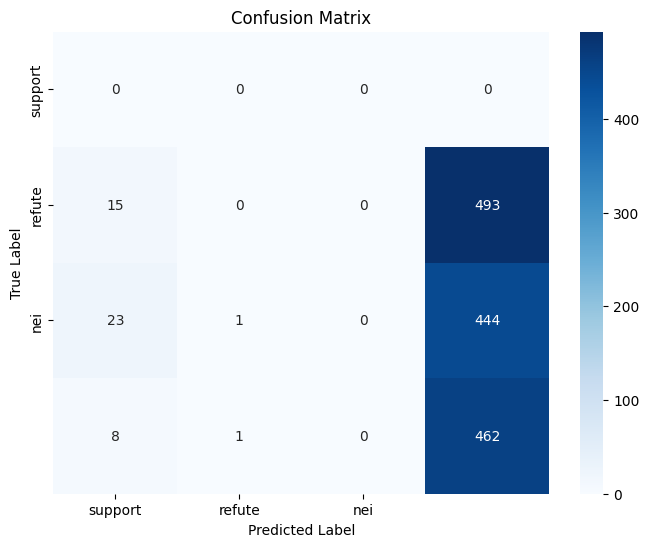

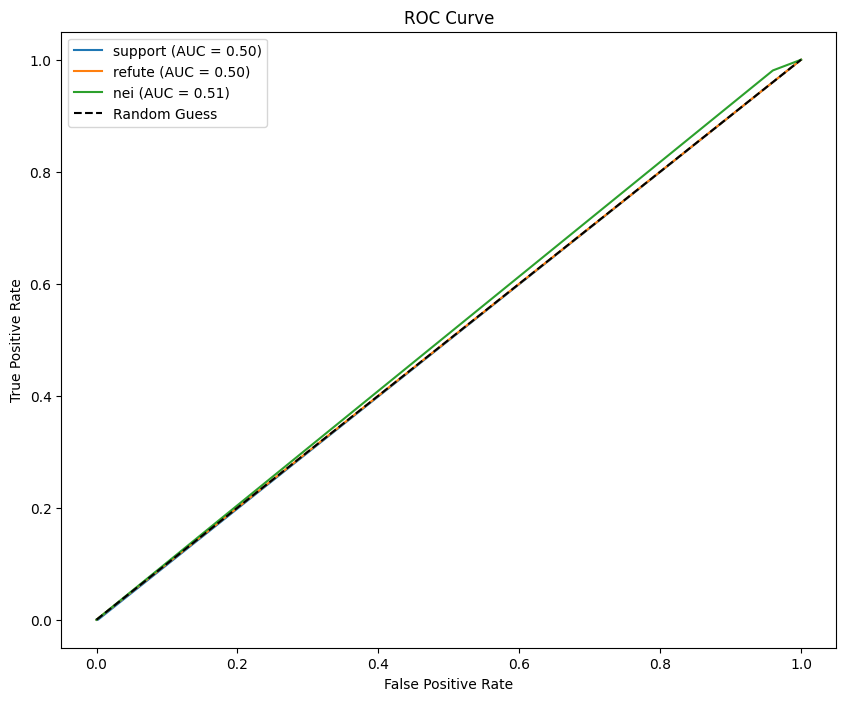

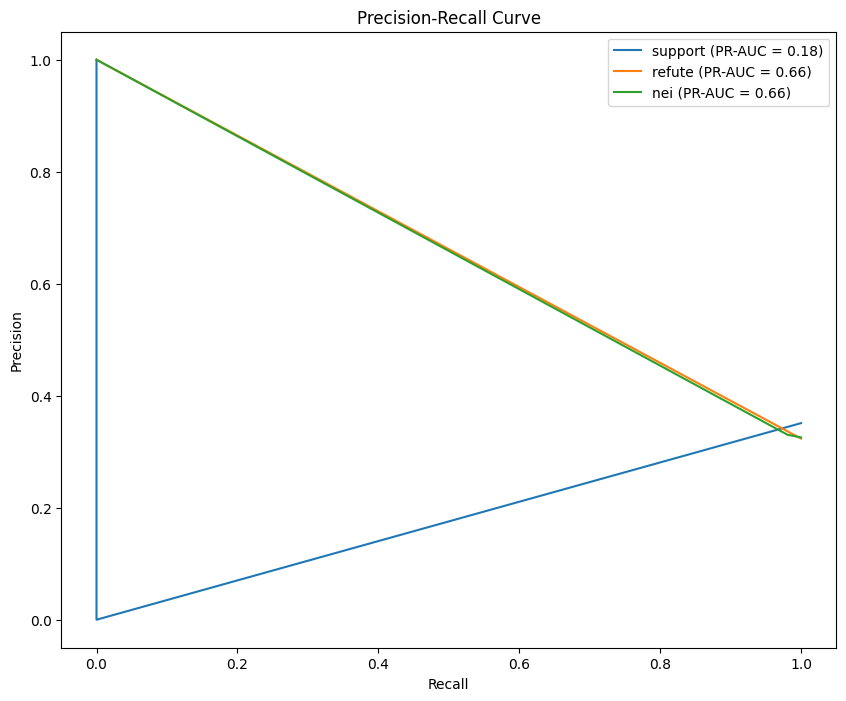

In [8]:
# Save and Evaluate
fact_check_results = pd.read_csv("fact_check_results_test.csv")
evaluate_results(fact_check_results)

In [9]:
'''
return f"""
        Classify the following statement into one of these categories based on the provided context and evidence:
        - **Support**: The statement is supported by the context or evidence.
        - **Refuted**: The statement is contradicted by the context or evidence.
        - **N.E.I**: There is insufficient information to verify the statement.

        ### Inputs:
        - Statement: "{statement}"
        - Context: "{context}"
        - Evidence: {evidence_text}

         ### Instructions:
        Respond with exactly one of the following labels: Support, Refuted, or Not Enough Info. 
        Do not include any additional text. The response must strictly follow this format:
        <RESPONSE>: [Label Here]
    
        ### Example Responses:
        - <RESPONSE>: Support
        - <RESPONSE>: Refuted
        - <RESPONSE>: N.E.I
    """
return f"""
        Kiểm tra tính chính xác của các tuyên bố dựa trên thông tin được cung cấp. 
        Đọc kỹ tuyên bố, ngữ cảnh và các bằng chứng, sau đó phân loại tuyên bố vào một trong ba nhãn:
        
        - *Support*: Tuyên bố được hỗ trợ bởi ngữ cảnh hoặc bằng chứng.
        - *Refuted*: Tuyên bố bị bác bỏ bởi ngữ cảnh hoặc bằng chứng.
        - *N.E.I*: Không đủ thông tin để xác minh tính đúng/sai của tuyên bố.

        ### Nhiệm vụ:
        1. Đọc và hiểu rõ *tuyên bố*: "{statement}".
        2. Đọc *ngữ cảnh* sau: "{context}".
        3. Phân tích *các bằng chứng liên quan* sau đây:
        {evidence_text if evidence_text else "Không có bằng chứng được cung cấp."}
        4. Dựa trên thông tin trên, phân loại tuyên bố vào một trong ba nhãn (*Support*, *Refuted*, hoặc *N.E.I*).
        5. Trả lời chỉ với nhãn chính xác (không giải thích thêm).

        ### Example Responses:
        - <RESPONSE>: Support
        - <RESPONSE>: Refuted
        - <RESPONSE>: N.E.I
    """
'''

'\nreturn f"""\n        Classify the following statement into one of these categories based on the provided context and evidence:\n        - **Support**: The statement is supported by the context or evidence.\n        - **Refuted**: The statement is contradicted by the context or evidence.\n        - **N.E.I**: There is insufficient information to verify the statement.\n\n        ### Inputs:\n        - Statement: "{statement}"\n        - Context: "{context}"\n        - Evidence: {evidence_text}\n\n         ### Instructions:\n        Respond with exactly one of the following labels: Support, Refuted, or Not Enough Info. \n        Do not include any additional text. The response must strictly follow this format:\n        <RESPONSE>: [Label Here]\n    \n        ### Example Responses:\n        - <RESPONSE>: Support\n        - <RESPONSE>: Refuted\n        - <RESPONSE>: N.E.I\n    """\nreturn f"""\n        Kiểm tra tính chính xác của các tuyên bố dựa trên thông tin được cung cấp. \n        Đ